In [4]:
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gc
from torch.optim.lr_scheduler import StepLR
import torchvision as tv
import timm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from joblib import Parallel, delayed
from PIL import Image
from scipy.stats import exponweib,lognorm, beta, betaprime, norm, expon, wasserstein_distance
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import r2_score as r2
mean_out=0
import torchvision
#class_num=4
target_length=500
device='cuda'

def classifier(dataloader, constants, weights):
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            l=200
            self.fc2=nn.Conv2d(100, l, 1, stride=2)
            #self.m1 = nn.BatchNorm1d(1000)
            self.d1 = nn.Dropout(.2)
            self.fc1=nn.Conv2d(40, 100, 1, stride=2)
            #self.m2 = nn.BatchNorm1d(l)

            self.fc5 = nn.Conv2d(l, 5,1, stride=1)
            #self.m3 = nn.BatchNorm1d(100)
            self.fc6 = nn.Linear(312500,1000)
            self.d3 = nn.Dropout(.2)
            self.fc7 = nn.Linear(100,4)
            self.fc8 = nn.Linear(2000,1000)

        def forward(self, x):
            b = x.shape[0]
            x = x.squeeze()
            
            l=200
            x = F.relu(self.fc1(x))
            #x = self.m1(x)
            x = self.d1(x)
            x = F.relu(self.fc2(x))
            #x = self.m2(x)
            x = self.d2(x)

            x = F.relu(self.fc5(x))
            #x = self.m3(x)
            x = x.reshape(b, -1)
            #x = F.relu(self.fc4(x))
            x = (self.fc6(x))

            return x


    class Patch_model(nn.Module):
        def __init__(self):
            super(Patch_model, self).__init__()
            self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.5,num_classes=500,pretrained=True)
            self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.5,num_classes=500,pretrained=True)
            self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.5,num_classes=500,pretrained=True)
            self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.5,num_classes=500,pretrained=True)


            self.fc0=nn.Linear(2000,200)
            self.fc1=nn.Linear(200,4)
            #self.fc2=nn.Linear(1000,500)


        def forward(self, x):
            l2=224
            x1 = x[:,:,0:l2,0:l2]
            x2 = x[:,:,0:l2,l2:]
            x3 = x[:,:,l2:,0:l2]
            x4 = x[:,:,l2:,l2:]
            x1 = (self.m1(x1))
            x2 = (self.m2(x2))
            x3 = (self.m3(x3))
            x4 = (self.m4(x4))
            
            #x4 = F.gelu(self.m4(x4))
            x = torch.cat([x1,x2,x3,x4],dim=1)

            x = F.gelu(self.fc0(x))

            x = F.softmax(self.fc1(x),dim=1)


            return x#,x2,x3,x4\


    class Net7(nn.Module):
        def __init__(self):
            super(Net7, self).__init__()
            self.m1 = timm.create_model('regnetx_160.pycls_in1k', in_chans=40,drop_path_rate=0.6, num_classes=4,pretrained=True)

        def forward(self, x):
            x = F.softmax(self.m1(x),dim=1)
            return x


    class Net6(nn.Module):
        def __init__(self):
            super(Net6, self).__init__()
            self.m1 = timm.create_model('regnetx_064', in_chans=40,drop_path_rate=0.4, num_classes=4,pretrained=True)

        def forward(self, x):
            x = F.softmax(self.m1(x),dim=1)
            return x
        
    class Net5(nn.Module):
        def __init__(self):
            super(Net5, self).__init__()
            self.m1 = timm.create_model('densenet169', in_chans=40, num_classes=4,pretrained=True)

        def forward(self, x):
            x = F.softmax(self.m1(x),dim=1)
            return x

    class Net4(nn.Module):
        def __init__(self):
            super(Net4, self).__init__()
            self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.9,num_classes=4,pretrained=True)

        def forward(self, x):
            x = F.softmax(self.m1(x),dim=1)
            return x
            
    class Net2(nn.Module):
        def __init__(self):
            super(Net2, self).__init__()
            self.m1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0.6,num_classes=3,pretrained=True)

        def forward(self, x):
            x = F.softmax(self.m1(x),dim=1)
            return x
        
    class Net0(nn.Module):
        def __init__(self):
            super(Net0, self).__init__()
            self.m1 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0.8,num_classes=4,pretrained=True)

        def forward(self, x):
            x = F.softmax(self.m1(x),dim=1)
            return x

    class Net1(nn.Module):
        def __init__(self):
            super(Net1, self).__init__()
            self.m1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0.6,num_classes=4,pretrained=True)

        def forward(self, x):
            x = F.softmax(self.m1(x),dim=1)
            return x
        
    class Net3(nn.Module):
        def __init__(self):
            super(Net3, self).__init__()
            l=80

            self.fc1=nn.Linear(1000,l)
            self.d1 = nn.Dropout(.1)
            self.fc2=nn.Linear(1000,l)
            self.d2 = nn.Dropout(.1)
            self.fc3 = nn.Linear(40*l*l,1000)
            self.d3 = nn.Dropout(.1)
            self.fc4 = nn.Linear(1000,250)
            self.fc4_2 = nn.Linear(250,1000)


        def forward(self, x):
            b = x.shape[0]
            x = F.relu(self.fc1(x))
            x = self.d1(x)
            x = x.permute(0,1,3,2)
            x = F.relu(self.fc2(x))
            x = self.d2(x)
            x = torch.reshape(x, [b,-1])
            x = F.relu(self.fc3(x))
            x = self.d3(x)
            x = F.relu(self.fc4(x))
            #x = torch.reshape(x, [b,10000])
            x = (self.fc4_2(x))

            return x
            
    # model3 = timm.create_model('volo_d3_448', in_chans=30,drop_path_rate=.0, num_classes=4,pretrained=False)
    # model3.load_state_dict(torch.load('models/speed_classifier_volod1_448px_disp_all_5_04'))
    # model3.to(device).eval()

    # model0 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=4,pretrained=False)
    # model0.load_state_dict(torch.load('models/speed_classifier_volod1_384px_disp_all_5_04_v3'))
    # model0.to(device).eval()

    # model1 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=4,pretrained=False)
    # model1.load_state_dict(torch.load('models/speed_classifier_volod1_384px_disp_all_5_04_v2'))
    # model1.to(device).eval()

    # model2 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=4,pretrained=False)
    # model2.load_state_dict(torch.load('models/speed_classifier_volod1_384px_disp_all_5_04_v1'))
    # model2.to(device).eval()

    model4 = timm.create_model('volo_d4_448', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    model4.load_state_dict(torch.load('models/speed_classifier_5class_volod4_448px_disp_all_5_04'))
    model4.to(device).eval()

    model5 = timm.create_model('volo_d3_448', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    model5.load_state_dict(torch.load('models/speed_classifier_5class_volod3_448px_disp_all_5_05'))
    model5.to(device).eval()

    model6 = timm.create_model('volo_d3_448', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    model6.load_state_dict(torch.load('models/speed_classifier_5class_volod3_448px_disp_lbm_5_07'))
    model6.to(device).eval()

    model7 = timm.create_model('volo_d3_448', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    model7.load_state_dict(torch.load('models/speed_classifier_5class_volod3_448px_disp_homo_5_07'))
    model7.to(device).eval()

    #model8 = timm.create_model('volo_d3_448', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    #model8.load_state_dict(torch.load('models/speed_classifier_5class_volod3_448px_disp_lbm_5_07_v2'))
    #model8.to(device).eval()

    #model9 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    #model9.load_state_dict(torch.load('models/speed_classifier_5class_volod1_384px_disp_all_5_06'))
    #model9.to(device).eval()

    model10 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    model10.load_state_dict(torch.load('models/speed_classifier_5class_volod1_384px_disp_all_5_06_v2'))
    model10.to(device).eval()

    model11 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    model11.load_state_dict(torch.load('models/speed_classifier_5class_volod1_384px_disp_all_5_06_v3'))
    model11.to(device).eval()

    #model12 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    #model12.load_state_dict(torch.load('models/speed_classifier_5class_volod1_384px_disp_all_5_06_v4'))
    #model12.to(device).eval()

    model13 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    model13.load_state_dict(torch.load('models/speed_classifier_5class_volod1_384px_disp_all_5_06_v5'))
    model13.to(device).eval()

    model14 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    model14.load_state_dict(torch.load('models/speed_classifier_5class_volod1_384px_disp_all_5_06_v6'))
    model14.to(device).eval()
    
    model15 = timm.create_model('efficientvit_b1', in_chans=30, num_classes=5,pretrained=False)
    model15.load_state_dict(torch.load('models/speed_classifier_efficientvit_b1_mse_448px_all_5_08'))
    model15.to(device).eval()
    
    model16 = timm.create_model('pvt_v2_b1', in_chans=30,num_classes=5,pretrained=False)
    model16.load_state_dict(torch.load('models/speed_classifier_pvt_v2_b1_mse_448px_all_5_08'))
    model16.to(device).eval()
    
    model17 = timm.create_model('regnetx_032', in_chans=30,num_classes=5,pretrained=False)
    model17.load_state_dict(torch.load('models/speed_classifier_regnetx_032_mse_448px_all_5_08'))
    model17.to(device).eval()
    
    model18 = timm.create_model('twins_svt_small', in_chans=30, num_classes=5,pretrained=False)
    model18.load_state_dict(torch.load('models/speed_classifier_twins_svt_small_mse_448px_all_5_09'))
    model18.to(device).eval()
    
    model19 = timm.create_model('davit_base', in_chans=30, num_classes=5,pretrained=False)
    model19.load_state_dict(torch.load('models/speed_classifier_davit_base_small_mse_448px_all_5_09'))
    model19.to(device).eval()
    
    model20 = timm.create_model('davit_base', in_chans=30, num_classes=5,pretrained=False)
    model20.load_state_dict(torch.load('models/speed_classifier_davit_base_small_mse_448px_all_5_09_v2'))
    model20.to(device).eval()
    
    model21 = timm.create_model('regnetx_064', in_chans=30, num_classes=3,pretrained=False)
    model21.load_state_dict(torch.load('models/speed_classifier_regnetx064_mse_448px_all_5_12'))
    model21.to(device).eval()
    
    model22 = timm.create_model('regnetx_064', in_chans=30, num_classes=3,pretrained=False)
    model22.load_state_dict(torch.load('models/speed_classifier_regnetx064_mse_448px_all_5_12_v2'))
    model22.to(device).eval()
    
    model23 = timm.create_model('regnetx_064', in_chans=30, num_classes=3,pretrained=False)
    model23.load_state_dict(torch.load('models/speed_classifier_regnetx064_mse_448px_all_5_12_v3'))
    model23.to(device).eval()
    
    model24 = timm.create_model('regnetx_160', in_chans=30, num_classes=3,pretrained=False)
    model24.load_state_dict(torch.load('models/speed_classifier_regnetx160_mse_448px_all_5_12'))
    model24.to(device).eval()
    
    model25 = timm.create_model('pvt_v2_b0', in_chans=30, num_classes=3,pretrained=False)
    model25.load_state_dict(torch.load('models/speed_classifier_pvt_v2_b0_mse_384px_all_5_12'))
    model25.to(device).eval()
    
    model26 = timm.create_model('pvt_v2_b1', in_chans=30, num_classes=3,pretrained=False)
    model26.load_state_dict(torch.load('models/speed_classifier_pvt_v2_b1_mse_384px_all_5_12'))
    model26.to(device).eval()
    
    model27 = timm.create_model('pvt_v2_b2', in_chans=30, num_classes=3,pretrained=False)
    model27.load_state_dict(torch.load('models/speed_classifier_pvt_v2_b2_mse_384px_all_5_12'))
    model27.to(device).eval()
    
    
    #outputs3=[]
    
    outputs1=[]
    count=0
    with torch.no_grad():
        for x in test_dataloader2:
            if torch.mean(x)>.5:
                x = 1-x
            #x=1-x
            #x1 = tv.transforms.functional.resize(x, 448)
            x2 = tv.transforms.functional.resize(x, 384)
            #x3 = tv.transforms.functional.resize(x, 224)
            # out0 =F.softmax((model0((x2).to(device)).detach().cpu()),1).numpy()
            # out1 =F.softmax((model1((x2).to(device)).detach().cpu()),1).numpy()
            # out2 =F.softmax((model2((x2).to(device)).detach().cpu()),1).numpy()
            # out3 =F.softmax((model3((x).to(device)).detach().cpu()),1).numpy()


            #out4 =F.softmax((model4((x).to(device)).detach().cpu()),1).numpy()
            out5 =F.softmax((model5((x).to(device)).detach().cpu()),1).numpy()
            out6 =F.softmax((model6((x).to(device)).detach().cpu()),1).numpy() # class 4, close to 1
            out7 =F.softmax((model7((1-x).to(device)).detach().cpu()),1).numpy()
            #out8 =F.softmax((model8((x).to(device)).detach().cpu()),1).numpy()
            #out9 =F.softmax((model9((x2).to(device)).detach().cpu()),1).numpy()
            out10 =F.softmax((model10((x2).to(device)).detach().cpu()),1).numpy()
            out11 =F.softmax((model11((x2).to(device)).detach().cpu()),1).numpy()
            #out12 =F.softmax((model12((x2).to(device)).detach().cpu()),1).numpy()
            out13 =F.softmax((model13((x2).to(device)).detach().cpu()),1).numpy()
            out13[:,3] = out13[:,3]*.1
            out14 =F.softmax((model15((x2).to(device)).detach().cpu()),1).numpy() #class 2 close to cslaa 3
            #out15 =F.softmax((model15((x).to(device)).detach().cpu()),1).numpy() # class 4
            out16 =F.softmax((model16((x).to(device)).detach().cpu()),1).numpy() #class 2 .25
            out17 =F.softmax((model17((x).to(device)).detach().cpu()),1).numpy() # class 2
            out18 =F.softmax((model18((x).to(device)).detach().cpu()),1).numpy() # class 2
            out19 =F.softmax((model19((x).to(device)).detach().cpu()),1).numpy() # class 3
            out20 =F.softmax((model20((x).to(device)).detach().cpu()),1).numpy() # class 2, .22
            out21 =F.softmax((model21((x).to(device)).detach().cpu()),1).numpy()
            out21z = np.zeros([len(out21), 5])
            out21z[:,2:5] = out21
            out22 =F.softmax((model22((x).to(device)).detach().cpu()),1).numpy()
            out22z = np.zeros([len(out22), 5])
            out22z[:,2:5] = out22
            out23 =F.softmax((model23((x).to(device)).detach().cpu()),1).numpy()
            out23z = np.zeros([len(out23), 5])
            out23z[:,2:5] = out23
            out24 =F.softmax((model24((x).to(device)).detach().cpu()),1).numpy()
            out24z = np.zeros([len(out24), 5])
            out24z[:,2:5] = out24
            out25 =F.softmax((model25((x2).to(device)).detach().cpu()),1).numpy()
            out25z = np.zeros([len(out25), 5])
            out25z[:,2:5] = out25
            out26 =F.softmax((model26((x2).to(device)).detach().cpu()),1).numpy()
            out26z = np.zeros([len(out26), 5])
            out26z[:,2:5] = out26
            out27 =F.softmax((model27((x2).to(device)).detach().cpu()),1).numpy()
            out27z = np.zeros([len(out27), 5])
            out27z[:,2:5] = out27
            
            #out=(out11*5+out14*.5+out16*28.5+out17*22.6+out19*3+out5*17.5+out10*3.4+out7*.6+out13*32.2+out6*2+out18*1.5)/constants[0]#(out16*4+out17*2+out14*.5)/6.5#(out0*2+out3*40+out5*2+out7*2+out10+out13)/48
            ensemble_expression = "+".join(f"out{weight[0]}*{weight[1]}" for weight in weights)
            out = eval(ensemble_expression) / constants[0]
            out[:,0] = out[:,0]+constants[1]
            out[:,1] = out[:,1]+constants[2]
            out[:,2] = out[:,2]+constants[3]
            out[:,3] = out[:,3]+constants[4]
            out[:,4] = out[:,4]+constants[5]
            out = out/1.25

            outputs1.append(out)
            count=count+1

    # print
    return outputs1


class TestDataset2(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]

        return image.float()
        
def calculate_velocity( y_positions):
    # Calculate velocities
    y_velocities = (y_positions[1:] - y_positions[:-1]) 
            
    return  y_velocities
        
def calculate_angles(x_arr, y_arr):
    traj_stats=[]
    for n in range(x_arr.shape[1]):
        x_diff = np.diff(x_arr[:,n])
        y_diff = np.diff(y_arr[:,n])
        angles=np.zeros((len(x_diff),1))
        for i in range(len(x_diff)-1):
            theta_1=np.arctan(y_diff[i]/x_diff[i])
            theta_2=np.arctan(y_diff[i+1]/x_diff[i+1])
            angles[i]=(theta_2-theta_1)*(180/np.pi)
    
        traj_stats.append([n, angles])
    angle_array=[]
    vel_array=[]
    for i in range(len(traj_stats)):
        section1=traj_stats[i][1]
        section1=np.reshape(section1,(len(section1),))
        angle_array=np.hstack([section1,angle_array])
    
    angle_array
    angle_array=np.abs(angle_array[~np.isnan(angle_array)])
    angle_array = angle_array[angle_array>0]

    return angle_array

def interpolate_vectors(vector, target_length):
    current_length = len(vector)
    # Create a new x-axis with the desired length
    new_x = np.linspace(0, current_length - 1, target_length)
    # Create the old x-axis based on the current length
    old_x = np.arange(current_length)
    # Perform linear interpolation
    interpolated_vector = np.interp(new_x, old_x, vector)
    return interpolated_vector
    
def process_file(file_path, l):
    image = np.array(Image.open(file_path))
    resized_image = cv2.resize(image, [l, l])
    resized_image = (resized_image - np.min(resized_image)) / (np.max(resized_image) - np.min(resized_image))
    resized_image = np.nan_to_num(resized_image,1)
    return resized_image

def parallel_image_processing(full_files, l):
    num_files = len(full_files)
    images = np.zeros([num_files, l, l])
    results = Parallel(n_jobs=16)(delayed(process_file)(file_path, l) for file_path in full_files)
    for i, resized_image in enumerate(results):
        images[i] = resized_image
    return images
    
def calculate_angles_test(x_arr, y_arr):
    traj_stats=[]
    x_diff = np.diff(x_arr)
    y_diff = np.diff(y_arr)
    #print(x_diff.shape)
    angles=np.zeros((len(x_diff),1))
    for i in range(len(x_diff)-1):
        theta_1=np.arctan(y_diff[i]/x_diff[i])
        theta_2=np.arctan(y_diff[i+1]/x_diff[i+1])
        angles[i]=(theta_2-theta_1)*(180/np.pi)
        traj_stats.append([angles])
    
    angles=np.abs(angles[~np.isnan(angles)])
    angles = interpolate_vectors(np.sort(angles), target_length)
    angles=angles[angles!=0]
    #angles[angles==0]=0.1
    return angles
    
# Custom sorting key function
def sort_key2(item):
    if 'het' in item:
        return (0, int(item.split('_')[0]))
    elif 'brown' in item:
        return (1, int(item[6:-10]))
    elif 'test' in item:
        return (3, int(item[7:-4])) # Extract the numeric part for files with '_brown'
    else:
        return (2, int(item[6:-4]))  # Extract the numeric part for files without '_brown'


# sim_base = 'C:/Users/marcb/OneDrive/Desktop/het_trajectories/sim_trajectories/sim/'
# tmate_base = 'C:/Users/marcb/OneDrive/Desktop/het_trajectories/sim_trajectories/tmate/'

sim_directory='../sim_trajectories/sim/'
tmate_directory='../sim_trajectories/tmate/'
sim_filenames = os.listdir(sim_directory)
tmate_filenames = os.listdir(tmate_directory)

print(sim_filenames)
print(tmate_filenames)

gc.collect()
# Sort the list using the custom key
sorted_file_dir = sorted(sim_filenames, key=sort_key2)
# tmate_directory = sorted(tmate_filenames, key=sort_key2)
# Split the sorted list into 'yc_' and 'xc_' files
yc_files = [f for f in sorted_file_dir if 'yc' in f]
xc_files = [f for f in sorted_file_dir if 'xc' in f]

# Create a list of lists with corresponding 'yc_' and 'xc_' files
sorted_file_pairs = [[yc, xc] for yc, xc in zip(yc_files, xc_files)]

#sorted_file_pairs=sorted_file_pairs[1110:]
print(sorted_file_pairs)
# f_idx = 9
# print(filenames[f_idx])

directories = [
'test_sims_het/1000part_16xspeed_heterogeneous/','test_sims_het/1000part_32xspeed_heterogeneous/',
'test_sims_het/1000part_4xspeed_heterogeneous/','test_sims_het/1000part_heterogeneous/',
'test_sims_het/2000part_16xspeed_heterogeneous/','test_sims_het/2000part_32xspeed_heterogeneous/', ## Group 1
'test_sims_het/2000part_4xspeed_heterogeneous/','test_sims_het/2000part_heterogeneous/',
'test_sims_het/500part_16xspeed_heterogeneous/','test_sims_het/500part_32xspeed_heterogeneous/',
'test_sims_het/500part_4xspeed_heterogeneous/','test_sims_het/500part_heterogeneous/',
'test_sims/sim111_brown/', 'test_sims/sim112_brown/',
'test_sims/sim113_brown/','test_sims/sim114_brown/',  # Group 2
'test_sims/sim115_brown/','test_sims/sim119_brown/','test_sims/sim120_brown/',
'test_sims/sim2201/', 'test_sims/sim2210/', 'test_sims/sim2215/',
'test_sims/sim2220/','test_sims/sim2230/','test_sims/sim2235/','test_sims/sim2240/', # Group 3
'test_sims/sim2241/','test_sims/sim2242/','test_sims/sim2243/','test_sims/sim2244/', #Group 4
'test_sims/sim2251/','test_sims/sim2252/','test_sims/sim2253/',
'test_sims/sim2254/','test_sims/sim2255/','test_sims/sim2256/',
'test_sims/sim2257/','test_sims/sim2258/','test_sims/sim2259/','test_sims/sim2260/', # Group 5
'test_sims/test1/','test_sims/test2/','test_sims/test5/','test_sims/test8/' #Group 6
]

#Speed
speed_list=[]
angles_list=[]
vx_list=[]
vy_list=[]
directions_list=[]
directions_mean_list=[]

for f_idx in range(0,len(directories)):
    print(f_idx)
    print(len(tmate_filenames), len(directories))
    base=directories[f_idx]
    
    print(base)
    #base='shew_noflow/8040_20x_002_frames/'
    files=os.listdir(base)
    print(files[0])
    #5 for noflow
    #3 ofr flow
    full_files=[]
    if 'noflow' in base:
        sorted_frames = sorted(files, key=lambda x: int(x[5:-4]))
    elif 'homo' in base:
        sorted_frames = sorted(files, key=lambda x: int(x[4:-4]))
    elif 'test_sims_het' in base:
        sorted_frames = sorted(files, key=lambda x: int(x[4:-4]))
    elif 'test_sims' in base:
        sorted_frames = sorted(files, key=lambda x: int(x[4:-4]))
    elif 'frame' in files[0]:
        sorted_frames = sorted(files, key=lambda x: int(x[5:-4]))
    elif 'brown' in base:
        sorted_frames = sorted(files, key=lambda x: int(x[4:-4]))
    else:
        sorted_frames = sorted(files, key=lambda x: int(x[3:-4]))

    for i in range(len(sorted_frames)):
        file = base+sorted_frames[i]
        full_files.append(file)
        
    

    l1=448
    l2 = 384
    l3 = 224


   # images = parallel_image_processing(full_files,l1)
   # images2 = parallel_image_processing(full_files,l1)

    #plt.figure(figsize=(10,10),dpi=500)
    #plt.imshow(images1[-1])

    # if (images.shape[0]-30)%40==0:
    #     images = images[30:,:,:].reshape([(images.shape[0]-30)//40,40,448,448])
    # elif (images.shape[0]-20)%40==0:
    #     images = images[20:,:,:].reshape([(images.shape[0]-20)//40,40,448,448])
    # elif (images.shape[0]-10)%40==0:
    #     images = images[10:,:,:].reshape([(images.shape[0]-10)//40,40,448,448])
    # else:
    #     images = images.reshape([(images.shape[0])//40,40,448,448])
        
    # images = torch.tensor(images)

    # dataset_test = TestDataset2(images)#  xtorch_test, distr_torch_test, scales_test2)
    # if len(images)<4:
    #     batch_size = 1
    # else:
    #     batch_size = 4
    # test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=0)


    print('Ground Truth filenames: ', sorted_file_pairs[f_idx][1], sorted_file_pairs[f_idx][0])
    x_arr= np.array(pd.read_csv(sim_directory+sorted_file_pairs[f_idx][1], header=None))
    y_arr= np.array(pd.read_csv(sim_directory+sorted_file_pairs[f_idx][0], header=None))
    vx = np.diff(x_arr, axis=0)
    vy = np.diff(y_arr, axis=0)
    vels_gt = np.sqrt(vx**2+vy**2)
    vels_gt=vels_gt[~np.isnan(vels_gt)]
    vels_gt = vels_gt[vels_gt>0]
    vels_gt = vels_gt[vels_gt<300]
    speed_list.append(vels_gt)
    
    #x_arr= np.array(pd.read_csv(sim_directory+sorted_file_pairs[f_idx][1], header=None))
    #y_arr= np.array(pd.read_csv(sim_directory+sorted_file_pairs[f_idx][0], header=None))
    angles_gt = calculate_angles(x_arr,y_arr)
    angles_gt=angles_gt[~np.isnan(angles_gt)]
    angles_gt = angles_gt[angles_gt>0]
    angles_gt = angles_gt[angles_gt<360]
    angles_list.append(angles_gt)

    vx=vx[~np.isnan(vx)]
    vx = vx[vx!=0]
    vx = vx[np.abs(vx)<300]
    vx_list.append(vx)
    
    vy=vy[~np.isnan(vy)]
    vy = vy[vy!=0]
    vy = vy[np.abs(vy)<=300]
    vy_list.append(vy)


    x_arr= np.array(pd.read_csv(sim_directory+sorted_file_pairs[f_idx][1], header=None))
    y_arr= np.array(pd.read_csv(sim_directory+sorted_file_pairs[f_idx][0], header=None))
    vx = np.diff(x_arr, axis=0)
    vy = np.diff(y_arr, axis=0)
    true_direc=[]
    
    for i in range(x_arr.shape[1]):
        try:
            xpart = x_arr[:,i]
            ypart = y_arr[:,i]
            posx = xpart[~np.isnan(xpart)]
            posy = ypart[~np.isnan(ypart)]
            xdist = posx[-1] - posx[0]
            ydist = posy[-1] - posy[0]
            speed = speed = np.sum(np.sqrt(np.diff(xpart)**2+np.diff(ypart)**2))
            disp = np.sqrt(xdist**2+ydist**2)
            true_direc.append(np.nanmean(disp)/np.nanmean(speed))
        except:
            true_direc.append(0)
    directions_list.append(true_direc)
    directions_mean_list.append(np.nanmean(true_direc))



['00_het_xc_1000part_16xspeed.csv', '01_het_yc_1000part_16xspeed.csv', '02_het_xc_1000part_32xspeed.csv', '03_het_yc_1000part_32xspeed.csv', '04_het_xc_1000part_4xspeed.csv', '05_het_yc_1000part_4xspeed.csv', '06_het_xc_1000part.csv', '07_het_yc_1000part.csv', '08_het_xc_2000part_16xspeed.csv', '09_het_yc_2000part_16xspeed.csv', '10_het_xc_2000part_32xspeed.csv', '11_het_yc_2000part_32xspeed.csv', '12_het_xc_2000part_4xspeed.csv', '13_het_yc_2000part_4xspeed.csv', '14_het_xc_2000part.csv', '15_het_yc_2000part.csv', '16_het_xc_500part_16xspeed.csv', '17_het_yc_500part_16xspeed.csv', '18_het_xc_500part_32xspeed.csv', '19_het_yc_500part_32xspeed.csv', '20_het_xc_500part_4xspeed.csv', '21_het_yc_500part_4xspeed.csv', '22_het_xc_500part.csv', '23_het_yc_500part.csv', 'xc_sim111_brown.csv', 'xc_sim112_brown.csv', 'xc_sim113_brown.csv', 'xc_sim114_brown.csv', 'xc_sim115_brown.csv', 'xc_sim119_brown.csv', 'xc_sim120_brown.csv', 'xc_sim2201.csv', 'xc_sim2210.csv', 'xc_sim2215.csv', 'xc_sim2220.

C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))


1
44 44
test_sims_het/1000part_32xspeed_heterogeneous/
Fig_1.jpg
Ground Truth filenames:  02_het_xc_1000part_32xspeed.csv 03_het_yc_1000part_32xspeed.csv


C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))


2
44 44
test_sims_het/1000part_4xspeed_heterogeneous/
Fig_1.jpg
Ground Truth filenames:  04_het_xc_1000part_4xspeed.csv 05_het_yc_1000part_4xspeed.csv


C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))


3
44 44
test_sims_het/1000part_heterogeneous/
Fig_1.jpg
Ground Truth filenames:  06_het_xc_1000part.csv 07_het_yc_1000part.csv


C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))


4
44 44
test_sims_het/2000part_16xspeed_heterogeneous/
Fig_1.jpg
Ground Truth filenames:  08_het_xc_2000part_16xspeed.csv 09_het_yc_2000part_16xspeed.csv


C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))


5
44 44
test_sims_het/2000part_32xspeed_heterogeneous/
Fig_1.jpg
Ground Truth filenames:  10_het_xc_2000part_32xspeed.csv 11_het_yc_2000part_32xspeed.csv


C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))


6
44 44
test_sims_het/2000part_4xspeed_heterogeneous/
Fig_1.jpg
Ground Truth filenames:  12_het_xc_2000part_4xspeed.csv 13_het_yc_2000part_4xspeed.csv


C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))


7
44 44
test_sims_het/2000part_heterogeneous/
Fig_1.jpg
Ground Truth filenames:  14_het_xc_2000part.csv 15_het_yc_2000part.csv


C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))


8
44 44
test_sims_het/500part_16xspeed_heterogeneous/
Fig_1.jpg
Ground Truth filenames:  16_het_xc_500part_16xspeed.csv 17_het_yc_500part_16xspeed.csv


C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))


9
44 44
test_sims_het/500part_32xspeed_heterogeneous/
Fig_1.jpg
Ground Truth filenames:  18_het_xc_500part_32xspeed.csv 19_het_yc_500part_32xspeed.csv
10
44 44
test_sims_het/500part_4xspeed_heterogeneous/
Fig_1.jpg
Ground Truth filenames:  20_het_xc_500part_4xspeed.csv 21_het_yc_500part_4xspeed.csv


C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))


11
44 44
test_sims_het/500part_heterogeneous/
Fig_1.jpg
Ground Truth filenames:  22_het_xc_500part.csv 23_het_yc_500part.csv


C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))


12
44 44
test_sims/sim111_brown/
Fig_1.jpg
Ground Truth filenames:  xc_sim111_brown.csv yc_sim111_brown.csv
13
44 44
test_sims/sim112_brown/
Fig_1.jpg
Ground Truth filenames:  xc_sim112_brown.csv yc_sim112_brown.csv
14
44 44
test_sims/sim113_brown/
Fig_1.jpg
Ground Truth filenames:  xc_sim113_brown.csv yc_sim113_brown.csv
15
44 44
test_sims/sim114_brown/
Fig_1.jpg
Ground Truth filenames:  xc_sim114_brown.csv yc_sim114_brown.csv
16
44 44
test_sims/sim115_brown/
Fig_1.jpg
Ground Truth filenames:  xc_sim115_brown.csv yc_sim115_brown.csv
17
44 44
test_sims/sim119_brown/
Fig_1.jpg
Ground Truth filenames:  xc_sim119_brown.csv yc_sim119_brown.csv
18
44 44
test_sims/sim120_brown/
Fig_1.jpg
Ground Truth filenames:  xc_sim120_brown.csv yc_sim120_brown.csv
19
44 44
test_sims/sim2201/
Fig_1.jpg
Ground Truth filenames:  xc_sim2201.csv yc_sim2201.csv


C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:410: RuntimeWarning: divide by zero encountered in scalar divide
  theta_2=np.arctan(y_diff[i+1]/x_diff[i+1])
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:409: RuntimeWarning: divide by zero encountered in scalar divide
  theta_1=np.arctan(y_diff[i]/x_diff[i])
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:410: RuntimeWarning: invalid value encountered in scalar divide
  theta_2=np.arctan(y_diff[i+1]/x_diff[i+1])
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:409: RuntimeWarning: invalid value encountered in scalar divide
  theta_1=np.arctan(y_diff[i]/x_diff[i])
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:410: RuntimeWarning: divide by zero encountered in scalar divide
  theta_2=np.arctan(y_di

20
44 44
test_sims/sim2210/
Fig_1.jpg
Ground Truth filenames:  xc_sim2210.csv yc_sim2210.csv
21
44 44
test_sims/sim2215/
Fig_1.jpg
Ground Truth filenames:  xc_sim2215.csv yc_sim2215.csv


C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:409: RuntimeWarning: invalid value encountered in scalar divide
  theta_1=np.arctan(y_diff[i]/x_diff[i])
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:410: RuntimeWarning: invalid value encountered in scalar divide
  theta_2=np.arctan(y_diff[i+1]/x_diff[i+1])
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:409: RuntimeWarning: divide by zero encountered in scalar divide
  theta_1=np.arctan(y_diff[i]/x_diff[i])
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:410: RuntimeWarning: invalid value encountered in scalar divide
  theta_2=np.arctan(y_diff[i+1]/x_diff

22
44 44
test_sims/sim2220/
Fig_1.jpg
Ground Truth filenames:  xc_sim2220.csv yc_sim2220.csv
23
44 44
test_sims/sim2230/
Fig_1.jpg
Ground Truth filenames:  xc_sim2230.csv yc_sim2230.csv
24
44 44
test_sims/sim2235/
Fig_1.jpg
Ground Truth filenames:  xc_sim2235.csv yc_sim2235.csv


C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:410: RuntimeWarning: divide by zero encountered in scalar divide
  theta_2=np.arctan(y_diff[i+1]/x_diff[i+1])
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:409: RuntimeWarning: divide by zero encountered in scalar divide
  theta_1=np.arctan(y_diff[i]/x_diff[i])
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:410: RuntimeWarning: invalid value encountered in scalar divide
  theta_2=np.arctan(y_diff[i+1]/x_diff[i+1])
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:409: RuntimeWarning: invalid value encountered in scalar divide
  theta_1=np.arctan(y_diff[i]/x_diff[i])
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(

25
44 44
test_sims/sim2240/
Fig_1.jpg
Ground Truth filenames:  xc_sim2240.csv yc_sim2240.csv
26
44 44
test_sims/sim2241/
Fig_1.jpg
Ground Truth filenames:  xc_sim2241.csv yc_sim2241.csv
27
44 44
test_sims/sim2242/
Fig_1.jpg
Ground Truth filenames:  xc_sim2242.csv yc_sim2242.csv


C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))
C:\Users\marcb\AppData\Local\Temp\

28
44 44
test_sims/sim2243/
Fig_1.jpg
Ground Truth filenames:  xc_sim2243.csv yc_sim2243.csv
29
44 44
test_sims/sim2244/
Fig_1.jpg
Ground Truth filenames:  xc_sim2244.csv yc_sim2244.csv
30
44 44
test_sims/sim2251/
Fig_1.jpg
Ground Truth filenames:  xc_sim2251.csv yc_sim2251.csv
31
44 44
test_sims/sim2252/
Fig_1.jpg
Ground Truth filenames:  xc_sim2252.csv yc_sim2252.csv
32
44 44
test_sims/sim2253/
Fig_1.jpg
Ground Truth filenames:  xc_sim2253.csv yc_sim2253.csv
33
44 44
test_sims/sim2254/
Fig_1.jpg
Ground Truth filenames:  xc_sim2254.csv yc_sim2254.csv
34
44 44
test_sims/sim2255/
Fig_1.jpg
Ground Truth filenames:  xc_sim2255.csv yc_sim2255.csv


C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))


35
44 44
test_sims/sim2256/
Fig_1.jpg
Ground Truth filenames:  xc_sim2256.csv yc_sim2256.csv
36
44 44
test_sims/sim2257/
Fig_1.jpg
Ground Truth filenames:  xc_sim2257.csv yc_sim2257.csv
37
44 44
test_sims/sim2258/
Fig_1.jpg
Ground Truth filenames:  xc_sim2258.csv yc_sim2258.csv
38
44 44
test_sims/sim2259/
Fig_1.jpg
Ground Truth filenames:  xc_sim2259.csv yc_sim2259.csv
39
44 44
test_sims/sim2260/
Fig_1.jpg
Ground Truth filenames:  xc_sim2260.csv yc_sim2260.csv
40
44 44
test_sims/test1/
Fig_1.jpg
Ground Truth filenames:  xc_test1.csv yc_test1.csv
41
44 44
test_sims/test2/
Fig_1.jpg
Ground Truth filenames:  xc_test2.csv yc_test2.csv
42
44 44
test_sims/test5/
Fig_1.jpg
Ground Truth filenames:  xc_test5.csv yc_test5.csv
43
44 44
test_sims/test8/
Fig_1.jpg
Ground Truth filenames:  xc_test8.csv yc_test8.csv


C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))
C:\Users\marcb\AppData\Local\Temp\ipykernel_14656\3150465296.py:645: RuntimeWarning: Mean of empty slice
  true_direc.append(np.nanmean(disp)/np.nanmean(speed))


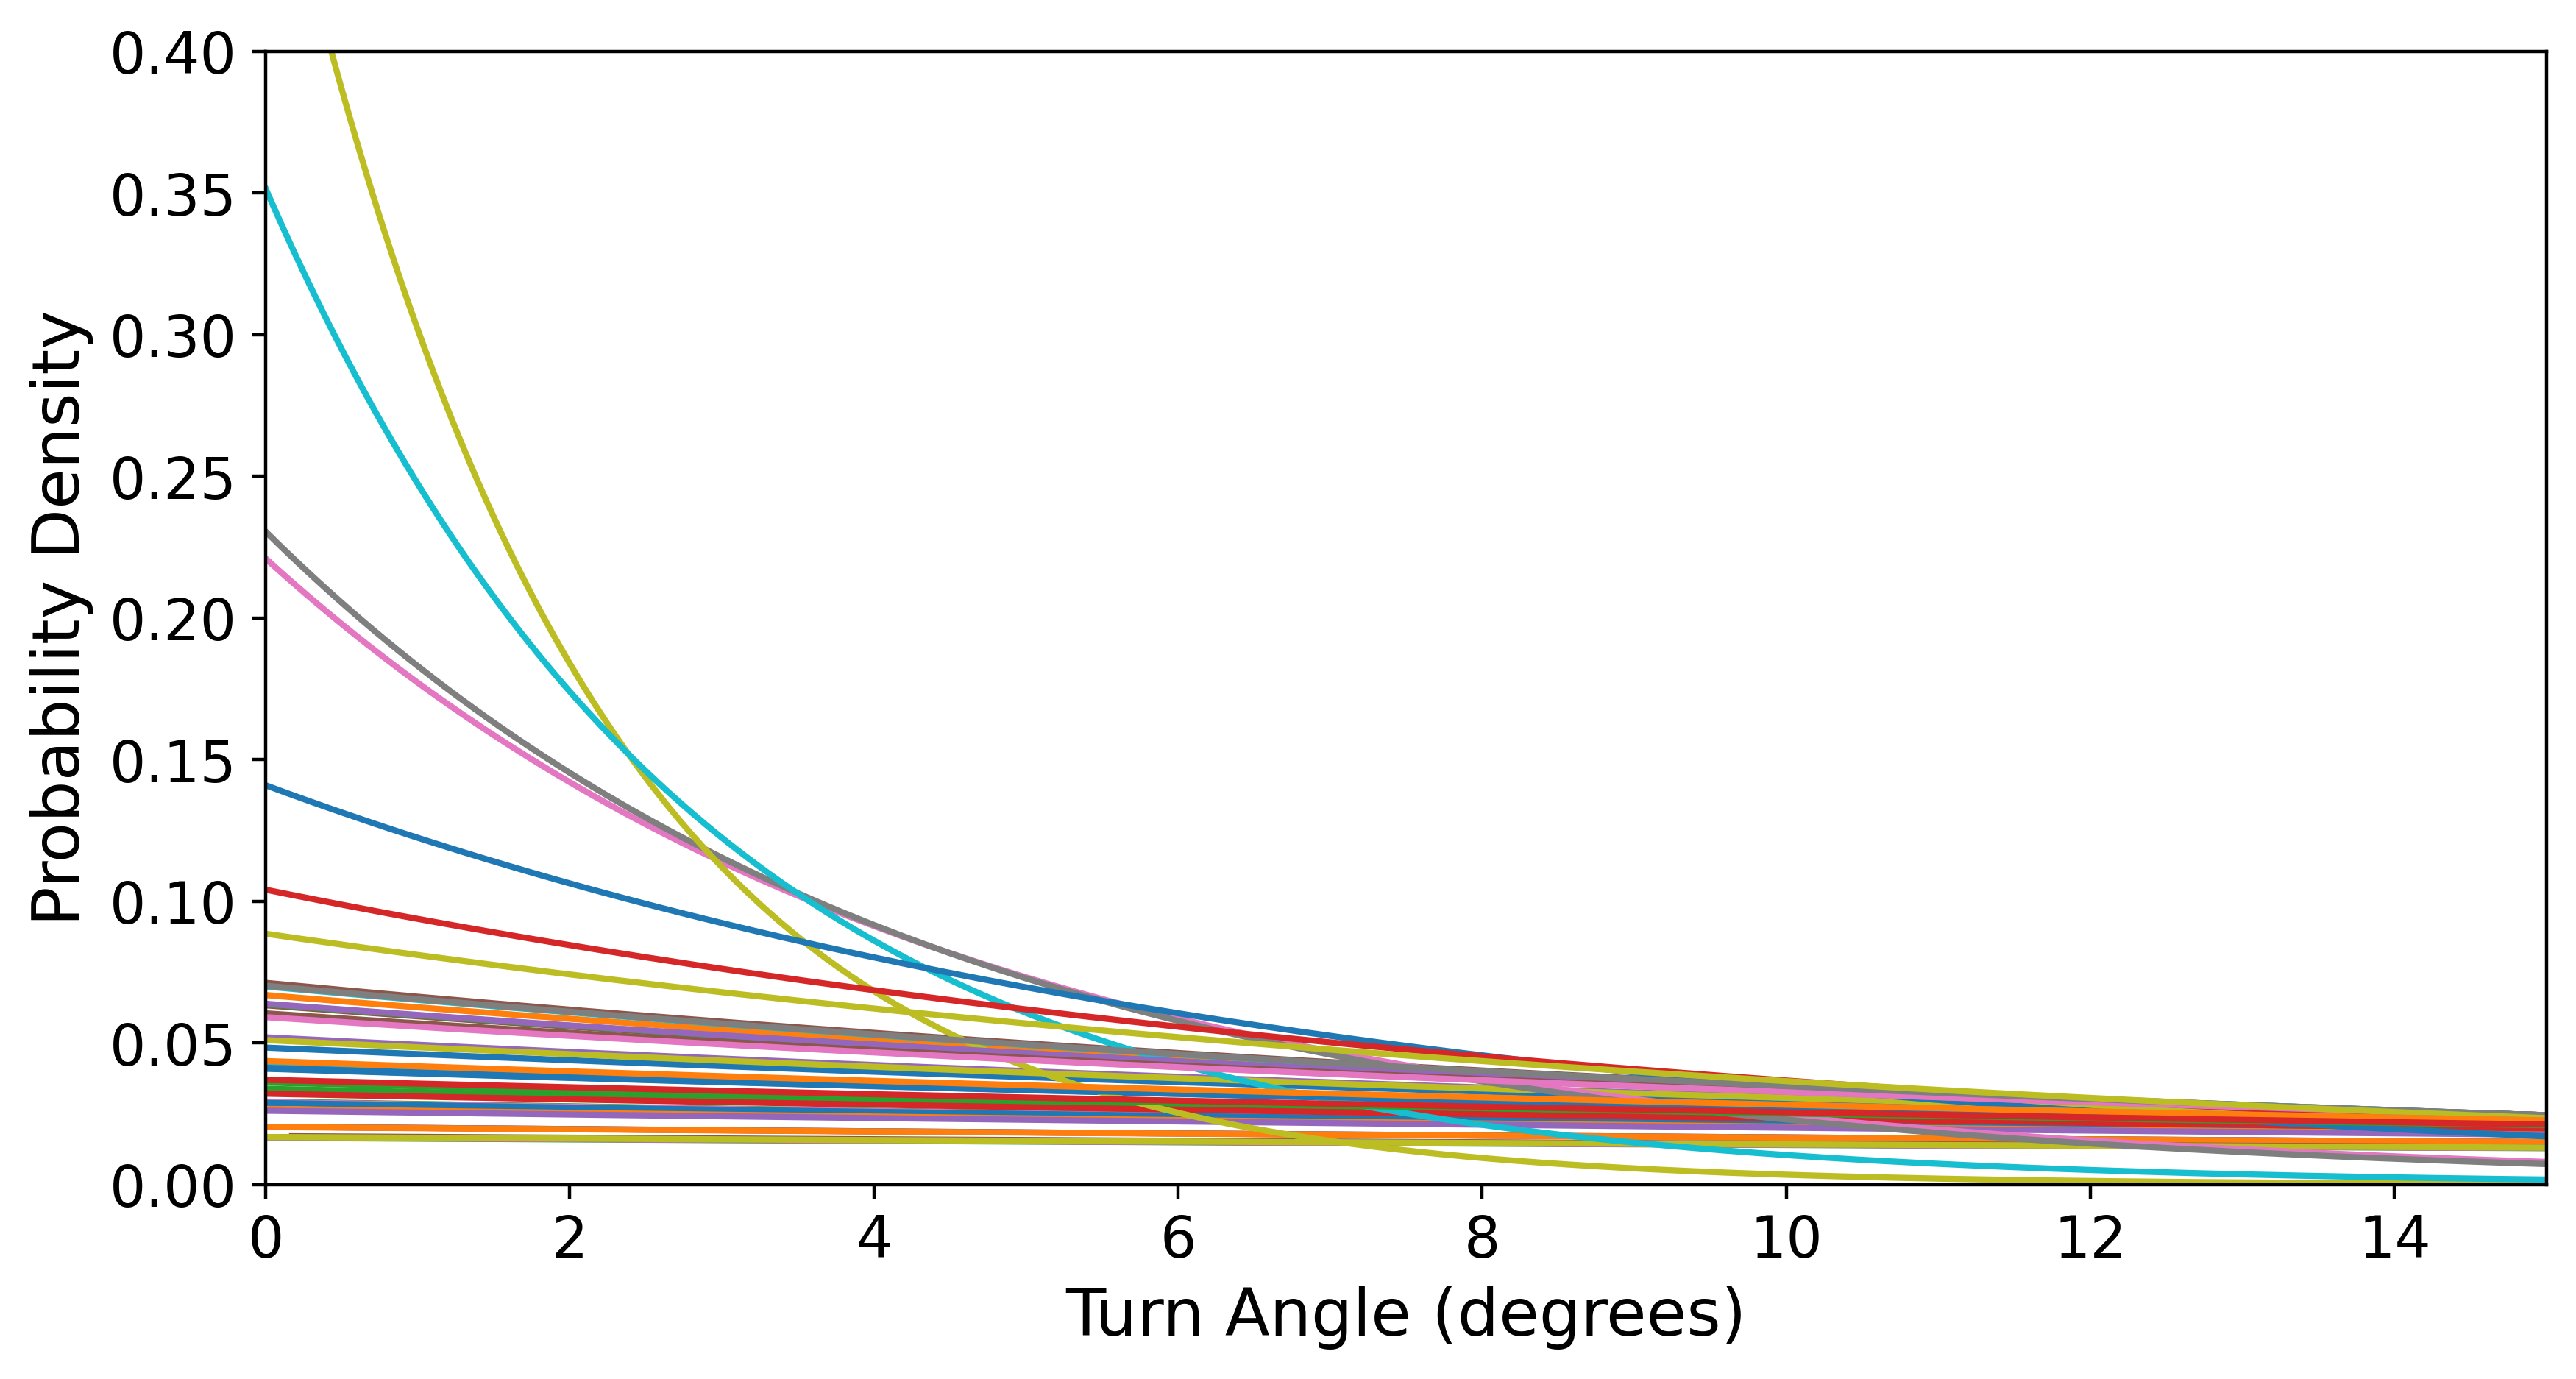

In [63]:
plt.figure(figsize=(10,5),dpi=400)
for i in range(len(angles_list)):
    w=interpolate_vectors(np.sort(angles_list[i]),1000)
    a,b = expon.fit(w)       
    xtorch= np.linspace(expon.ppf(0.0001, a,b),
                    expon.ppf(0.9999, a,b), target_length)
    distr_torch=expon.pdf(xtorch, a,b)
    plt.plot(xtorch,distr_torch)

plt.ylabel('Probability Density', fontsize=16)
plt.xlabel('Turn Angle (degrees)',fontsize=16)
plt.xlim([0,15])
plt.ylim([0,.4])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
#plt.yscale('log')
#plt.xscale('log')
#plt.title('Vx Distributions for All Test Simulations', fontsize=12)
plt.savefig('angle_test_variation_linear.png')
#plt.xscale('log')
#plt.yscale('log')


['00_het_xc_1000part_16xspeed.csv', '01_het_yc_1000part_16xspeed.csv', '02_het_xc_1000part_32xspeed.csv', '03_het_yc_1000part_32xspeed.csv', '04_het_xc_1000part_4xspeed.csv', '05_het_yc_1000part_4xspeed.csv', '06_het_xc_1000part.csv', '07_het_yc_1000part.csv', '08_het_xc_2000part_16xspeed.csv', '09_het_yc_2000part_16xspeed.csv', '10_het_xc_2000part_32xspeed.csv', '11_het_yc_2000part_32xspeed.csv', '12_het_xc_2000part_4xspeed.csv', '13_het_yc_2000part_4xspeed.csv', '14_het_xc_2000part.csv', '15_het_yc_2000part.csv', '16_het_xc_500part_16xspeed.csv', '17_het_yc_500part_16xspeed.csv', '18_het_xc_500part_32xspeed.csv', '19_het_yc_500part_32xspeed.csv', '20_het_xc_500part_4xspeed.csv', '21_het_yc_500part_4xspeed.csv', '22_het_xc_500part.csv', '23_het_yc_500part.csv', 'xc_sim111_brown.csv', 'xc_sim112_brown.csv', 'xc_sim113_brown.csv', 'xc_sim114_brown.csv', 'xc_sim115_brown.csv', 'xc_sim119_brown.csv', 'xc_sim120_brown.csv', 'xc_sim2201.csv', 'xc_sim2210.csv', 'xc_sim2215.csv', 'xc_sim2220.

KeyboardInterrupt: 

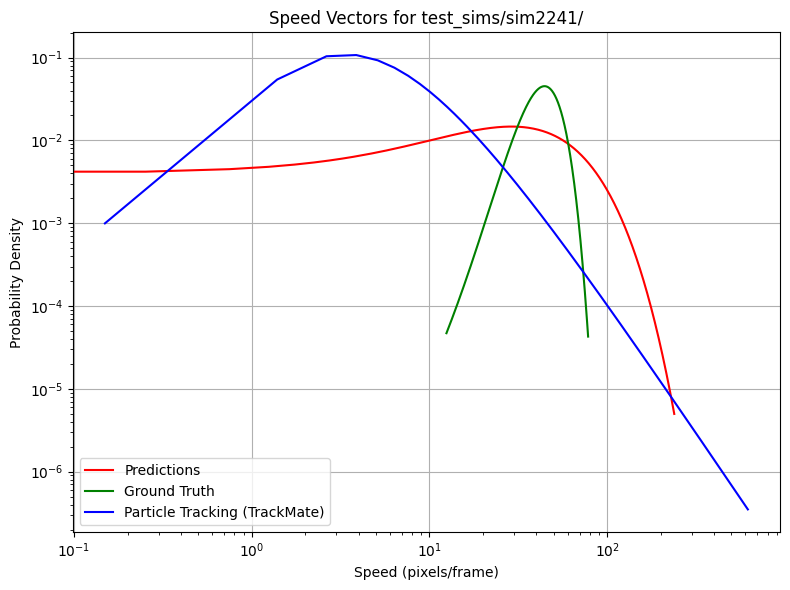

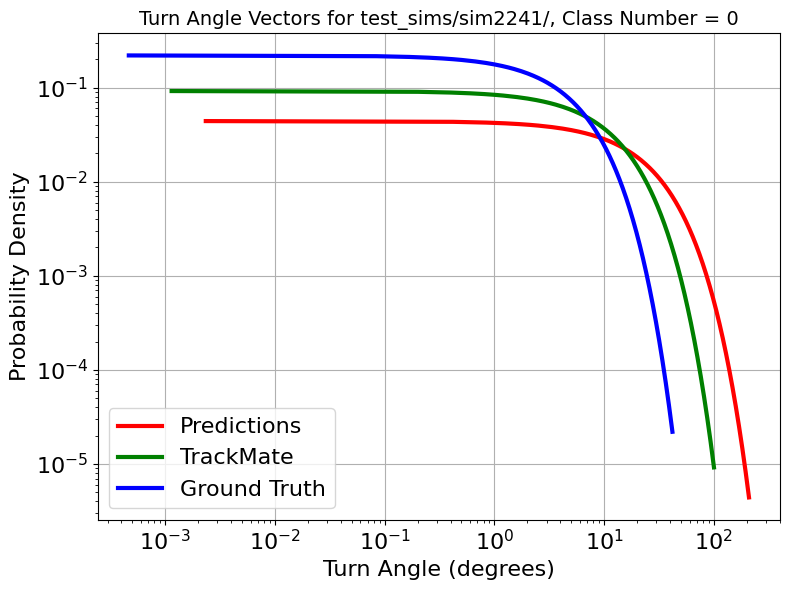

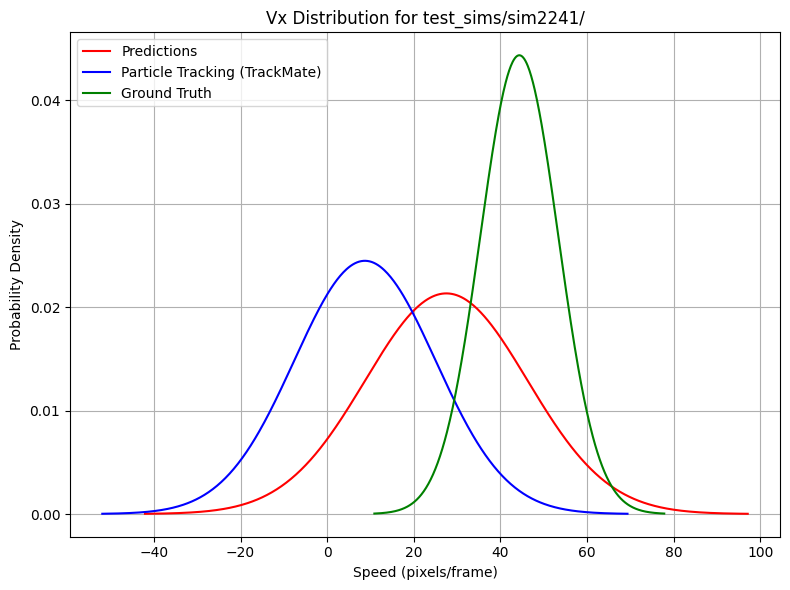

In [15]:
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gc
from torch.optim.lr_scheduler import StepLR
import torchvision as tv
import timm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from joblib import Parallel, delayed
from PIL import Image
from scipy.stats import exponweib,lognorm, beta, betaprime, norm, expon, wasserstein_distance
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import r2_score as r2
mean_out=0
import torchvision
#class_num=4
target_length=500
device='cuda'

def classifier(dataloader, constants, weights):
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            l=200
            self.fc2=nn.Conv2d(100, l, 1, stride=2)
            #self.m1 = nn.BatchNorm1d(1000)
            self.d1 = nn.Dropout(.2)
            self.fc1=nn.Conv2d(40, 100, 1, stride=2)
            #self.m2 = nn.BatchNorm1d(l)

            self.fc5 = nn.Conv2d(l, 5,1, stride=1)
            #self.m3 = nn.BatchNorm1d(100)
            self.fc6 = nn.Linear(312500,1000)
            self.d3 = nn.Dropout(.2)
            self.fc7 = nn.Linear(100,4)
            self.fc8 = nn.Linear(2000,1000)

        def forward(self, x):
            b = x.shape[0]
            x = x.squeeze()
            
            l=200
            x = F.relu(self.fc1(x))
            #x = self.m1(x)
            x = self.d1(x)
            x = F.relu(self.fc2(x))
            #x = self.m2(x)
            x = self.d2(x)

            x = F.relu(self.fc5(x))
            #x = self.m3(x)
            x = x.reshape(b, -1)
            #x = F.relu(self.fc4(x))
            x = (self.fc6(x))

            return x


    class Patch_model(nn.Module):
        def __init__(self):
            super(Patch_model, self).__init__()
            self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.5,num_classes=500,pretrained=True)
            self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.5,num_classes=500,pretrained=True)
            self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.5,num_classes=500,pretrained=True)
            self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.5,num_classes=500,pretrained=True)


            self.fc0=nn.Linear(2000,200)
            self.fc1=nn.Linear(200,4)
            #self.fc2=nn.Linear(1000,500)


        def forward(self, x):
            l2=224
            x1 = x[:,:,0:l2,0:l2]
            x2 = x[:,:,0:l2,l2:]
            x3 = x[:,:,l2:,0:l2]
            x4 = x[:,:,l2:,l2:]
            x1 = (self.m1(x1))
            x2 = (self.m2(x2))
            x3 = (self.m3(x3))
            x4 = (self.m4(x4))
            
            #x4 = F.gelu(self.m4(x4))
            x = torch.cat([x1,x2,x3,x4],dim=1)

            x = F.gelu(self.fc0(x))

            x = F.softmax(self.fc1(x),dim=1)


            return x#,x2,x3,x4\


    class Net7(nn.Module):
        def __init__(self):
            super(Net7, self).__init__()
            self.m1 = timm.create_model('regnetx_160.pycls_in1k', in_chans=40,drop_path_rate=0.6, num_classes=4,pretrained=True)

        def forward(self, x):
            x = F.softmax(self.m1(x),dim=1)
            return x


    class Net6(nn.Module):
        def __init__(self):
            super(Net6, self).__init__()
            self.m1 = timm.create_model('regnetx_064', in_chans=40,drop_path_rate=0.4, num_classes=4,pretrained=True)

        def forward(self, x):
            x = F.softmax(self.m1(x),dim=1)
            return x
        
    class Net5(nn.Module):
        def __init__(self):
            super(Net5, self).__init__()
            self.m1 = timm.create_model('densenet169', in_chans=40, num_classes=4,pretrained=True)

        def forward(self, x):
            x = F.softmax(self.m1(x),dim=1)
            return x

    class Net4(nn.Module):
        def __init__(self):
            super(Net4, self).__init__()
            self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.9,num_classes=4,pretrained=True)

        def forward(self, x):
            x = F.softmax(self.m1(x),dim=1)
            return x
            
    class Net2(nn.Module):
        def __init__(self):
            super(Net2, self).__init__()
            self.m1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0.6,num_classes=3,pretrained=True)

        def forward(self, x):
            x = F.softmax(self.m1(x),dim=1)
            return x
        
    class Net0(nn.Module):
        def __init__(self):
            super(Net0, self).__init__()
            self.m1 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0.8,num_classes=4,pretrained=True)

        def forward(self, x):
            x = F.softmax(self.m1(x),dim=1)
            return x

    class Net1(nn.Module):
        def __init__(self):
            super(Net1, self).__init__()
            self.m1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0.6,num_classes=4,pretrained=True)

        def forward(self, x):
            x = F.softmax(self.m1(x),dim=1)
            return x
        
    class Net3(nn.Module):
        def __init__(self):
            super(Net3, self).__init__()
            l=80

            self.fc1=nn.Linear(1000,l)
            self.d1 = nn.Dropout(.1)
            self.fc2=nn.Linear(1000,l)
            self.d2 = nn.Dropout(.1)
            self.fc3 = nn.Linear(40*l*l,1000)
            self.d3 = nn.Dropout(.1)
            self.fc4 = nn.Linear(1000,250)
            self.fc4_2 = nn.Linear(250,1000)


        def forward(self, x):
            b = x.shape[0]
            x = F.relu(self.fc1(x))
            x = self.d1(x)
            x = x.permute(0,1,3,2)
            x = F.relu(self.fc2(x))
            x = self.d2(x)
            x = torch.reshape(x, [b,-1])
            x = F.relu(self.fc3(x))
            x = self.d3(x)
            x = F.relu(self.fc4(x))
            #x = torch.reshape(x, [b,10000])
            x = (self.fc4_2(x))

            return x
            
    # model3 = timm.create_model('volo_d3_448', in_chans=30,drop_path_rate=.0, num_classes=4,pretrained=False)
    # model3.load_state_dict(torch.load('models/speed_classifier_volod1_448px_disp_all_5_04'))
    # model3.to(device).eval()

    # model0 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=4,pretrained=False)
    # model0.load_state_dict(torch.load('models/speed_classifier_volod1_384px_disp_all_5_04_v3'))
    # model0.to(device).eval()

    # model1 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=4,pretrained=False)
    # model1.load_state_dict(torch.load('models/speed_classifier_volod1_384px_disp_all_5_04_v2'))
    # model1.to(device).eval()

    # model2 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=4,pretrained=False)
    # model2.load_state_dict(torch.load('models/speed_classifier_volod1_384px_disp_all_5_04_v1'))
    # model2.to(device).eval()

    model4 = timm.create_model('volo_d4_448', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    model4.load_state_dict(torch.load('models/speed_classifier_5class_volod4_448px_disp_all_5_04'))
    model4.to(device).eval()

    model5 = timm.create_model('volo_d3_448', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    model5.load_state_dict(torch.load('models/speed_classifier_5class_volod3_448px_disp_all_5_05'))
    model5.to(device).eval()

    model6 = timm.create_model('volo_d3_448', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    model6.load_state_dict(torch.load('models/speed_classifier_5class_volod3_448px_disp_lbm_5_07'))
    model6.to(device).eval()

    model7 = timm.create_model('volo_d3_448', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    model7.load_state_dict(torch.load('models/speed_classifier_5class_volod3_448px_disp_homo_5_07'))
    model7.to(device).eval()

    #model8 = timm.create_model('volo_d3_448', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    #model8.load_state_dict(torch.load('models/speed_classifier_5class_volod3_448px_disp_lbm_5_07_v2'))
    #model8.to(device).eval()

    #model9 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    #model9.load_state_dict(torch.load('models/speed_classifier_5class_volod1_384px_disp_all_5_06'))
    #model9.to(device).eval()

    model10 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    model10.load_state_dict(torch.load('models/speed_classifier_5class_volod1_384px_disp_all_5_06_v2'))
    model10.to(device).eval()

    model11 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    model11.load_state_dict(torch.load('models/speed_classifier_5class_volod1_384px_disp_all_5_06_v3'))
    model11.to(device).eval()

    #model12 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    #model12.load_state_dict(torch.load('models/speed_classifier_5class_volod1_384px_disp_all_5_06_v4'))
    #model12.to(device).eval()

    model13 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    model13.load_state_dict(torch.load('models/speed_classifier_5class_volod1_384px_disp_all_5_06_v5'))
    model13.to(device).eval()

    model14 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    model14.load_state_dict(torch.load('models/speed_classifier_5class_volod1_384px_disp_all_5_06_v6'))
    model14.to(device).eval()
    
    model15 = timm.create_model('efficientvit_b1', in_chans=30, num_classes=5,pretrained=False)
    model15.load_state_dict(torch.load('models/speed_classifier_efficientvit_b1_mse_448px_all_5_08'))
    model15.to(device).eval()
    
    model16 = timm.create_model('pvt_v2_b1', in_chans=30,num_classes=5,pretrained=False)
    model16.load_state_dict(torch.load('models/speed_classifier_pvt_v2_b1_mse_448px_all_5_08'))
    model16.to(device).eval()
    
    model17 = timm.create_model('regnetx_032', in_chans=30,num_classes=5,pretrained=False)
    model17.load_state_dict(torch.load('models/speed_classifier_regnetx_032_mse_448px_all_5_08'))
    model17.to(device).eval()
    
    model18 = timm.create_model('twins_svt_small', in_chans=30, num_classes=5,pretrained=False)
    model18.load_state_dict(torch.load('models/speed_classifier_twins_svt_small_mse_448px_all_5_09'))
    model18.to(device).eval()
    
    model19 = timm.create_model('davit_base', in_chans=30, num_classes=5,pretrained=False)
    model19.load_state_dict(torch.load('models/speed_classifier_davit_base_small_mse_448px_all_5_09'))
    model19.to(device).eval()
    
    model20 = timm.create_model('davit_base', in_chans=30, num_classes=5,pretrained=False)
    model20.load_state_dict(torch.load('models/speed_classifier_davit_base_small_mse_448px_all_5_09_v2'))
    model20.to(device).eval()
    
    model21 = timm.create_model('regnetx_064', in_chans=30, num_classes=3,pretrained=False)
    model21.load_state_dict(torch.load('models/speed_classifier_regnetx064_mse_448px_all_5_12'))
    model21.to(device).eval()
    
    model22 = timm.create_model('regnetx_064', in_chans=30, num_classes=3,pretrained=False)
    model22.load_state_dict(torch.load('models/speed_classifier_regnetx064_mse_448px_all_5_12_v2'))
    model22.to(device).eval()
    
    model23 = timm.create_model('regnetx_064', in_chans=30, num_classes=3,pretrained=False)
    model23.load_state_dict(torch.load('models/speed_classifier_regnetx064_mse_448px_all_5_12_v3'))
    model23.to(device).eval()
    
    model24 = timm.create_model('regnetx_160', in_chans=30, num_classes=3,pretrained=False)
    model24.load_state_dict(torch.load('models/speed_classifier_regnetx160_mse_448px_all_5_12'))
    model24.to(device).eval()
    
    model25 = timm.create_model('pvt_v2_b0', in_chans=30, num_classes=3,pretrained=False)
    model25.load_state_dict(torch.load('models/speed_classifier_pvt_v2_b0_mse_384px_all_5_12'))
    model25.to(device).eval()
    
    model26 = timm.create_model('pvt_v2_b1', in_chans=30, num_classes=3,pretrained=False)
    model26.load_state_dict(torch.load('models/speed_classifier_pvt_v2_b1_mse_384px_all_5_12'))
    model26.to(device).eval()
    
    model27 = timm.create_model('pvt_v2_b2', in_chans=30, num_classes=3,pretrained=False)
    model27.load_state_dict(torch.load('models/speed_classifier_pvt_v2_b2_mse_384px_all_5_12'))
    model27.to(device).eval()
    
    
    #outputs3=[]
    
    outputs1=[]
    count=0
    with torch.no_grad():
        for x in test_dataloader2:
            if torch.mean(x)>.5:
                x = 1-x
            #x=1-x
            #x1 = tv.transforms.functional.resize(x, 448)
            x2 = tv.transforms.functional.resize(x, 384)
            #x3 = tv.transforms.functional.resize(x, 224)
            # out0 =F.softmax((model0((x2).to(device)).detach().cpu()),1).numpy()
            # out1 =F.softmax((model1((x2).to(device)).detach().cpu()),1).numpy()
            # out2 =F.softmax((model2((x2).to(device)).detach().cpu()),1).numpy()
            # out3 =F.softmax((model3((x).to(device)).detach().cpu()),1).numpy()


            #out4 =F.softmax((model4((x).to(device)).detach().cpu()),1).numpy()
            out5 =F.softmax((model5((x).to(device)).detach().cpu()),1).numpy()
            out6 =F.softmax((model6((x).to(device)).detach().cpu()),1).numpy() # class 4, close to 1
            out7 =F.softmax((model7((1-x).to(device)).detach().cpu()),1).numpy()
            #out8 =F.softmax((model8((x).to(device)).detach().cpu()),1).numpy()
            #out9 =F.softmax((model9((x2).to(device)).detach().cpu()),1).numpy()
            out10 =F.softmax((model10((x2).to(device)).detach().cpu()),1).numpy()
            out11 =F.softmax((model11((x2).to(device)).detach().cpu()),1).numpy()
            #out12 =F.softmax((model12((x2).to(device)).detach().cpu()),1).numpy()
            out13 =F.softmax((model13((x2).to(device)).detach().cpu()),1).numpy()
            out13[:,3] = out13[:,3]*.1
            out14 =F.softmax((model15((x2).to(device)).detach().cpu()),1).numpy() #class 2 close to cslaa 3
            #out15 =F.softmax((model15((x).to(device)).detach().cpu()),1).numpy() # class 4
            out16 =F.softmax((model16((x).to(device)).detach().cpu()),1).numpy() #class 2 .25
            out17 =F.softmax((model17((x).to(device)).detach().cpu()),1).numpy() # class 2
            out18 =F.softmax((model18((x).to(device)).detach().cpu()),1).numpy() # class 2
            out19 =F.softmax((model19((x).to(device)).detach().cpu()),1).numpy() # class 3
            out20 =F.softmax((model20((x).to(device)).detach().cpu()),1).numpy() # class 2, .22
            out21 =F.softmax((model21((x).to(device)).detach().cpu()),1).numpy()
            out21z = np.zeros([len(out21), 5])
            out21z[:,2:5] = out21
            out22 =F.softmax((model22((x).to(device)).detach().cpu()),1).numpy()
            out22z = np.zeros([len(out22), 5])
            out22z[:,2:5] = out22
            out23 =F.softmax((model23((x).to(device)).detach().cpu()),1).numpy()
            out23z = np.zeros([len(out23), 5])
            out23z[:,2:5] = out23
            out24 =F.softmax((model24((x).to(device)).detach().cpu()),1).numpy()
            out24z = np.zeros([len(out24), 5])
            out24z[:,2:5] = out24
            out25 =F.softmax((model25((x2).to(device)).detach().cpu()),1).numpy()
            out25z = np.zeros([len(out25), 5])
            out25z[:,2:5] = out25
            out26 =F.softmax((model26((x2).to(device)).detach().cpu()),1).numpy()
            out26z = np.zeros([len(out26), 5])
            out26z[:,2:5] = out26
            out27 =F.softmax((model27((x2).to(device)).detach().cpu()),1).numpy()
            out27z = np.zeros([len(out27), 5])
            out27z[:,2:5] = out27
            
            #out=(out11*5+out14*.5+out16*28.5+out17*22.6+out19*3+out5*17.5+out10*3.4+out7*.6+out13*32.2+out6*2+out18*1.5)/constants[0]#(out16*4+out17*2+out14*.5)/6.5#(out0*2+out3*40+out5*2+out7*2+out10+out13)/48
            ensemble_expression = "+".join(f"out{weight[0]}*{weight[1]}" for weight in weights)
            out = eval(ensemble_expression) / constants[0]
            out[:,0] = out[:,0]+constants[1]
            out[:,1] = out[:,1]+constants[2]
            out[:,2] = out[:,2]+constants[3]
            out[:,3] = out[:,3]+constants[4]
            out[:,4] = out[:,4]+constants[5]
            out = out/1.25

            outputs1.append(out)
            count=count+1

    # print
    return outputs1


class TestDataset2(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]

        return image.float()
        
def calculate_velocity( y_positions):
    # Calculate velocities
    y_velocities = (y_positions[1:] - y_positions[:-1]) 
            
    return  y_velocities
        
def calculate_angles(x_arr, y_arr):
    traj_stats=[]
    for n in range(x_arr.shape[1]):
        x_diff = np.diff(x_arr[:,n])
        y_diff = np.diff(y_arr[:,n])
        angles=np.zeros((len(x_diff),1))
        for i in range(len(x_diff)-1):
            theta_1=np.arctan(y_diff[i]/x_diff[i])
            theta_2=np.arctan(y_diff[i+1]/x_diff[i+1])
            angles[i]=(theta_2-theta_1)*(180/np.pi)
    
        traj_stats.append([n, angles])
    angle_array=[]
    vel_array=[]
    for i in range(len(traj_stats)):
        section1=traj_stats[i][1]
        section1=np.reshape(section1,(len(section1),))
        angle_array=np.hstack([section1,angle_array])
    
    angle_array
    angle_array=np.abs(angle_array[~np.isnan(angle_array)])
    angle_array = angle_array[angle_array>0]

    return angle_array

def interpolate_vectors(vector, target_length):
    current_length = len(vector)
    # Create a new x-axis with the desired length
    new_x = np.linspace(0, current_length - 1, target_length)
    # Create the old x-axis based on the current length
    old_x = np.arange(current_length)
    # Perform linear interpolation
    interpolated_vector = np.interp(new_x, old_x, vector)
    return interpolated_vector
    
def process_file(file_path, l):
    image = np.array(Image.open(file_path))
    resized_image = cv2.resize(image, [l, l])
    resized_image = (resized_image - np.min(resized_image)) / (np.max(resized_image) - np.min(resized_image))
    resized_image = np.nan_to_num(resized_image,1)
    return resized_image

def parallel_image_processing(full_files, l):
    num_files = len(full_files)
    images = np.zeros([num_files, l, l])
    results = Parallel(n_jobs=16)(delayed(process_file)(file_path, l) for file_path in full_files)
    for i, resized_image in enumerate(results):
        images[i] = resized_image
    return images
    
def calculate_angles_test(x_arr, y_arr):
    traj_stats=[]
    x_diff = np.diff(x_arr)
    y_diff = np.diff(y_arr)
    #print(x_diff.shape)
    angles=np.zeros((len(x_diff),1))
    for i in range(len(x_diff)-1):
        theta_1=np.arctan(y_diff[i]/x_diff[i])
        theta_2=np.arctan(y_diff[i+1]/x_diff[i+1])
        angles[i]=(theta_2-theta_1)*(180/np.pi)
        traj_stats.append([angles])
    
    angles=np.abs(angles[~np.isnan(angles)])
    angles = interpolate_vectors(np.sort(angles), target_length)
    angles=angles[angles!=0]
    #angles[angles==0]=0.1
    return angles
    
# Custom sorting key function
def sort_key2(item):
    if 'het' in item:
        return (0, int(item.split('_')[0]))
    elif 'brown' in item:
        return (1, int(item[6:-10]))
    elif 'test' in item:
        return (3, int(item[7:-4])) # Extract the numeric part for files with '_brown'
    else:
        return (2, int(item[6:-4]))  # Extract the numeric part for files without '_brown'


# sim_base = 'C:/Users/marcb/OneDrive/Desktop/het_trajectories/sim_trajectories/sim/'
# tmate_base = 'C:/Users/marcb/OneDrive/Desktop/het_trajectories/sim_trajectories/tmate/'

sim_directory='../sim_trajectories/sim/'
tmate_directory='../sim_trajectories/tmate/'
sim_filenames = os.listdir(sim_directory)
tmate_filenames = os.listdir(tmate_directory)

print(sim_filenames)
print(tmate_filenames)

gc.collect()
# Sort the list using the custom key
sorted_file_dir = sorted(sim_filenames, key=sort_key2)
# tmate_directory = sorted(tmate_filenames, key=sort_key2)
# Split the sorted list into 'yc_' and 'xc_' files
yc_files = [f for f in sorted_file_dir if 'yc' in f]
xc_files = [f for f in sorted_file_dir if 'xc' in f]

# Create a list of lists with corresponding 'yc_' and 'xc_' files
sorted_file_pairs = [[yc, xc] for yc, xc in zip(yc_files, xc_files)]

#sorted_file_pairs=sorted_file_pairs[1110:]
print(sorted_file_pairs)
# f_idx = 9
# print(filenames[f_idx])

directories = [
'test_sims_het/1000part_16xspeed_heterogeneous/','test_sims_het/1000part_32xspeed_heterogeneous/',
'test_sims_het/1000part_4xspeed_heterogeneous/','test_sims_het/1000part_heterogeneous/',
'test_sims_het/2000part_16xspeed_heterogeneous/','test_sims_het/2000part_32xspeed_heterogeneous/', ## Group 1
'test_sims_het/2000part_4xspeed_heterogeneous/','test_sims_het/2000part_heterogeneous/',
'test_sims_het/500part_16xspeed_heterogeneous/','test_sims_het/500part_32xspeed_heterogeneous/',
'test_sims_het/500part_4xspeed_heterogeneous/','test_sims_het/500part_heterogeneous/',
'test_sims/sim111_brown/', 'test_sims/sim112_brown/',
'test_sims/sim113_brown/','test_sims/sim114_brown/',  # Group 2 12,13,14,15,16,17,18
'test_sims/sim115_brown/','test_sims/sim119_brown/','test_sims/sim120_brown/',
'test_sims/sim2201/', 'test_sims/sim2210/', 'test_sims/sim2215/',
'test_sims/sim2220/','test_sims/sim2230/','test_sims/sim2235/','test_sims/sim2240/', # Group 3
'test_sims/sim2241/','test_sims/sim2242/','test_sims/sim2243/','test_sims/sim2244/', #Group 4 25,26,27,28
'test_sims/sim2251/','test_sims/sim2252/','test_sims/sim2253/',
'test_sims/sim2254/','test_sims/sim2255/','test_sims/sim2256/',
'test_sims/sim2257/','test_sims/sim2258/','test_sims/sim2259/','test_sims/sim2260/', # Group 5
'test_sims/test1/','test_sims/test2/','test_sims/test5/','test_sims/test8/' #Group 6
]

#Speed
file_error=[]
file_mse=[]
final_out=[]
final_true=[]
speed_w1=[]
speed_w2=[]
file_mse_pt=[]
final_pt=[]
file_error_pt=[]

#Angle
file_error_ang=[]
file_mse_ang=[]
final_out_ang=[]
final_true_ang=[]
ang_w1=[]
ang_w2=[]
file_mse_pt_ang=[]
file_error_pt_ang=[]
final_pt_ang=[]
#Vx
file_error_vx=[]
file_error_pt_vx=[]
file_mse_vx=[]
final_out_vx=[]
final_true_vx=[]
vx_w1=[]
vx_w2=[]
file_mse_pt_vx=[]
final_pt_vx=[]

#Vx
file_error_vy=[]
file_error_pt_vy=[]
file_mse_vy=[]
final_out_vy=[]
final_out_pt_vy=[]
final_true_vy=[]
vy_w1=[]
vy_w2=[]
file_mse_pt_vy=[]
final_pt_vy=[]
#directionality
file_error_direction=[]
file_mse_direction=[]
final_out_direction=[]
final_true_direction=[]
direction_r2=[]

final_true_direction=[]
final_out_direction=[]
final_error_direction=[]
final_error_pt_direction=[]
final_pt_direction=[]

for f_idx in range(26,len(directories)):
    if (12<=f_idx<=18):
        brownian = 1
    else:
        brownian=0
    print('Brownian: ',brownian)
    print(f_idx)
    print(len(tmate_filenames), len(directories))
    base=directories[f_idx]
    
    print(base)
    #base='shew_noflow/8040_20x_002_frames/'
    files=os.listdir(base)
    print(files[0])
    #5 for noflow
    #3 ofr flow
    full_files=[]
    if 'noflow' in base:
        sorted_frames = sorted(files, key=lambda x: int(x[5:-4]))
    elif 'homo' in base:
        sorted_frames = sorted(files, key=lambda x: int(x[4:-4]))
    elif 'test_sims_het' in base:
        sorted_frames = sorted(files, key=lambda x: int(x[4:-4]))
    elif 'test_sims' in base:
        sorted_frames = sorted(files, key=lambda x: int(x[4:-4]))
    elif 'frame' in files[0]:
        sorted_frames = sorted(files, key=lambda x: int(x[5:-4]))
    elif 'brown' in base:
        sorted_frames = sorted(files, key=lambda x: int(x[4:-4]))
    else:
        sorted_frames = sorted(files, key=lambda x: int(x[3:-4]))

    for i in range(len(sorted_frames)):
        file = base+sorted_frames[i]
        full_files.append(file)
        
    

    l1=448
    l2 = 384
    l3 = 224


    images = parallel_image_processing(full_files,l1)
    images2 = parallel_image_processing(full_files,l1)

    #plt.figure(figsize=(10,10),dpi=500)
    #plt.imshow(images1[-1])

    if (images.shape[0]-30)%40==0:
        images = images[30:,:,:].reshape([(images.shape[0]-30)//40,40,448,448])
    elif (images.shape[0]-20)%40==0:
        images = images[20:,:,:].reshape([(images.shape[0]-20)//40,40,448,448])
    elif (images.shape[0]-10)%40==0:
        images = images[10:,:,:].reshape([(images.shape[0]-10)//40,40,448,448])
    else:
        images = images.reshape([(images.shape[0])//40,40,448,448])
        
    images = torch.tensor(images)

    dataset_test = TestDataset2(images)#  xtorch_test, distr_torch_test, scales_test2)
    if len(images)<4:
        batch_size = 1
    else:
        batch_size = 4
    test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=0)

    if (images2.shape[0]-20)%30==0:
        images2 = images2[20:,:,:].reshape([(images2.shape[0]-20)//30,30,448,448])
    elif (images2.shape[0]-10)%30==0:
        images2 = images2[10:,:,:].reshape([(images2.shape[0]-10)//30,30,448,448])
    else:
        images2 = images2.reshape([(images2.shape[0])//30,30,448,448])

    images2 = torch.tensor(images2)

    dataset_test = TestDataset2(images2)#  xtorch_test, distr_torch_test, scales_test2)
    #batch_size = 2
    test_dataloader2 = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=0)

    # x = next(iter(test_dataloader))
    # print(x.shape)
    # #plt.imshow(x[0,29,:,:])

    
        
    constants = [93,-.1,.1,.169,.126,-.066]
    weights = [['11',5],['14',.5],['16',28.5],['17',22.6],['19',3],['5',17.5],['10',3.4],['7',.6],['13',32.2],['6',2],['18',1.5]]
    outputs1 = classifier(test_dataloader2,constants,weights)
    mean_out = np.mean(np.vstack(outputs1),0)
    class_num = np.argmax(mean_out)
    print('Class Number: ',class_num)
    #print(mean_out)
    # #class_num=1


    class Patch_model2(nn.Module):
        def __init__(self):
            super(Patch_model2, self).__init__()
            self.m0 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0.0,num_classes=2000,pretrained=True)
            self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
            self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
            self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
            self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)

            self.fc1=nn.Linear(2000, 1000)
            self.fc2=nn.Linear(1000,500)


        def forward(self, x):
            l2=224
            x1 = x[:,:,0:l2,0:l2]
            x2 = x[:,:,0:l2,l2:]
            x3 = x[:,:,l2:,0:l2]
            x4 = x[:,:,l2:,l2:]
            #torch.cuda.empty_cache()
            #gc.collect()
            x = F.gelu(self.m0(x))
            x1 = F.gelu(self.m1(x1))
            x2 = F.gelu(self.m2(x2))
            x3 = F.gelu(self.m3(x3))
            x4 = F.gelu(self.m4(x4))
            x0 = torch.cat([x1,x2,x3,x4],dim=1)
            del x1,x2, x3, x4
            x = x*x0
            x = F.gelu(self.fc1(x))
            x = self.fc2(x)
            return x#,x2,x3,x4

    class Patch_model3(nn.Module):
        def __init__(self):
            super(Patch_model3, self).__init__()
            self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
            self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
            self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
            self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)

            self.fc1=nn.Linear(2000, 1000)
            self.fc2=nn.Linear(1000,500)


        def forward(self, x):
            l2=224
            x1 = x[:,:,0:l2,0:l2]
            x2 = x[:,:,0:l2,l2:]
            x3 = x[:,:,l2:,0:l2]
            x4 = x[:,:,l2:,l2:]
            #torch.cuda.empty_cache()
            #gc.collect()
            x1 = F.gelu(self.m1(x1))
            x2 = F.gelu(self.m2(x2))
            x3 = F.gelu(self.m3(x3))
            x4 = F.gelu(self.m4(x4))
            x = torch.cat([x1,x2,x3,x4],dim=1)
            del x1,x2, x3, x4
            x = F.gelu(self.fc1(x))
            x = self.fc2(x)
            return x#,x2,x3,x4

    class Patch_model4(nn.Module):
        def __init__(self):
            super(Patch_model4, self).__init__()
            self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
            self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
            self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
            self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)

            self.fc0=nn.Linear(2000, 500)
            #self.fc2=nn.Linear(1000,500)


        def forward(self, x):
            l2=224
            x1 = x[:,:,0:l2,0:l2]
            x2 = x[:,:,0:l2,l2:]
            x3 = x[:,:,l2:,0:l2]
            x4 = x[:,:,l2:,l2:]
            #torch.cuda.empty_cache()
            #gc.collect()
            x1 = F.gelu(self.m1(x1))
            x2 = F.gelu(self.m2(x2))
            x3 = F.gelu(self.m3(x3))
            x4 = F.gelu(self.m4(x4))
            x = torch.cat([x1,x2,x3,x4],dim=1)
            del x1,x2, x3, x4
            #x = F.gelu(self.fc1(x))
            x = self.fc0(x)
            return x#,x2,x3,x4


    class Patch_model(nn.Module):
        def __init__(self):
            super(Patch_model, self).__init__()
            self.m0 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0.0,num_classes=2000,pretrained=True)
            self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
            self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
            self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
            self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)

            self.fc1=nn.Linear(4000, 1000)
            self.fc2=nn.Linear(1000,500)


        def forward(self, x):
            l2=224
            x1 = x[:,:,0:l2,0:l2]
            x2 = x[:,:,0:l2,l2:]
            x3 = x[:,:,l2:,0:l2]
            x4 = x[:,:,l2:,l2:]
            #torch.cuda.empty_cache()
            #gc.collect()
            x = F.gelu(self.m0(x))
            x1 = F.gelu(self.m1(x1))
            x2 = F.gelu(self.m2(x2))
            x3 = F.gelu(self.m3(x3))
            x4 = F.gelu(self.m4(x4))
            x0 = torch.cat([x1,x2,x3,x4],dim=1)
            del x1,x2, x3, x4
            x = torch.cat([x,x0],dim=1)#x*x0
            x = F.gelu(self.fc1(x))
            x = self.fc2(x)
            return x#,x2,x3,x4

    class Net0(nn.Module):
        def __init__(self):
            super(Net0, self).__init__()
            self.m1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=True)



        def forward(self, x):
            x = self.m1(x)


            return x#,x2,x3,x4

    class Net2(nn.Module):
        def __init__(self):
            super(Net2, self).__init__()
            self.m1 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0,num_classes=1000,pretrained=True)



        def forward(self, x):
            x = self.m1(x)


            return x#,x2,x3,x4

    class Net3(nn.Module):
        def __init__(self):
            super(Net3, self).__init__()
            self.m1 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=True)



        def forward(self, x):
            x = self.m1(x)


            return x#,x2,x3,x4
            
    class Patch_model5(nn.Module):
        def __init__(self):
            super(Patch_model5, self).__init__()
            self.m1 = timm.create_model('volo_d1_224', in_chans=30, drop_path_rate=0.4,num_classes=500,pretrained=True)
            self.m2 = timm.create_model('volo_d1_224', in_chans=30, drop_path_rate=0.4,num_classes=500,pretrained=True)
            self.m3 = timm.create_model('volo_d1_224', in_chans=30, drop_path_rate=0.4,num_classes=500,pretrained=True)
            self.m4 = timm.create_model('volo_d1_224', in_chans=30, drop_path_rate=0.4,num_classes=500,pretrained=True)
            self.fc0=nn.Linear(2000,500)

        def forward(self, x):
            l2=224
            x1 = x[:,:,0:l2,0:l2]
            x2 = x[:,:,0:l2,l2:]
            x3 = x[:,:,l2:,0:l2]
            x4 = x[:,:,l2:,l2:]

            x1 = F.relu(self.m1(x1))
            x2 = F.relu(self.m2(x2))
            x3 = F.relu(self.m3(x3))
            x4 = F.relu(self.m4(x4))

            x = torch.cat([x1,x2,x3,x4],dim=1)
            x = self.fc0(x)
            return x#,x2,x3,x4



    model6 = Patch_model3()
    model6.load_state_dict(torch.load('models/speed_model_volod1_patch_4x224px_dispBrown_4_21'))
    model6.to(device).eval()

    # model7 = Patch_model()
    # model7.load_state_dict(torch.load('models/speed_model_Volo224-448_dispBrown_patch_v3'))
    # model7.to(device).eval()

    model8 =Patch_model2()
    model8.load_state_dict(torch.load('models/speed_model_Volo224-448_dispBrown_patch_v1'))
    model8.to(device).eval()

    #model17 =Patch_model4()
    #model17.load_state_dict(torch.load('models/speed_model_patch448px_disp300_4_23_v2'))
    #model17.to(device).eval()

    # # model5 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=.0,num_classes=1000,pretrained=False)
    # # model5.load_state_dict(torch.load('models/speed_model_volod3_448px_dispBrown_4_22_v2'))
    # # model5.to(device).eval()

    model1 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=.0,num_classes=1000,pretrained=False)
    model1.load_state_dict(torch.load('models/speed_model_volod3_448px_dispBrown_4_22'))
    model1.to(device).eval()

    model2 = timm.create_model('twins_svt_small', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    model2.load_state_dict(torch.load('models/speed_model_TwinsSvtSmall_500px_opposite_dispBrown_4_21'))
    model2.to(device).eval()

    model3 = timm.create_model('volo_d2_224', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    model3.load_state_dict(torch.load('models/speed_model_volod1_224px_disp_4_21'))
    model3.to(device).eval()

    model4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    model4.load_state_dict(torch.load('models/speed_model_volod1_224px_dispBrown_4_21'))
    model4.to(device).eval()

    model18 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    model18.load_state_dict(torch.load('models/speed_model_384px_disp300_4_23'))
    model18.to(device).eval()

    model19 = timm.create_model('volo_d2_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    model19.load_state_dict(torch.load('models/speed_model_384px_disp300_4_23_v2'))
    model19.to(device).eval()

    # model20 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # model20.load_state_dict(torch.load('models/speed_model_volod3_448px_disp300_4_25'))
    # model20.to(device).eval()

    # model9 = Net0()
    # model9.load_state_dict(torch.load('models/speed_model_Volo384_dispBrown_full'))
    # model9.to(device).eval()

    # # #model10 = Net0()
    # # #model10.load_state_dict(torch.load('models/speed_model_Volo384_dispBrown_fullv2'))
    # # #model10.to(device).eval()

    model11 = Net0()
    model11.load_state_dict(torch.load('models/speed_model_Volo384_dispBrown_fullv3'))
    model11.to(device).eval()

    # # model12 = Net0()
    # # model12.load_state_dict(torch.load('models/speed_model_Volo384_dispBrown_full_new_v1'))
    # # model12.to(device).eval()

    # model13 = Net2()
    # model13.load_state_dict(torch.load('models/speed_model_Volo448_dispBrown'))
    # model13.to(device).eval()

    # model14 = Net3()
    # model14.load_state_dict(torch.load('models/speed_model_Volo448_dispBrown_full'))
    # model14.to(device).eval()

    # model15 = timm.create_model('swinv2_small_window16_256', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # model15.load_state_dict(torch.load('models/speed_model_patch_swin_256px_dispBrown_4_23'))
    # model15.to(device).eval()

    # # # #model16 = timm.create_model('botnet26t_256', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # # # #model16.load_state_dict(torch.load('models/speed_model_ByobNet26_256px_dispBrown_4_23'))
    # # # #model16.to(device).eval()

    # # model21 = timm.create_model('volo_d1_384', in_chans=35, drop_path_rate=.0,num_classes=500,pretrained=False)
    # # model21.load_state_dict(torch.load('models/speed_model_volod1_384px_disp_lbm_5_04_max216_7189'))
    # # model21.to(device).eval()

    # # model22 = timm.create_model('volo_d1_384', in_chans=30, drop_path_rate=.0,num_classes=500,pretrained=False)
    # # model22.load_state_dict(torch.load('models/speed_model_volod1_384px_disp_lbm_5_04_v3'))
    # # model22.to(device).eval()

    # # model23 = timm.create_model('volo_d1_224', in_chans=30, drop_path_rate=.0,num_classes=500,pretrained=False)
    # # model23.load_state_dict(torch.load('models/speed_model_volod1_384px_disp_all_5_04_v4'))
    # # model23.to(device).eval()

    # model24 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # model24.load_state_dict(torch.load('models/speed_model_volod2_384px_disp_lbm_5_04_max122_8786_v2'))
    # model24.to(device).eval()
    
    model25 = timm.create_model('volo_d3_448', in_chans=30, drop_path_rate=.0,num_classes=500,pretrained=False)
    model25.load_state_dict(torch.load('models/speed_model_volod3_448px_disp_lbm_5_07'))
    model25.to(device).eval()

    # model26 = timm.create_model('volo_d3_448', in_chans=30, drop_path_rate=.0,num_classes=500,pretrained=False)
    # model26.load_state_dict(torch.load('models/speed_model_volod3_448px_disp_lbm_5_07_v2'))
    # model26.to(device).eval()
    
    model27 = Patch_model5()
    model27.load_state_dict(torch.load('models/speed_model_patch_448px_disp_lbm_5_07_v4'))
    model27.to(device).eval()
    
    # model28 = Patch_model5()
    # model28.load_state_dict(torch.load('models/speed_model_patch_448px_disp_lbm_5_07_v3'))
    # model28.to(device).eval()
    
    # model29 = Patch_model5()
    # model29.load_state_dict(torch.load('models/speed_model_patch_448px_disp_lbm_5_07_v2'))
    # model29.to(device).eval()
    
    # model30 = Patch_model5()
    # model30.load_state_dict(torch.load('models/speed_model_patch_448px_disp_lbm_5_07'))
    # model30.to(device).eval()
    

    outputs=[]
    outputs2=[]
    torch.cuda.empty_cache()
    gc.collect()

        

    max24 = 140.0
    max21 = 216.7189

    with torch.no_grad():
        for x in test_dataloader:
            if torch.mean(x)<.5:
                x = 1-x
            # # x1 = tv.transforms.functional.resize(x, 448)
            # x2 = tv.transforms.functional.resize(x, 224)
            x3 = tv.transforms.functional.resize(x, 384)
            x4 = tv.transforms.functional.resize(x, 256)
            # # out1_1000 = (model1((1-x1).to(device)).detach().cpu().numpy())
            # # out1 = np.zeros([batch_size,500])
            # # for i in range(len(out1)):
            # #    out1[i,:] = interpolate_vectors(out1_1000[i,:],500)
            # out2 = np.sort(model2((x).to(device)).detach().cpu().numpy())
            out11 = np.sort(model11((x3).to(device)).detach().cpu().numpy())
            # # #out10 =(model10((x3).to(device)).detach().cpu().numpy())
            # out9 = np.sort(model9((x3).to(device)).detach().cpu().numpy())
            out8 = np.sort(model8((x).to(device)).detach().cpu().numpy())
            # out7 =np.sort(model7((x).to(device)).detach().cpu().numpy())
            out6 = np.sort(model6((1-x).to(device)).detach().cpu().numpy())
            # # #out3 = np.sort(model3((1-x2).to(device)).detach().cpu().numpy())
            # out4 = np.sort(model4((x2).to(device)).detach().cpu().numpy())
            # # #out5 = np.sort(model5((x1).to(device)).detach().cpu().numpy())
            # # #out12 = np.sort(model12((x3).to(device)).detach().cpu().numpy())
            # # #out0 = (model((1-x1).to(device)).detach().cpu().numpy())
            # out13_1000 = np.sort(model13((x).to(device)).detach().cpu().numpy())
            # out13 = np.zeros([batch_size,500])
            # for i in range(len(out13)-1):
            #      out13[i,:] = interpolate_vectors(out13_1000[i,:],500)
            # out14 = np.sort(model14((x).to(device)).detach().cpu().numpy())
            # out15 = np.sort(model15((1-x4).to(device)).detach().cpu().numpy())
            # # # #out16 = (model16((1-x4).to(device)).detach().cpu().numpy())
            #out17 = np.sort(model17((1-x).to(device)).detach().cpu().numpy())
            # out18 = np.sort(model18((x3).to(device)).detach().cpu().numpy())
            out19 = np.sort(model19((1-x3).to(device)).detach().cpu().numpy())
            # out20 = np.sort(model20((1-x).to(device)).detach().cpu().numpy())
            # # #out21 = np.sort(model21((x3[:,5:,:,:]).to(device)).detach().cpu().numpy())*max21
            # # #out22 = np.sort(model22((1-x3[:,5:35,:,:]).to(device)).detach().cpu().numpy())
            
            # # #out23 = np.sort(model23((1-x2[:,5:35,:,:]).to(device)).detach().cpu().numpy())
            out25 = np.sort(model25((1-x[:,5:35,:,:]).to(device)).detach().cpu().numpy())
            # out26 = np.sort(model26((x[:,5:35,:,:]).to(device)).detach().cpu().numpy())
            # out26_2 = np.sort(model26((1-x[:,5:35,:,:]).to(device)).detach().cpu().numpy())
            out27 = np.sort(model27((1-x[:,5:35,:,:]).to(device)).detach().cpu().numpy())
            # out28 = np.sort(model28((1-x[:,5:35,:,:]).to(device)).detach().cpu().numpy())
            # # # out29 = np.sort(model29((1-x[:,5:35,:,:]).to(device)).detach().cpu().numpy())
            # # #out30 = np.sort(model30((1-x[:,5:35,:,:]).to(device)).detach().cpu().numpy())
            # out00 = (out27*20+out25*26+out28*14+out19*3+out6*3+out20*3+out8*3+out9*3+out11*3+out15)/79

            # out24 = np.sort(model24((1-x3).to(device)).detach().cpu().numpy())*max24
            

            # out14_2 = np.sort(model14((1-x).to(device)).detach().cpu().numpy())
            # #out15_2 = np.sort(model15((x4).to(device)).detach().cpu().numpy())
            # #out16 = (model16((1-x4).to(device)).detach().cpu().numpy())
            # out17_2 = np.sort(model17((x).to(device)).detach().cpu().numpy())
            # #out18_2 = np.sort(model18((1-x3).to(device)).detach().cpu().numpy())
            # out19_2 = np.sort(model19((x3).to(device)).detach().cpu().numpy())
            # #out20_2 = np.sort(model20((x).to(device)).detach().cpu().numpy())
            if class_num==4:
                out = 1.11*(out25*40+out27*2+out19*6+out6*8+out8*4+out11)/61-.1
                out[:,0:10] = out[:,0:10]*1.1
                out[:,-5:] = out[:,-5:]*1.9
            elif class_num==3:
                out = 1.38*(out25*20+out27*1+out19*4+out6*6+out8*11+out11*8)/50-1.5
                out[:,0:10] = out[:,0:10]*1.2
                out[:,-5:] = out[:,-5:]*1.9
            elif class_num==2:
                out = 1.80*(out25*20+out27*1+out19*3+out6*6+out8*8+out11*5)/43-2
                out[:,0:10] = out[:,0:10]*1.3
                out[:,250:300] = out[:,250:300]*1.1
                out[:,-5:] = out[:,-5:]*2.0
            elif class_num==1:
                out = 1.25*(out25*35+out27*1+out19*3+out6*4+out11*2)/45-2.4
                out[:,0:10] = out[:,0:10]*1.3
                out[:,200:300] = out[:,200:300]*1.2
                out[:,-15:] = out[:,-15:]*.85
            else:
                out = 1.45*(out25*30+out27*1+out19*3+out6*4)/38-8
                out[:,0:10] = out[:,0:10]*1.1
                out[:,200:300] = out[:,200:300]*1.2
                out[:,-15:] = out[:,-15:]*.85
                
            # out = (out6*8+out7*3+out8*2+out9*2+out15*4+out17+out20+out25*4+out27*3)/28
            # if class_num==4:
            #     #1ulh
            #     #class 3 (x<3)
            #     out=(out*150+out4*2+(out14)*10+out14_2*60+out17*90+out18*15+(out17_2)*10+(out19_2)*15+(out20)*20+(out8)*1.5+(out9)*.5+out26_2*20+out24+out25*30+out27*50)/450
            #     const = .5
            #     out = np.mean(out,0)
            #     out = out+np.abs(np.min(out))
            #     out = np.sort(out)
            #     out = out[out<280]
            #     #out = out=np.abs(out)
            #     out = out*const
            #     out[0:10] = out[0:10]*.65
            #     out[10:20] = out[10:20]*.75
            #     out[30:80] = out[30:80]*1.4
            #     out[-30:] = out[-30:]*1.5
            #     out[-10:] = out[-10:]*1.4
            #     out[-5:] = out[-5:]*1.6
            #     out[0] = 0.001
            #     #out[-1]=299
            #     #out[0] = 0.01
            #     #out = out*.6
            # elif class_num==3:
            #     #class 2 (3<x<6)
            #     out=(out*600+out19_2*50+out8*750+out9*190+out4*40+out2*100+out6*225+out11*80+out15*150+out18*220+out19*150+out27*125+out26_2*5)/2780
            #     const = 1.1
                
            #     out = np.mean(out,0)
            #     out = out+np.abs(np.min(out))
            #     out = np.sort(out)
                
            #     out = out[out<280]
            #     out = out*const
            #     #out = out+np.abs(np.min(out))
            #     print(out.shape)
                
            #     out[0:30] = out[0:30]*.65
            #     out[70:300] = out[70:300]*.75
            #     out[-50:-20] = out[-50:-20]*.9
            #     out[-8:] = out[-8:]*1.3
            #     out[-5:] = out[-5:]*1.2
            #     out[-2:] = out[-2:]*1.8
            #     out[0] = 0.01
            #     #out[-:]=299
            #     print(out.shape)
              
            # elif class_num==2:
            #     #5ulh
            #     #class 1 (6<x<10)
            #     out = (out*500+out8*150+out9*160+out6*200+out11*100+out27*115+out24*40+out26*80+out19*30+out18*110+out26_2*20)/1510
            #     #out=(out*50+out3*8+out2*5+out8*15+out11*33+out13*50+out14*5+out18*17+out19*17+out6*5+out2*5+out27*5+out9*40+out11*20)/270
            #     const = 1.27
            #     out = np.mean(out,0)
            #     out = out+np.abs(np.min(out))
            #     out = np.sort(out)
            #     out = out[out<260]
            #     out = out[out>0]
            #     out = out*const
            #     out[0:10] = out[0:10]*.65
            #     out[60:110] = out[60:110]*.7
            #     out[-100:-50] = out[-100:-50]*1.1
            #     out[-30:] = out[-30:]*1.2
            #     #out[-20:] = out[-20:]*1.1
            #     out[-10:] = out[-10:]*1.4
            #     out[-5:] = out[-5:]*1.4
            #     out[0] = .01
            #     #out[-1]=299
            #     #out = out*1.3
            # elif class_num==1:
            #     #5ulh
            #     #class 1 (6<x<10)
            #     out = (out*550+out8*50+out9*120+out11*190+out27*160+out24*60+out26*120+out19*40+out18*100+out26_2*40)/1450
            #     #out=(out*50+out3*8+out2*5+out8*15+out11*33+out13*50+out14*5+out18*17+out19*17+out6*5+out2*5+out27*5+out9*40+out11*20)/270
            #     const = 1.32
            #     out = np.mean(out,0)
            #     out = out+np.abs(np.min(out))
            #     out = np.sort(out)
            #     out = out[out<260]
            #     out = out[out>0]
            #     out = out*const
            #     out[0:30] = out[0:30]*.7
            #     out[30:90] = out[30:90]*.95
            #     out[200:300] = out[200:300]*1.2
            #     out[-60:-10] = out[-60:-10]*.85
            #     out[-10:] = out[-10:]*.9
            #     #out[-10:] = out[-10:]*1.02
            #     #out[-5:] = out[-5:]*1.4
            #     out[0] = .1
            #     #out[-1]=299
            #     #out = out*1.5
            # else:
            #     #class 0 (x>10)
            #     out = (out*450+out9*140+out8*70+out11*120+out18*100+out20*20+out27*220+out25*320+out26_2*150)/1670
            #     const = 1.27
            #     out = np.mean(out,0)
            #     out = out+np.abs(np.min(out))
            #     out = np.sort(out)
            #     out = out[out<260]
            #     out = out[out>0]
            #     out = out*const
            #     out[0:30] = out[0:30]*.75
            #     out[30:90] = out[30:90]*.9
            #     out[200:300] = out[200:300]*1.2
            #     out[-100:-50] = out[-100:-50]*.9
            #     out[-5:] = out[-5:]*.9
            #     #out[-10:] = out[-10:]*1.04
            #     #out[-5:] = out[-5:]*1.5
            #     # out[0] = 1
            #    # out[-1]=299
            #     #out = out*1.65
            # #outputs.append(out)
            
            
            # ##out = (out6*8+out7*2+out15*4+out25*4)/18
            
            outputs.append(np.sort(out))
    # print(out2.shape)
    # print('2: ', np.mean(np.vstack(out2)), np.min(out2), np.max(out2))
    # print('4: ',np.mean(np.vstack(out4)), np.min(out4), np.max(out4))
    # print('6: ',np.mean(np.vstack(out6)), np.min(out6), np.max(out6))
    # #print(np.mean(np.vstack(out8),0))
    # #print(np.mean(np.vstack(out9),0))
    # print('7: ',np.mean(np.vstack(out7)), np.min(out7), np.max(out7))
    # print('8: ',np.mean(np.vstack(out8)), np.min(out8), np.max(out8))
    # #print(np.mean(np.vstack(out12),0))
    # print('9: ',np.mean(np.vstack(out9)), np.min(out9), np.max(out9))
    # print('11: ',np.mean(np.vstack(out11)), np.min(out11), np.max(out11))

    # #print(np.mean(np.vstack(out15),0))
    # print('13: ',np.mean(np.vstack(out13)), np.min(out13), np.max(out13))
    # print('14: ',np.mean(np.vstack(out14)), np.min(out14), np.max(out14))
    # print('14_2: ',np.mean(np.vstack(out14_2)), np.min(out14_2), np.max(out14_2))
    
    # print('15: ',np.mean(np.vstack(out15)), np.min(out15), np.max(out15))
    # print('17: ',np.mean(np.vstack(out17)), np.min(out17), np.max(out17))
    # print('17_2: ',np.mean(np.vstack(out17_2)), np.min(out17_2), np.max(out17_2))
    
    # print('18: ',np.mean(np.vstack(out18)), np.min(out18), np.max(out18))
    # print('19: ',np.mean(np.vstack(out19)), np.min(out19), np.max(out19))
    # print('19_2: ',np.mean(np.vstack(out19_2)), np.min(out19_2), np.max(out19_2))

    # print('20: ',np.mean(np.vstack(out20)), np.min(out20), np.max(out20))
    #print('24: ',np.mean(np.vstack(out24)), np.min(out24), np.max(out24))
    #print('25: ',np.mean(np.vstack(out25)), np.min(out25), np.max(out25))
    #print('26: ',np.mean(np.vstack(out26)), np.min(out26), np.max(out26))
    #print('27: ',np.mean(np.vstack(out27)), np.min(out27), np.max(out27))
    #print('28: ',np.mean(np.vstack(out28)), np.min(out28), np.max(out28))
    #print('26_2: ',np.mean(np.vstack(out26_2)), np.min(out26_2), np.max(out26_2))

    #print('next batch')
    #print(len(outputs), outputs[0].shape)
    out = np.sort(np.vstack(outputs))
    #print(stacked_out.shape)
    #out = np.mean(stacked_out,0)
    print(out.shape)
    #out = np.reshape(stacked_out,[stacked_out.shape[0]*stacked_out.shape[1], ])
    # out[-100:] = out[-100:]*1.1
    # out[-50:] = out[-50:]*1.25
    

    # directory='../tmate_trajectories/'
    filename = os.listdir(tmate_directory)[f_idx]
    print('PT filename: ',filename)
    df = pd.read_csv(os.path.join(tmate_directory,filename),header=0, skiprows=[1,2,3])
    tracks = df.TRACK_ID.unique()
    vels=1
    for i in range(len(tracks)):
        idx = tracks[i]
        if df[df.TRACK_ID==idx].sort_values(by='FRAME').FRAME.iloc[-1] < (images.shape[0]*images.shape[1]):
            posx = df[df.TRACK_ID==idx].sort_values(by='FRAME').POSITION_X
            posy = df[df.TRACK_ID==idx].sort_values(by='FRAME').POSITION_Y

            vel = (np.sqrt(posx.diff()**2+posy.diff()**2)).dropna()
        
            vels = np.hstack([vels, vel])
            
    vels=vels[~np.isnan(vels)]
    vels = vels[vels<300]
    vels = vels[vels>0]
    out = out[out<300]
    out = out[out>0]

    
    #vels_gt=1
    print('Ground Truth filenames: ', sorted_file_pairs[f_idx][1], sorted_file_pairs[f_idx][0])
    x_arr= np.array(pd.read_csv(sim_directory+sorted_file_pairs[f_idx][1], header=None))
    y_arr= np.array(pd.read_csv(sim_directory+sorted_file_pairs[f_idx][0], header=None))
    vx = np.diff(x_arr, axis=0)
    vy = np.diff(y_arr, axis=0)
    vels_gt = np.sqrt(vx**2+vy**2)
    vels_gt=vels_gt[~np.isnan(vels_gt)]
    vels_gt = vels_gt[vels_gt>0]
    vels_gt = vels_gt[vels_gt<300]

    criterion = nn.MSELoss()
    # #speed_loss = criterion(torch.tensor(np.sort(interpolate_vectors(np.sort(out[out>0]), len(vels)))), torch.tensor(np.sort(vels)))
    mean_loss =  np.abs(np.mean(vels_gt)-np.mean(out))
    mean_loss_pt =  np.abs(np.mean(vels_gt)-np.mean(vels))
    print('Mean Speed from PT: ', np.mean(vels))
    print('Mean Speed from Ground Truth: ', np.mean(vels_gt))
    print('Mean Speed from DTS: ', np.mean(out))
    
    print('Absolute Error of Average Speed: ',mean_loss)
    q=np.sort(interpolate_vectors(np.sort(out), 500))
    e = np.sort(interpolate_vectors(np.sort(vels), 500))
    w=np.sort(interpolate_vectors(np.sort(vels_gt), 500))
    
    speed_loss = RMSE(w, q)
    speed_loss2 = RMSE(w, e)
    # speed_loss = criterion(torch.tensor(q), torch.tensor(w))
    # speed_loss2 = criterion(torch.tensor(e), torch.tensor(w))
    print('Speed Loss (model, PT): ', speed_loss, speed_loss2)
    file_error.append(mean_loss)
    file_error_pt.append(mean_loss_pt)
    file_mse.append(speed_loss)
    file_mse_pt.append(speed_loss2)

    
    final_out.append(q)
    final_true.append(w)
    final_pt.append(e)
    
    plt.figure(figsize=(8, 6))
    a,b,c,d = betaprime.fit(q)

    xtorch1= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                    betaprime.ppf(0.9999, a,b,c,d), target_length)

    distr_torch1=betaprime.pdf(xtorch1, a,b,c,d)
    plt.plot(xtorch1,distr_torch1,c='r')


    a,b,c,d = betaprime.fit(w)       
    xtorch= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                    betaprime.ppf(0.9999, a,b,c,d), target_length)
    distr_torch=betaprime.pdf(xtorch, a,b,c,d)
    plt.plot(xtorch,distr_torch,c='g')
    
    a,b,c,d = betaprime.fit(e)
    xtorch2= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                    betaprime.ppf(0.9999, a,b,c,d), target_length)
    distr_torch2=betaprime.pdf(xtorch2, a,b,c,d)
    plt.plot(xtorch2,distr_torch2,c='b')
    
    plt.ylabel('Probability Density')
    plt.xlabel('Speed (pixels/frame)')
    plt.yscale('log')
    plt.xscale('log')
    plt.title('Speed Vectors for '+str(base), fontsize=12)
    plt.legend([ 'Predictions', 'Ground Truth','Particle Tracking (TrackMate)'])
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('Results/Speed_'+str(f_idx)+'.png')
    w1 = wasserstein_distance(distr_torch1, distr_torch)
    w2 = wasserstein_distance(distr_torch2, distr_torch)
    print ('Earth Movers Distance (model, PT): ', w1, w2)
    
    speed_w1.append(w1)
    speed_w2.append(w2)
    

    
    
    #####################################
    #####   Turn Angle Prediction  ######
    #####################################

    tracks = df.TRACK_ID.unique()
    angles=1
    for i in range(len(tracks)):
        idx = tracks[i]
        if df[df.TRACK_ID==idx].sort_values(by='FRAME').FRAME.iloc[-1] < (images.shape[0]*images.shape[1]):
            posx = df[df.TRACK_ID==idx].sort_values(by='FRAME').POSITION_X
            posy = df[df.TRACK_ID==idx].sort_values(by='FRAME').POSITION_Y

            angle_array = calculate_angles_test(np.array(posx),np.array(posy))
            
        
            angles = np.hstack([angles, angle_array])
    angles=np.abs(angles[~np.isnan(angles)])
    angles = angles[angles>0]
    angles = angles[angles<360]
    angles = np.sort(angles)
    
    x_arr= np.array(pd.read_csv(sim_directory+sorted_file_pairs[f_idx][1], header=None))
    y_arr= np.array(pd.read_csv(sim_directory+sorted_file_pairs[f_idx][0], header=None))
    angles_gt = calculate_angles(x_arr,y_arr)
    angles_gt=angles_gt[~np.isnan(angles_gt)]
    angles_gt = angles_gt[angles_gt>0]
    angles_gt = angles_gt[angles_gt<360]
    
    class Net0(nn.Module):
        def __init__(self):
            super(Net0, self).__init__()
            self.m1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=True)

        def forward(self, x):
            x = self.m1(x)

    model0 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=False)
    model0.load_state_dict(torch.load('models/turn_angle_model_volod3_448px_disp_all_4_25'))
    model0.to(device).eval()

    model1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=False)
    model1.load_state_dict(torch.load('models/turn_angle_model_Volod1_384_dispBrownv4'))
    model1.to(device).eval()

    model2 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=False)
    model2.load_state_dict(torch.load('models/turn_angle_model_Volod1_384_dispBrownv3'))
    model2.to(device).eval()

    model3 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=False)
    model3.load_state_dict(torch.load('models/turn_angle_model_Volod1_384_dispBrownv2'))
    model3.to(device).eval()

    model4 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=False)
    model4.load_state_dict(torch.load('models/turn_angle_model_Volod1_384_dispBrown'))
    model4.to(device).eval()

    model5 = timm.create_model('volo_d3_448', in_chans=30, drop_path_rate=0,num_classes=500,pretrained=False)
    model5.load_state_dict(torch.load('models/angle_model_volod3_448px_disp_all_5_5'))
    model5.to(device).eval()

    model6 = timm.create_model('volo_d1_384', in_chans=30, drop_path_rate=0,num_classes=500,pretrained=False)
    model6.load_state_dict(torch.load('models/angle_model_volod1_384px_disp_all_5_5'))
    model6.to(device).eval()

    model7 = timm.create_model('volo_d1_384', in_chans=30, drop_path_rate=0,num_classes=500,pretrained=False)
    model7.load_state_dict(torch.load('models/angle_model_volod1_384px_disp_all_5_5_v2'))
    model7.to(device).eval()

    model8 = timm.create_model('volo_d1_384', in_chans=30, drop_path_rate=0,num_classes=500,pretrained=False)
    model8.load_state_dict(torch.load('models/angle_model_volod1_384px_disp_all_5_5_v3'))
    model8.to(device).eval()
    
    model9 = timm.create_model('volo_d3_448', in_chans=30, drop_path_rate=0,num_classes=500,pretrained=False)
    model9.load_state_dict(torch.load('models/angle_model_volod3_448px_disp_lbm_5_7'))
    model9.to(device).eval()
    
    #constants = [115,0,0.25,.289,.246,+.02]
    #weights = [['11',5],
    ##['14',.5],
    #['16',38.5],
    #['17',22.6],
    #['19',3],
    #['5',14.5],
    #['10',3.4],
    ##['7',.6],
    #['13',32.2],
    #['6',2],
    #['18',1.5]]
    
    #constants = [95,+.2,.36,.12,.18,-.2]
    #weights = [['11',5],['14',3.5],['16',28.5],['17',22.6],['19',3],['5',17.5],
    #['10',3.4],['7',.6],['13',32.2],['6',2],['18',1.5]]
    
    #outputs_class = classifier(test_dataloader2,constants,weights)
    #mean_out = np.mean(np.vstack(outputs_class),0)
    #class_num_ang = np.argmax(mean_out)

    # For videos where trajectories are observed to be primarily straight, we use a different class. 
    #Here, we use the vector "straight_indices" to indicate which videos contain straight trajectories
    straight_indices = [26,27,28,29]
    #if (np.min(straight_indices)<=f_idx <=np.max(straight_indices)):
    #    class_num_ang = 5
    #else:
    class_num_ang=class_num
    print('Class Number for Angles: ',class_num_ang)
    print(mean_out)
    outputs_ang=[]
    with torch.no_grad():
        for x in test_dataloader:
            if torch.mean(x)<.5:
                x = 1-x
            #x1 = torchvision.transforms.functional.resize(x, 448)
            x2 = tv.transforms.functional.resize(x, 384)

            out0 =np.sort(model0((x).to(device)).detach().cpu().numpy())
            out1 =np.sort(model1((x2).to(device)).detach().cpu().numpy())*.6
            out2 =np.sort(model2((x2).to(device)).detach().cpu().numpy())*.6
            out3 =np.sort(model3((x2).to(device)).detach().cpu().numpy())*.6
            out4 =np.sort(model4((x2).to(device)).detach().cpu().numpy())*.55
            out5 = out4*.03
            #out4 = out4*1000-27304


            if class_num_ang==4:
                out=(out2*4+out1*5+out0*2+out4)/11
            elif class_num_ang==3:
                out=(out0*10+out2*2+out1*4+out3*4+out4*5)/25
            elif class_num_ang==2:
                out=(out0+out1+out4+out3*3)/6
            elif class_num_ang==1:
                out=(out0*3+out4*1+out3*4)/8
            elif class_num_ang==0:
                out=(out0*4+out4*1)/5
            else:
                out=(out5*85+out2*4+out1*4+out0*2+out4*10)/105
            out[:,0] = 0.0001
            out[:,1] = 0.001
            out[:,2] = 0.0011
            outputs_ang.append(np.sort(out))
    # with torch.no_grad():
    #     for x in test_dataloader:
    #         #x1 = torchvision.transforms.functional.resize(x, 448)
    #         x2 = tv.transforms.functional.resize(x, 384)

    #         out0 =np.sort(model0((x).to(device)).detach().cpu().numpy())
    #         out1 =np.sort(model1((x2).to(device)).detach().cpu().numpy())*.6
    #         out2 =np.sort(model2((x2).to(device)).detach().cpu().numpy())*.6
    #         out3 =np.sort(model3((x2).to(device)).detach().cpu().numpy())*.6
    #         out4 =np.sort(model4((x2).to(device)).detach().cpu().numpy())*.6
    #         out5 =np.sort(model5((x[:,5:35,:,:]).to(device)).detach().cpu().numpy())
    #         out6 =np.sort(model6((x2[:,5:35,:,:]).to(device)).detach().cpu().numpy())
    #         out7 =np.sort(model7((x2[:,5:35,:,:]).to(device)).detach().cpu().numpy())
    #         out8 =np.sort(model8((x2[:,5:35,:,:]).to(device)).detach().cpu().numpy())
    #         out9 =np.sort(model9((x[:,5:35,:,:]).to(device)).detach().cpu().numpy())
    #         out10 =np.sort(model8((x2[:,5:35,:,:]).to(device)).detach().cpu().numpy())*1.08
    #         out05=(out5*9+out0*5+out4*5+out8*4+out2*2+out1+out10*.5+out3*.5)/27
    #         out04=(out5*1+out6*5+out7*12+out8*2+out10*14)/34
    #         out03=(out5*8+out6*3+out7*4+out8*2+out9*4+out10*6)/25
    #         out02=(out9*3+out5*5+out8+out10*3+out7*2)/14
    #         out01=(out9*2+out5*2+out10)/5
    #         out00=(out9*2+out5*2+out7)/5


    #         if class_num_ang==4:
    #             out=.9*(out05*4+out04*3+out2*4+out1*5+out0*2)/17
    #         elif class_num_ang==3:
    #             out=.95*(out05*6+out03*5+out0*10+out2*2+out1*4+out3*4+out4*5)/36
    #         elif class_num_ang==2:
    #             out=(out05*3+out02*2+out0+out1+out4+out3*3)/11
    #         elif class_num_ang==1:
    #             out=1.05*(out05*4+out01*3+out0*3+out4*1+out3*4)/15
    #         else:
    #             out=1.1*(out05*2+out00*2+out0*4+out4*1)/9
    #         out[:,0] = 0.0001
    #         out[:,1] = 0.001
    #         outputs_ang.append(out)
          
    outputs2_ang=[]
    import torchvision
    with torch.no_grad():
        for x in test_dataloader2:
            if torch.mean(x)<.5:
                x = 1-x
            x1 = torchvision.transforms.functional.resize(x, 448)
            x2 = tv.transforms.functional.resize(x, 384)

            out5 =np.sort(model5((x).to(device)).detach().cpu().numpy())
            out6 =np.sort(model6((x2).to(device)).detach().cpu().numpy())
            out7 =np.sort(model7((x2).to(device)).detach().cpu().numpy())
            out8 =np.sort(model8((x2).to(device)).detach().cpu().numpy())
            out9 =np.sort(model9((x).to(device)).detach().cpu().numpy())
            out10 =out8*1.04
            out11 =out8*.04

            if class_num_ang==4:
                out=(out5*1+out6*5+out7*12+out8*2+out10*14)/34
            elif class_num_ang==3:
                out=(out5*8+out6*3+out7*4+out8*2+out9*4+out10*6)/25
            elif class_num_ang==2:
                out=(out9*3+out5*5+out8+out10*3+out7*2)/14
            elif class_num_ang==1:
                out=(out9*2+out5*2+out10)/5
            elif class_num_ang==0:
                out=(out9*2+out5*2+out7)/5
            else:
                out=(out11*120+out5*1+out6*5+out7*12+out8*2+out10*14)/154
            out[:,0] = 0.0001
            out[:,1] = 0.001
            out[:,2] = 0.0011
            #out=out0
            # elif class_num==2:
            #     out=out1
            #out = (out0+out1+out2)/2

            outputs2_ang.append(np.sort(out))
    
    # # print('0: ',np.mean(out0), np.min(out0), np.max(out0))
    # # print('1: ',np.mean(out1), np.min(out1), np.max(out1))
    # # print('2: ',np.mean(out2), np.min(out2), np.max(out2))
    # # print('3: ',np.mean(out3), np.min(out3), np.max(out3))
    # # print('4: ',np.mean(out4), np.min(out4), np.max(out4))
    # # print('5: ',np.mean(out5), np.min(out5), np.max(out5))
    # # print('6: ',np.mean(out6), np.min(out6), np.max(out6))
    # # print('7: ',np.mean(out7), np.min(out7), np.max(out7))
    # # print('8: ',np.mean(out8), np.min(out8), np.max(out8))
    # # print('9: ',np.mean(out9), np.min(out9), np.max(out9))
    # # print('10: ',np.mean(out10), np.min(out10), np.max(out10))

    # #print('next batch')  
    newout1 = np.vstack(outputs_ang)
    out1 = np.mean(np.abs(newout1),0)
    out1=out1[out1>0]

    newout2=np.vstack(outputs2_ang)
    out2 = np.mean(np.abs(newout2),0)
    out2=out2[out2>0]

    out1 = interpolate_vectors(out1,len(out2))
    print('final 1: ',np.mean(out1))
    print('final 2: ',np.mean(out2))


    if class_num_ang==4:
        out = 1.22*(out1*1+out2*3)/4
        out[0:20] = out[0:20]*.94
        out[-4:] = out[-4:]*1.02
    elif class_num_ang==3:
        out = 1.06*(out1*4+out2*2)/6
        out[0:20] = out[0:20]*.91
        out[-4:] = out[-4:]*1.02
    elif class_num_ang==2:
        out=.97*(out1*6+out2*2)/8
        out[0:20] = out[0:20]*.91
        out[-4:] = out[-4:]*1.02
    elif class_num_ang==1:
        out=.9*(out1*5+out2*1)/6
        out[0:20] = out[0:20]*.93
        out[-4:] = out[-4:]*1.04
    else:
        out=.85*(out1*6+out2*1)/7
        out[0:20] = out[0:20]*.92
        out[-4:] = out[-4:]*1.06
    # out.shape
    out = np.sort(out)
    
    out = out[out>0]
    out = out[out<360]
    
    mean_loss_pt =  np.abs(np.mean(angles)-np.mean(angles_gt))
    mean_loss_gt =  np.abs(np.mean(angles_gt)-np.mean(out))
    print('Min, Max: ', np.min(angles), np.max(angles))
    print('Min out, Max out: ', np.min(out), np.max(out))
    print('Mean Turn Angle from PT: ', np.mean(angles))
    print('Mean Turn Angle from DeepTrackStat: ', np.mean(out))
    print('Mean Turn Angle from Ground Truth: ', np.mean(angles_gt))
    
    print('Absolute Error of Average Turn Angle (DTS): ',mean_loss_gt)
    print('Absolute Error of Average Turn Angle (PT): ',mean_loss_pt)
    q=np.sort(interpolate_vectors(np.sort(out), 500))
    e = np.sort(interpolate_vectors(np.sort(angles), 500))
    w = np.sort(interpolate_vectors(np.sort(angles_gt), 500))
    speed_loss = RMSE(w, q)
    speed_loss_pt = RMSE(w, e)
    #speed_loss = criterion(torch.tensor(q), torch.tensor(w))
    #speed_loss_pt = criterion(torch.tensor(e), torch.tensor(w))
    print('Turn Angle Model Loss: ', speed_loss)  
    print('Turn Angle PT Loss: ', speed_loss_pt) 
    file_error_ang.append(mean_loss_gt)
    file_error_pt_ang.append(mean_loss_pt)
    file_mse_ang.append(speed_loss)
    file_mse_pt_ang.append(speed_loss_pt)
    
    plt.figure(figsize=(8, 6))
    a,b = expon.fit(q)
    xtorch1= np.linspace(expon.ppf(0.0001, a,b),
                    expon.ppf(0.9999, a,b), target_length)
    distr_torch1=expon.pdf(xtorch1, a,b)
    plt.plot(xtorch1,distr_torch1,c='r', linewidth=3)
    
    a,b = expon.fit(e)
    xtorch2= np.linspace(expon.ppf(0.0001, a,b),
                    expon.ppf(0.9999, a,b), target_length)
    distr_torch2=expon.pdf(xtorch2, a,b)
    plt.plot(xtorch2,distr_torch2,c='g', linewidth=3)
    
    a,b = expon.fit(w)     
    xtorch= np.linspace(expon.ppf(0.0001, a,b),
                    expon.ppf(0.9999, a,b), target_length)
                    
    #plt.xlim([-5, 180])
    #plt.ylim([1e-4, 1e-1])
    distr_torch=expon.pdf(xtorch, a,b)
    plt.plot(xtorch,distr_torch,c='b', linewidth=3)
    plt.ylabel('Probability Density', fontsize=16)
    plt.xlabel('Turn Angle (degrees)', fontsize=16)
    plt.title('Turn Angle Vectors for '+str(base)+', Class Number = '+str(class_num_ang) , fontsize=14)
    plt.legend(['Predictions', 'TrackMate', 'Ground Truth'], fontsize=16)
    plt.xscale('log')
    plt.yscale('log')
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.tick_params(axis='both', which='minor', labelsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('Results/Turn_angle_noStraightTrajFlag'+str(f_idx)+'.png')
    w1 = wasserstein_distance(distr_torch1, distr_torch)
    w2 = wasserstein_distance(distr_torch2, distr_torch)
    print ('Earth Movers Distance (model, PT): ', w1, w2)
    ang_w1.append(w1)
    final_out_ang.append(q)
    final_true_ang.append(w)
    final_pt_ang.append(e)
    ang_w2.append(w2)
    
    
    ##################
    #####   Vx  ######
    ##################
    
    print('Starting Vx')

    
    from torch import nn
    import torch.nn.functional as F

    class Patch_model2(nn.Module):
        def __init__(self):
            super(Patch_model2, self).__init__()
            self.m0 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0.0,num_classes=2000,pretrained=False)
            self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=False)
            self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=False)
            self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=False)
            self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=False)

            self.fc1=nn.Linear(2000, 1000)
            self.fc2=nn.Linear(1000,500)


        def forward(self, x):
            l2=224
            x1 = x[:,:,0:l2,0:l2]
            x2 = x[:,:,0:l2,l2:]
            x3 = x[:,:,l2:,0:l2]
            x4 = x[:,:,l2:,l2:]
            x = F.gelu(self.m0(x))
            x1 = F.gelu(self.m1(x1))
            x2 = F.gelu(self.m2(x2))
            x3 = F.gelu(self.m3(x3))
            x4 = F.gelu(self.m4(x4))
            x0 = torch.cat([x1,x2,x3,x4],dim=1)
            del x1,x2, x3, x4
            x = x*x0
            x = F.gelu(self.fc1(x))
            x = self.fc2(x)
            return x#,x2,x3,x4

    class Patch_model3(nn.Module):
        def __init__(self):
            super(Patch_model3, self).__init__()
            self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=False)
            self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=False)
            self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=False)
            self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=False)
            self.fc1=nn.Linear(2000, 1000)
            self.fc2=nn.Linear(1000,500)

        def forward(self, x):
            l2=224
            x1 = x[:,:,0:l2,0:l2]
            x2 = x[:,:,0:l2,l2:]
            x3 = x[:,:,l2:,0:l2]
            x4 = x[:,:,l2:,l2:]
            x1 = F.gelu(self.m1(x1))
            x2 = F.gelu(self.m2(x2))
            x3 = F.gelu(self.m3(x3))
            x4 = F.gelu(self.m4(x4))
            x = torch.cat([x1,x2,x3,x4],dim=1)
            del x1,x2, x3, x4
            x = F.gelu(self.fc1(x))
            x = self.fc2(x)
            return x#,x2,x3,x4

    class Patch_model4(nn.Module):
        def __init__(self):
            super(Patch_model4, self).__init__()
            self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=False)
            self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=False)
            self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=False)
            self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=False)
            self.fc0=nn.Linear(2000, 500)

        def forward(self, x):
            l2=224
            x1 = x[:,:,0:l2,0:l2]
            x2 = x[:,:,0:l2,l2:]
            x3 = x[:,:,l2:,0:l2]
            x4 = x[:,:,l2:,l2:]
            x1 = F.gelu(self.m1(x1))
            x2 = F.gelu(self.m2(x2))
            x3 = F.gelu(self.m3(x3))
            x4 = F.gelu(self.m4(x4))
            x = torch.cat([x1,x2,x3,x4],dim=1)
            del x1,x2, x3, x4
            #x = F.gelu(self.fc1(x))
            x = self.fc0(x)
            return x#,x2,x3,x4


    class Patch_model(nn.Module):
        def __init__(self):
            super(Patch_model, self).__init__()
            self.m0 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0.0,num_classes=2000,pretrained=False)
            self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=False)
            self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=False)
            self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=False)
            self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=False)
            self.fc1=nn.Linear(4000, 1000)
            self.fc2=nn.Linear(1000,500)

        def forward(self, x):
            l2=224
            x1 = x[:,:,0:l2,0:l2]
            x2 = x[:,:,0:l2,l2:]
            x3 = x[:,:,l2:,0:l2]
            x4 = x[:,:,l2:,l2:]
            x = F.gelu(self.m0(x))
            x1 = F.gelu(self.m1(x1))
            x2 = F.gelu(self.m2(x2))
            x3 = F.gelu(self.m3(x3))
            x4 = F.gelu(self.m4(x4))
            x0 = torch.cat([x1,x2,x3,x4],dim=1)
            del x1,x2, x3, x4
            x = torch.cat([x,x0],dim=1)#x*x0
            x = F.gelu(self.fc1(x))
            x = self.fc2(x)
            return x#,x2,x3,x4

    class Net0(nn.Module):
        def __init__(self):
            super(Net0, self).__init__()
            self.m1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=False)

        def forward(self, x):
            x = self.m1(x)
            return x#,x2,x3,x4

    class Net2(nn.Module):
        def __init__(self):
            super(Net2, self).__init__()
            self.m1 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0,num_classes=1000,pretrained=False)

        def forward(self, x):
            x = self.m1(x)
            return x#,x2,x3,x4

    class Net3(nn.Module):
        def __init__(self):
            super(Net3, self).__init__()
            self.m1 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=False)

        def forward(self, x):
            x = self.m1(x)
            return x#,x2,x3,x4
            
    class Net4(nn.Module):
        def __init__(self):
            super(Net4, self).__init__()
            self.m1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0.2,num_classes=500,pretrained=False) 
            self.m2 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0.2,num_classes=500,pretrained=False) 
            self.fc1=nn.Linear(2,2)
        def forward(self, x):
            vx = F.gelu(self.m1(x))
            vy = F.gelu(self.m2(x))
            vx = vx.unsqueeze(2)
            vy = vy.unsqueeze(2)
            x = torch.cat([vx,vy],dim=2)
            x = self.fc1(x)
            return x#,x2,x3,x4
            
    model0 = timm.create_model('volo_d4_448', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    model0.load_state_dict(torch.load('models/vx_model_volod4_448px_disp_all_max151_1078_min-49_9241'))
    model0.to(device).eval()

    model1 = timm.create_model('volo_d2_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    model1.load_state_dict(torch.load('models/vx_model_volod1_384px_noscale_disp_500_4_27'))
    model1.to(device).eval()

    model2 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    model2.load_state_dict(torch.load('models/vx_model_volod1_384px_opposite_disp_300_4_27'))
    model2.to(device).eval()

    model3 = timm.create_model('regnetx_032', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    model3.load_state_dict(torch.load('models/vx_model_regnetx32_384px_disp_all_4_27'))
    model3.to(device).eval()

    model4 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    model4.load_state_dict(torch.load('models/vx_model_volod1_384px_disp_all_4_27'))
    model4.to(device).eval()

    model5 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    model5.load_state_dict(torch.load('models/vx_model_volod3_448px_disp_all_4_27'))
    model5.to(device).eval()

    model6 = timm.create_model('regnetx_016', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    model6.load_state_dict(torch.load('models/vx_model_regnetx_384px_disp_all_4_27'))
    model6.to(device).eval()

    model7 = Net4()
    model7.load_state_dict(torch.load('models/vel_model_volod1_384px_disp_all_4_27'))
    model7.to(device).eval()

    model8 = timm.create_model('volo_d3_448', in_chans=30, drop_path_rate=.0,num_classes=500,pretrained=False)
    model8.load_state_dict(torch.load('models/vx_model_volod3_448px_disp_all_max219_541_min-49_9241'))
    model8.to(device).eval()
    

    
    outputs=[]
    outputs2=[]
    torch.cuda.empty_cache()
    gc.collect()


    # print (slope200, slope300, slope500, slope_all)
    # print (int200, int300, int500, int_all)
    # tensor(182.7808) tensor(182.7808) tensor(184.0055) tensor(216.6908)
    # tensor(-16.0141) tensor(-16.0141) tensor(-17.2388) tensor(-49.9241)
    slope200, int200 = 182.7808, -16.0141
    slope_all, int_all = 216.6908, -49.9241
    slope_all2, int_all2 = 230, -45
    #vx_model_volod4_448px_disp_all_max151_1078_min-49_9241
    max1 = 151.1078
    min1 = -49.9241
    slope1 = max1-min1
    int1 = min1

    max2 = 219.541
    min2 = -49.9241
    slope2 = max2-min2
    int2 = min2

    with torch.no_grad():
        for x in test_dataloader:
            if torch.mean(x)<.5:
                x = 1-x
            #x1 = torchvision.transforms.functional.resize(x, 448)
            out0 = np.sort(model0((x).to(device)).detach().cpu().numpy())*slope1+int1
           # # x=1-x
            x2 = torchvision.transforms.functional.resize(x, 384)
            
            out1 = np.sort(model1((x2).to(device)).detach().cpu().numpy())
            out2 = np.sort(model2((1-x2).to(device)).detach().cpu().numpy())*slope200+int200
            out4 = np.sort(model4((x2).to(device)).detach().cpu().numpy())*slope_all+int_all
            out5 = np.sort(model5((x).to(device)).detach().cpu().numpy())*slope_all2+int_all2
            out6 = np.sort(model6((x).to(device)).detach().cpu().numpy())*50
            out7= np.sort(model7((x2).to(device)).detach().cpu().numpy())*slope_all2+int_all2
            out7 = out7[:,:,0].squeeze()
            out12= 24*(np.sort(model7((x2).to(device)).detach().cpu().numpy())*slope_all2+int_all2)
            out13= np.sort(-23*(np.sort(model7((x2).to(device)).detach().cpu().numpy())*slope_all2+int_all2))
            out12 = out12[:,:,0].squeeze()
            out13 = out13[:,:,0].squeeze()
            out15 = (out12*3+out13)/4
            out16 = (out12*1+out13)/2
            out8 = out7*1.5-10
            out9 = 5*(out7*1.3-17)
            out10 = np.sort(model8((x[:,5:35,:,:]).to(device)).detach().cpu().numpy())*slope2+int2
            out5_2 = out5*2
            
            # print(out7.shape)
            out11 = (out0-1.0)*4
            out14 = (out6*6+out4*10+out7*4+out8*2+out0*2+out1*2+out5+out16*4+out10*5)/35.5
            out15 = (out6*2+out4*4+out10)/7
            

            
            # ##class1
            if class_num==0:
                out=10.4*(out15*1+out0*2+out14*5+out6*2+out4*4+out10+out16*2)/17+1
                #out=5.4*(out5_2*20+out14*130+out15*60+out16*240+out11*140+out0*10+out4*10+out5*2+out2*2+out8*80+out10*100+out9*20)/940-4
            elif class_num==1:
                out=4.8*(out15*1+out0*2+out14*4+out6*2+out4*4+out10)/14+1
                #out=2.65*(out14*130+out15*50+out16*200+out11*135+out0*10+out4*10+out5*2+out2*2+out8*60+out10*80+out9*20)/800-3
            elif class_num==2:
                out=3.9*(out15*2+out0*2+out14*4+out6*2+out4*4+out10+out16)/16-6.4
                #out=2.85*(out0*10+out1*10+out14*130+out15*40+out16*220+out11*180+out0*10+out4*10+out5*2+out2*2+out8*40+out9*90+out10*60)/900-2

            elif class_num==3:
                #out=2.05*(out0*20+out1*20+out14*130+out15*10+out16*80+out11*90+out0*10+out4*10+out5*2+out2*2+out8*20+out9*30+out10*40)/560-.6
                out=2.25*(out15*2+out0*2+out14*4+out6*2+out4*4+out10+out16)/16-4.5
            elif class_num==4:
                out=.65*(out15*1+out0*2+out14*4+out6*2+out4*4+out10)/14-2
                #out=.56*(out14*130+out15*10+out16*30+out11*10+out0*60+out1*60+out8*10+out9*25)/345-1.2

            ### out = (out6*2+out4*4+out10)/7
            if np.mean(out)<0:
                out = out-np.mean(out)+.5
            if brownian:
                out = out - np.mean(out)
            outputs.append(out)
            #outputs2.append(out2)
            
    # print('0: ',np.mean(out0), np.min(out0), np.max(out0))
    # print('1: ',np.mean(out1), np.min(out1), np.max(out1))
    # print('2: ',np.mean(out2), np.min(out2), np.max(out2))
    # print('4: ',np.mean(out4), np.min(out4), np.max(out4))
    # print('5: ',np.mean(out5), np.min(out5), np.max(out5))
    # print('6: ',np.mean(out6), np.min(out6), np.max(out6))
    # print('7: ',np.mean(out7), np.min(out7), np.max(out7))
    # print('8: ',np.mean(out8), np.min(out8), np.max(out8))
    # print('9: ',np.mean(out9), np.min(out9), np.max(out9))
    # print('10: ',np.mean(out10), np.min(out10), np.max(out10))
    # print('11: ',np.mean(out11), np.min(out11), np.max(out11))

    newout = np.vstack(outputs)
    outputs = np.mean(newout,0)
    out3 = outputs
    

    vx=vx[~np.isnan(vx)]
    vx = vx[vx!=0]
    vx = vx[np.abs(vx)<300]
    
    vels=1
    for i in range(len(tracks)):
        idx = tracks[i]
        if df[df.TRACK_ID==idx].sort_values(by='FRAME').FRAME.iloc[-1] < (images.shape[0]*images.shape[1]):
            posy = df[df.TRACK_ID==idx].sort_values(by='FRAME').POSITION_X
            yvel = calculate_velocity(np.array(posy))
        
            vels = np.hstack([vels, yvel])
            
    vels=vels[~np.isnan(vels)]
    vels = vels[vels!=0]
    vels = vels[np.abs(vels)<=300]
    out3 = out3[out3!=0]
    out3 = out3[np.abs(out3)<=300]
    mean_loss =  np.abs(np.mean(vels)-np.mean(out3))
    mean_loss_pt =  np.abs(np.mean(vels)-np.mean(vx))
    print('Min, Max: ', np.min(vels), np.max(vels))
    #print('Min out, Max out: ', np.min(out3), np.max(out3))
    print('Mean Vx from PT: ', np.mean(vels))
    
    print('Absolute Error of Average Vx (Model, PT): ',mean_loss, mean_loss_pt)
    
    q=np.sort(interpolate_vectors(np.sort(out3), 500))
    e=np.sort(interpolate_vectors(np.sort(vels), 500))
    w=np.sort(interpolate_vectors(np.sort(vx), 500))
    speed_loss = RMSE(q, w)
    speed_loss2 = RMSE(e, w)
    print('Vx Loss (model, PT): ', speed_loss, speed_loss2)
    
    file_error_vx.append(mean_loss)
    file_error_pt_vx.append(mean_loss_pt)
    file_mse_vx.append(speed_loss)
    file_mse_pt_vx.append(speed_loss2)
    final_pt_vx.append(vx)
    
    plt.figure(figsize=(8, 6))
    a,b = norm.fit(q)

    xtorch1= np.linspace(norm.ppf(0.0001, a,b),
                    norm.ppf(0.9999, a,b), target_length)

    distr_torch1=norm.pdf(xtorch1, a,b)
    plt.plot(xtorch1,distr_torch1,c='r')

    a,b = norm.fit(e)
    xtorch2= np.linspace(norm.ppf(0.0001, a,b),
                    norm.ppf(0.9999, a,b), target_length)
    distr_torch2=norm.pdf(xtorch2, a,b)
    plt.plot(xtorch2,distr_torch2,c='b')
    
    a,b = norm.fit(w)
        
    xtorch= np.linspace(norm.ppf(0.0001, a,b),
                    norm.ppf(0.9999, a,b), target_length)

    distr_torch=norm.pdf(xtorch, a,b)

    plt.plot(xtorch,distr_torch,c='g')
    plt.ylabel('Probability Density')
    plt.xlabel('Speed (pixels/frame)')
    plt.title('Vx Distribution for '+str(base), fontsize=12)
    plt.legend(['Predictions', 'Particle Tracking (TrackMate)', 'Ground Truth'])
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('Results/Vx_'+str(f_idx)+'.png')
    w1 = wasserstein_distance(distr_torch1*xtorch1, distr_torch*xtorch)
    w2 = wasserstein_distance(distr_torch2*xtorch2, distr_torch*xtorch)
    print ('Earth Movers Distance (model, PT): ', w1,w2)
    
    vx_w1.append(w1)
    vx_w2.append(w2)
    
    final_out_vx.append(np.sort(q))
    final_true_vx.append(w)
    
    # ##################
    # ######  Vy  ######
    # ##################
    
    print('Starting Vy')

    model0 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    model0.load_state_dict(torch.load('models/vy_model_volod1_384px_disp_all_max69_2162_min-66_9786_v3'))
    model0.to(device).eval()

    model1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    model1.load_state_dict(torch.load('models/vy_model_volod1_384px_disp_all_max69_2162_min-66_9786_v2'))
    model1.to(device).eval()

    model2 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    model2.load_state_dict(torch.load('models/vy_model_volod1_384px_disp_all_max69_2162_min-66_9786'))
    model2.to(device).eval()

    model3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    model3.load_state_dict(torch.load('models/vy_model_volod1_224px_disp_all_max69_2162_min-66_9786'))
    model3.to(device).eval()

    model4 = timm.create_model('volo_d4_448', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    model4.load_state_dict(torch.load('models/vy_model_volod4_448px_disp_all_max64_4513_min-66_1406'))
    model4.to(device).eval()

    model5 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    model5.load_state_dict(torch.load('models/vy_model_volod1_384px_disp_all_4_27'))
    model5.to(device).eval()

    model6 = timm.create_model('volo_d3_448', in_chans=30, drop_path_rate=.0,num_classes=500,pretrained=False)
    model6.load_state_dict(torch.load('models/vy_model_volod3_448px_disp_all_max132_73_min-95_1744'))
    model6.to(device).eval()
    
    outputs=[]
    outputs2=[]
    torch.cuda.empty_cache()
    gc.collect()

    # print (slope200, slope300, slope500, slope_all)
    # print (int200, int300, int500, int_all)
    # tensor(182.7808) tensor(182.7808) tensor(184.0055) tensor(216.6908)
    # tensor(-16.0141) tensor(-16.0141) tensor(-17.2388) tensor(-49.9241)
    outputs=[]
    outputs2=[]
    torch.cuda.empty_cache()
    gc.collect()


    # print (slope200, slope300, slope500, slope_all)
    # print (int200, int300, int500, int_all)
    # tensor(182.7808) tensor(182.7808) tensor(184.0055) tensor(216.6908)
    # tensor(-16.0141) tensor(-16.0141) tensor(-17.2388) tensor(-49.9241)
    max1 = 69.2162
    min1 = -66.9786
    slope1 = max1-min1
    int1 = min1

    max2 = 64.4513
    min2 = -66.1406
    slope2 = max2-min2
    int2 = min2
    
    max3 =132.73
    min3 = -95.1744
    slope3 = max3-min3
    int3 = min3


    outputs=[]
    outputs2=[]
    torch.cuda.empty_cache()
    gc.collect()



    # print (slope200, slope300, slope500, slope_all)
    # print (int200, int300, int500, int_all)
    # tensor(182.7808) tensor(182.7808) tensor(184.0055) tensor(216.6908)
    # tensor(-16.0141) tensor(-16.0141) tensor(-17.2388) tensor(-49.9241)
    max1 = 69.2162
    min1 = -66.9786
    slope1 = max1-min1
    int1 = min1

    max2 = 64.4513
    min2 = -66.1406
    slope2 = max2-min2
    int2 = min2

    with torch.no_grad():
        for x in test_dataloader:
            if torch.mean(x)<.5:
                x = 1-x
            # x1 = torchvision.transforms.functional.resize(x, 448)
            
            x2 = torchvision.transforms.functional.resize(x, 384)
            x3 = torchvision.transforms.functional.resize(x, 224)
            out0 = np.sort(model0((x2).to(device)).detach().cpu().numpy())*slope1+int1
            out1 = np.sort(model1((x2).to(device)).detach().cpu().numpy())*slope1+int1
            out2 = np.sort(model2((x2).to(device)).detach().cpu().numpy())*slope1+int1
            out3 = np.sort(model3((x3).to(device)).detach().cpu().numpy())*slope1+int1
            out4 = np.sort(model4((x).to(device)).detach().cpu().numpy())*slope2+int2
            out4_1 = out4*1.75+2.5
            out4_2 = out4*1.55-3.5
            out4_3 = out4*.7
            out5 = np.sort(model5((x2).to(device)).detach().cpu().numpy())*slope2+int2
            out6 = np.sort(model6((x[:,5:35,:,:]).to(device)).detach().cpu().numpy())*slope3+int3
            out5_2 = np.sort(model5((x2).to(device)).detach().cpu().numpy())*slope1+int1
            out7 = (out0+out4*2+out6)/4

            
            ##class1
            if class_num==0:
                out=4.8*(out0+out1+out2+out3+out4*30+out5+out5_2+out4_2*20+out4_3*2+out7*10)/68+4.6
            elif class_num==1:
                out=3.07*(out0+out1+out2+out3+out4*30+out5+out5_2+out4_2*20+out4_3*2+out7*10)/68+3.2
            
            elif class_num==2:
                out=1.91*(out0+out1+out2+out3+out4*30+out5+out5_2+out4_2*22+out7*10)/68+3.14

            elif class_num==3:
                out=.94*(out0+out1+out2+out3+out4*30+out5+out5_2+out4_2*24+out4_1*6+out7*10)/74+1.42

            elif class_num==4:
                out=.33*(out4*25+out4_2*1+out4_3*16+out7*10)/52+.3

                    ##class3
            #out=(out0*18+out1*4+out4*1+out2*2)/31

            ##out = (out0+out4*2+out6)/4
            outputs.append(out)
            #outputs2.append(out2)

    max2 =132.73
    min2 = -95.1744
    slope2 = max2-min2
    int2 = min2
    outputs2=[]

    newout = np.vstack(outputs)
    outputs = np.mean(newout,0)


    out3=outputs#1.1*outputs-1#1.1*((outputs*15+outputs2*1)/16)-1
    

    vels=1
    for i in range(len(tracks)):
        idx = tracks[i]
        if df[df.TRACK_ID==idx].sort_values(by='FRAME').FRAME.iloc[-1] < (images.shape[0]*images.shape[1]):
            posy = df[df.TRACK_ID==idx].sort_values(by='FRAME').POSITION_Y
            yvel = calculate_velocity(np.array(posy))
        
            vels = np.hstack([vels, yvel])
    vels=vels[~np.isnan(vels)]
    vy = vy[vy!=0]
    vy = vy[np.abs(vy)<=300]
    vels = vels[vels!=0]
    vels = vels[np.abs(vels)<=300]
    out3 = out3[out3!=0]
    out3 = out3[np.abs(out3)<=300]
    #print('Min out, Max out: ', np.min(out3), np.max(out3))

    mean_loss =  np.abs(np.mean(vy)-np.mean(out3))
    mean_loss_pt =  np.abs(np.mean(vy)-np.mean(vels))
    print('Mean Vy from PT: ', np.mean(vy))
    
    print('Absolute Error of Average Vy (model, PT): ',mean_loss, mean_loss_pt)
    q=np.sort(interpolate_vectors(np.sort(out3), 500))
    e=np.sort(interpolate_vectors(np.sort(vels), 500))
    w=np.sort(interpolate_vectors(np.sort(vy), 500))
    speed_loss = RMSE(q, w)
    speed_loss2 = RMSE(e, w)
    print('Vy Loss (model, PT): ', speed_loss, speed_loss2)
    
    file_error_vy.append(mean_loss)
    file_error_pt_vy.append(mean_loss_pt)
    file_mse_vy.append(speed_loss)
    file_mse_pt_vy.append(speed_loss2)

    print('Min, Max: ', np.min(e), np.max(e))    
    plt.figure(figsize=(8, 6))
    a,b = norm.fit(q)

    xtorch1= np.linspace(norm.ppf(0.0001, a,b),
                    norm.ppf(0.9999, a,b), target_length)

    distr_torch1=norm.pdf(xtorch1, a,b)
    plt.plot(xtorch1,distr_torch1,c='r')
    
    a,b = norm.fit(e)

    xtorch2= np.linspace(norm.ppf(0.0001, a,b),
                    norm.ppf(0.9999, a,b), target_length)

    distr_torch2=norm.pdf(xtorch2, a,b)
    plt.plot(xtorch2,distr_torch2,c='b')


    a,b = norm.fit(w)
        
    xtorch= np.linspace(norm.ppf(0.0001, a,b),
                    norm.ppf(0.9999, a,b), target_length)

    distr_torch=norm.pdf(xtorch, a,b)
    plt.plot(xtorch,distr_torch,c='g')

    plt.ylabel('Probability Density')
    plt.xlabel('Speed (pixels/frame)')
    plt.title('Vy Distribution for '+str(base)+', class number = '+str(class_num), fontsize=12)
    plt.legend(['Predictions', 'Particle Tracking (TrackMate)', 'Ground Truth'])
    plt.grid(True)
    plt.tight_layout()
    

    plt.savefig('Results/Vy_'+str(f_idx)+'.png')
    w1 = wasserstein_distance(distr_torch, distr_torch1)
    w2 = wasserstein_distance(distr_torch, distr_torch2)
    print ('Earth Movers Distance (model, PT): ', w1, w2)
    #plt.show()
    
    final_out_vy.append(q)
    final_out_pt_vy.append(e)
    final_true_vy.append(w)
    vy_w1.append(w1)
    vy_w2.append(w2)
    
    #######################
    ##  Directionality  ###
    #######################
    #vels=1
    # model0 = timm.create_model('volo_d3_448', in_chans=30, drop_path_rate=.0,num_classes=1,pretrained=False)
    # model0.load_state_dict(torch.load('models/directionality_volod3_448px_disp_lbm_5_04'))
    # model0.to(device).eval()

    # model1 = timm.create_model('volo_d1_384', in_chans=30, drop_path_rate=.0,num_classes=1,pretrained=False)
    # model1.load_state_dict(torch.load('models/directionality_volod1_384px_disp_lbm_5_15'))
    # model1.to(device).eval()


    # model2 = timm.create_model('regnetx_064', in_chans=30, drop_path_rate=.0,num_classes=1,pretrained=False)
    # model2.load_state_dict(torch.load('models/directionality_regnetx064_384px_disp_lbm_5_15_v2'))
    # model2.to(device).eval()

    # model3 = timm.create_model('regnetx_064', in_chans=30, drop_path_rate=.0,num_classes=1,pretrained=False)
    # model3.load_state_dict(torch.load('models/directionality_regnetx064_384px_disp_lbm_5_15'))
    # model3.to(device).eval()
    


    # outputs=[]
    # torch.cuda.empty_cache()
    # gc.collect()
    # #class_num = class_num_ang

    # with torch.no_grad():
    #     for x in test_dataloader2:
    #         x2 = torchvision.transforms.functional.resize(x, 384)
    #         out0 = (model0((x).to(device)).detach().cpu().numpy())
    #         out1 = (model1((x2).to(device)).detach().cpu().numpy())
    #         out2 = (model2((x2).to(device)).detach().cpu().numpy())
    #         out3 = (model3((x2).to(device)).detach().cpu().numpy())
    #         if class_num == 4:
    #             out = .8*(out0*.45+out1*4.9+2.1*out2)/7
    #         elif class_num == 3:
    #             out = .85*(out0*.55+out1*4+1.7*out2+out3*2)/7
    #         elif class_num == 2:
    #             out = 1.02*(out1*3.8+1.9*out3+out2*1.6)/6
    #         elif class_num == 1:
    #            out = 1.17*(out1*5+1.5*out2)/6
    #         else:
    #             out = 1.2*(out3*2+out2*2+out1*9+out0*.7)/13

    #         if np.mean(out) >=.99:
    #             out = out*.94
    #         if np.mean(out) >=1:
    #             out = .99
    #         out = out-.02

    #         outputs.append(out)
    # #print('directionalities: ', out0, out1, out2, out3)
    # directionality = []
    # for i in range(len(tracks)):
    #     idx = tracks[i]
    #     if df[df.TRACK_ID==idx].sort_values(by='FRAME').FRAME.iloc[-1] < (images.shape[0]*images.shape[1]):
    #         posx = np.array(df[df.TRACK_ID==idx].sort_values(by='FRAME').POSITION_X)
    #         posy = np.array(df[df.TRACK_ID==idx].sort_values(by='FRAME').POSITION_Y)

    #         xpart = posx[~np.isnan(posx)]
    #         ypart = posy[~np.isnan(posy)]
    #         try:
    #             xdist = xpart[-1] - xpart[0]
    #             ydist = ypart[-1] - ypart[0]
    #             speed = np.sum(np.sqrt(np.diff(xpart)**2+np.diff(ypart)**2))
    #             disp = np.sqrt(xdist**2+ydist**2)
    #             directionality.append(np.nanmean(disp)/np.nanmean(speed))
    #         except:
    #             directionality.append(0)
        

    # x_arr= np.array(pd.read_csv(sim_directory+sorted_file_pairs[f_idx][1], header=None))
    # y_arr= np.array(pd.read_csv(sim_directory+sorted_file_pairs[f_idx][0], header=None))
    # vx = np.diff(x_arr, axis=0)
    # vy = np.diff(y_arr, axis=0)
    # true_direc=[]
    
    # for i in range(x_arr.shape[1]):
    #     try:
    #         xpart = x_arr[:,i]
    #         ypart = y_arr[:,i]
    #         posx = xpart[~np.isnan(xpart)]
    #         posy = ypart[~np.isnan(ypart)]
    #         xdist = posx[-1] - posx[0]
    #         ydist = posy[-1] - posy[0]
    #         speed = speed = np.sum(np.sqrt(np.diff(xpart)**2+np.diff(ypart)**2))
    #         disp = np.sqrt(xdist**2+ydist**2)
    #         true_direc.append(np.nanmean(disp)/np.nanmean(speed))
    #     except:
    #         true_direc.append(0)

    # direction_true = np.nanmean(true_direc)
    # direction =  np.nanmean(directionality)
    # mean_loss =  np.abs(direction_true-np.mean(outputs))
    # mean_loss_pt =  np.abs(direction_true-direction)
    # print('Predicted Directionality: ', np.mean(outputs))
    # print('PT Directionality: ', direction)
    # print('True Directionality: ', direction_true)
    
    # print('Absolute Error of Average direction: ',mean_loss)
    # final_true_direction.append(direction_true)
    # final_pt_direction.append(direction)
    # final_out_direction.append(np.mean(outputs))
    # final_error_direction.append(mean_loss)
    # final_error_pt_direction.append(mean_loss_pt)
    
print('Average Model Scores Over All Testing Files: ')  
##Speeds  
print('Average Model Speed Error for all Files: ',np.nanmean(file_error))
print('Average Model Speed STD for all Files: ',np.nanstd(file_error))
print('Average PT Speed Error for all Files: ',np.nanmean(file_error_pt))

print('Average Model MSE (speed) Error for all Files: ',np.nanmean(file_mse))
print('Average PT MSE (speed for all Files: ',np.nanmean(file_mse_pt))

print('Average Model W1 (speed) Error for all Files: ',np.nanmean(speed_w1))
print('Average PT W1 (speed) Error for all Files: ',np.nanmean(speed_w2))

##Angles
print('Average Model Angle Error for all Files: ',np.nanmean(file_error_ang))
print('Average Model Angle STD for all Files: ',np.nanstd(file_error_ang))

print('Average PT Angle Error for all Files: ',np.nanmean(file_error_pt_ang))

print('Average Model MSE (angle) Error for all Files: ',np.nanmean(file_mse_ang))
print('Average PT MSE (angle) Error for all Files: ',np.nanmean(file_mse_pt_ang))

print('Average Model W1 (angle) Error for all Files: ',np.nanmean(ang_w1))
print('Average PT W1 (angle) Error for all Files: ',np.nanmean(ang_w2))

#Vx
print('Average Model Vx Error for all Files: ',np.nanmean(file_error_vx))
print('Average Model Vx STD for all Files: ',np.nanstd(file_error_vx))

print('Average PT Vx Error for all Files: ',np.nanmean(file_error_pt_vx))

print('Average Model MSE (Vx) Error for all Files: ',np.nanmean(file_mse_vx))
print('Average PT MSE (Vx) Error for all Files: ',np.nanmean(file_mse_pt_vx))

print('Average W1 Model (Vx) Error for all Files: ',np.nanmean(vx_w1))
print('Average W1 PT (Vx) Error for all Files: ',np.nanmean(vx_w2))

##Vy
print('Average Model Vy Error for all Files: ',np.nanmean(file_error_vy))
print('Average Model Vy STD for all Files: ',np.nanstd(file_error_vy))
print('Average PT Vy Error for all Files: ',np.nanmean(file_error_pt_vy))

print('Average Model MSE (Vy) Error for all Files: ',np.nanmean(file_mse_vy))
print('Average PT MSE (Vy) Error for all Files: ',np.nanmean(file_mse_pt_vy))

print('Average W1 Model (Vy) Error for all Files: ',np.nanmean(vy_w1))
print('Average W1 PT (Vy) Error for all Files: ',np.nanmean(vy_w2))

# print('Average Model Directionality Error for all Files: ',np.nanmean(final_error_direction))
# print('Average Model Directionality STD for all Files: ',np.nanstd(final_error_direction))
# print('Average PT Directionality Error for all Files: ',np.nanmean(final_error_pt_direction))
# final_true_direction = np.nan_to_num(final_true_direction)
# final_out_direction = np.nan_to_num(final_out_direction)
# print('Directionality R2 for all Files: ',r2(final_true_direction, final_out_direction))

# plt.figure(figsize=(8, 6)) 
# plt.scatter( final_out_direction, final_true_direction, s=30, c='r')
# plt.scatter( final_pt_direction, final_true_direction, s=30, c='b')
# plt.title('Directionality Predictions vs Ground Truth vs PT')
# plt.xlim([0,1])
# plt.ylim([0,1])

# plt.xlabel('Predictions')
# plt.ylabel('Ground Truth')
# plt.savefig('Results/directionality.png')
# plt.show()

print(len(final_out))
print(final_out[0].shape)
q = np.sort(np.hstack(final_out))
e = np.sort(np.hstack(final_pt))
w = np.sort(np.hstack(final_true))
print(q.shape)
plt.plot(q, c='b', linewidth=2)
plt.plot(w, c='g', linewidth=2)
plt.xlabel('Vector Index')
plt.ylabel('Speed (pixels/frame)')
plt.title('Total Speed Vectors for All Test Data', fontsize=12)
plt.legend(['Predictions', 'Particle Tracking (TrackMate)'])
plt.grid(True)
plt.tight_layout()
plt.savefig('Results/Speed_final.png')
plt.show()

a,b,c,d = betaprime.fit(q)
xtorch= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), target_length)
distr_torch=betaprime.pdf(xtorch, a,b,c,d)
plt.plot(xtorch,distr_torch,c='r')

a,b,c,d = betaprime.fit(e)
xtorch= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), target_length)
distr_torch=betaprime.pdf(xtorch, a,b,c,d)
plt.plot(xtorch,distr_torch,c='b')

a,b,c,d = betaprime.fit(w) 
xtorch= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), target_length)
distr_torch=betaprime.pdf(xtorch, a,b,c,d)
plt.plot(xtorch,distr_torch,c='g')
plt.title('Total Speed Distributions for All Test Data')
plt.xlabel('Speed (pixels/frame)')
plt.ylabel('Probability Density')
plt.legend(['Prediction',  'Particle Tracking (TrackMate)','Ground Truth'])
plt.xscale('log')
plt.yscale('log')
plt.savefig('Results/Speed_distribution_final.png')
plt.show()
plt.scatter(final_out_direction, final_true_direction)
plt.title('Directionality Predictions')
plt.xlabel('Predictions')
plt.ylabel('Particle Tracking')

###Angles
q = np.sort(np.hstack(final_out_ang))
print(q.shape)
e = np.sort(np.hstack(final_pt_ang))
w = np.sort(np.hstack(final_true_ang))
plt.plot(q, c='r', linewidth=2)
plt.plot(e, c='b', linewidth=2)
plt.plot(w, c='g', linewidth=2)
plt.xlabel('Vector Index')
plt.ylabel('Turn Angle (degrees)')
plt.title('Total Turn Angle Vectors for All Test Data', fontsize=12)
plt.legend(['Predictions', 'Particle Tracking (TrackMate)', 'Ground Truth'])
plt.grid(True)
plt.tight_layout()
plt.savefig('Results/angles_final.png')
plt.show()

a,b,c,d = betaprime.fit(q)
xtorch= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), target_length)
distr_torch=betaprime.pdf(xtorch, a,b,c,d)
plt.plot(xtorch,distr_torch,c='r')
a,b,c,d = betaprime.fit(e)
xtorch= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), target_length)
distr_torch=betaprime.pdf(xtorch, a,b,c,d)
plt.plot(xtorch,distr_torch,c='b')
a,b,c,d = betaprime.fit(w) 
xtorch= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), target_length)
distr_torch=betaprime.pdf(xtorch, a,b,c,d)
plt.plot(xtorch,distr_torch,c='g')
plt.title('Total Turn Angle Distributions for All Test Data')
plt.xlabel('Turn Angle (degrees)')
plt.ylabel('Probability Density')
plt.legend(['Predictions', 'Particle Tracking (TrackMate)', 'Ground Truth'])
plt.xscale('log')
plt.yscale('log')
plt.savefig('Results/angle_distribution_final.png')
plt.show()

###Vx
q = np.sort(np.hstack(final_out_vx))
print(q.shape)
e = np.sort(np.hstack(final_pt_vx))

w = np.sort(np.hstack(final_true_vx))
plt.plot(q, c='b', linewidth=2)
plt.plot(e, c='b', linewidth=2)

plt.plot(w, c='g', linewidth=2)
plt.xlabel('Vector Index')
plt.ylabel('Vx (pixels/frame)')
plt.title('Total Vx Vectors for All Test Data', fontsize=12)
plt.legend(['Predictions', 'Particle Tracking (TrackMate)', 'Ground Truth'])
plt.grid(True)
plt.tight_layout()
plt.savefig('Results/Vx_final.png')
plt.show()

a,b = norm.fit(q)
xtorch= np.linspace(norm.ppf(0.0001, a,b),
                norm.ppf(0.9999, a,b), target_length)
distr_torch=norm.pdf(xtorch, a,b)
plt.plot(xtorch,distr_torch,c='r')
a,b = norm.fit(e)
xtorch= np.linspace(norm.ppf(0.0001, a,b),
                norm.ppf(0.9999, a,b), target_length)
distr_torch=norm.pdf(xtorch, a,b)
plt.plot(xtorch,distr_torch,c='b')
a,b = norm.fit(w) 
xtorch= np.linspace(norm.ppf(0.0001, a,b),
                norm.ppf(0.9999, a,b), target_length)
distr_torch=norm.pdf(xtorch, a,b)
plt.plot(xtorch,distr_torch,c='g')
plt.title('Total Vx Distributions for All Test Data')
plt.xlabel('Vx (pixels/frame)')
plt.ylabel('Probability Density')
plt.legend(['Predictions', 'Particle Tracking (TrackMate)', 'Ground Truth'])

plt.savefig('Results/Vx_distribution_final.png')
plt.show()

###Vy
q = np.sort(np.hstack(final_out_vy))
e = np.sort(np.hstack(final_out_pt_vy))
print(q.shape)
w = np.sort(np.hstack(final_true_vy))
plt.plot(q, c='r', linewidth=2)
plt.plot(e, c='b', linewidth=2)

plt.plot(w, c='g', linewidth=2)
plt.xlabel('Vector Index')
plt.ylabel('Vy (pixels/frame)')
plt.title('Total Vy Vectors for All Test Data', fontsize=12)
plt.legend(['Predictions', 'Particle Tracking (TrackMate)', 'Ground Truth'])
plt.grid(True)
plt.tight_layout()
plt.savefig('Results/Vy_final.png')
plt.show()

a,b = norm.fit(q)
xtorch= np.linspace(norm.ppf(0.0001, a,b),
                norm.ppf(0.9999, a,b), target_length)
distr_torch=norm.pdf(xtorch, a,b)
plt.plot(xtorch,distr_torch,c='r')
a,b = norm.fit(e)
xtorch= np.linspace(norm.ppf(0.0001, a,b),
                norm.ppf(0.9999, a,b), target_length)
distr_torch=norm.pdf(xtorch, a,b)
plt.plot(xtorch,distr_torch,c='b')
a,b = norm.fit(w) 
xtorch= np.linspace(norm.ppf(0.0001, a,b),
                norm.ppf(0.9999, a,b), target_length)
distr_torch=norm.pdf(xtorch, a,b)
plt.plot(xtorch,distr_torch,c='g')
plt.title('Total Vy Distributions for All Test Data')
plt.xlabel('Vy (pixels/frame)')
plt.ylabel('Probability Density')
plt.legend(['Predictions', 'Particle Tracking (TrackMate)', 'Ground Truth'])

plt.savefig('Results/Vy_distribution_final.png')
plt.show()

In [4]:
print('Average Model Speed Error for all Files: ',np.nanmean(file_error))
print('Average Model Speed STD for all Files: ',np.nanstd(file_error))
print('Average PT Speed Error for all Files: ',np.nanmean(file_error_pt))

print('Average Model MSE (speed) Error for all Files: ',np.nanmean(file_mse))
print('Average PT MSE (speed for all Files: ',np.nanmean(file_mse_pt))

print('Average Model W1 (speed) Error for all Files: ',np.nanmean(speed_w1))
print('Average PT W1 (speed) Error for all Files: ',np.nanmean(speed_w2))

##Angles
print('Average Model Angle Error for all Files: ',np.nanmean(file_error_ang))
print('Average Model Angle STD for all Files: ',np.nanstd(file_error_ang))

print('Average PT Angle Error for all Files: ',np.nanmean(file_error_pt_ang))

print('Average Model MSE (angle) Error for all Files: ',np.nanmean(file_mse_ang))
print('Average PT MSE (angle) Error for all Files: ',np.nanmean(file_mse_pt_ang))

print('Average Model W1 (angle) Error for all Files: ',np.nanmean(ang_w1))
print('Average PT W1 (angle) Error for all Files: ',np.nanmean(ang_w2))

print('Average Model Vx Error for all Files: ',np.nanmean(file_error_vx))
print('Average Model Vx STD for all Files: ',np.nanstd(file_error_vx))

print('Average PT Vx Error for all Files: ',np.nanmean(file_error_pt_vx))

print('Average Model MSE (Vx) Error for all Files: ',np.nanmean(file_mse_vx))
print('Average PT MSE (Vx) Error for all Files: ',np.nanmean(file_mse_pt_vx))

print('Average W1 Model (Vx) Error for all Files: ',np.nanmean(vx_w1))
print('Average W1 PT (Vx) Error for all Files: ',np.nanmean(vx_w2))

##Vy
print('Average Model Vy Error for all Files: ',np.nanmean(file_error_vy))
print('Average Model Vy STD for all Files: ',np.nanstd(file_error_vy))
print('Average PT Vy Error for all Files: ',np.nanmean(file_error_pt_vy))

print('Average Model MSE (Vy) Error for all Files: ',np.nanmean(file_mse_vy))
print('Average PT MSE (Vy) Error for all Files: ',np.nanmean(file_mse_pt_vy))


print('Average W1 Model (Vy) Error for all Files: ',np.nanmean(vy_w1))
print('Average W1 PT (Vy) Error for all Files: ',np.nanmean(vy_w2))
# class_based_vy_w1=vy_w1
# class_based_vy_mse=file_mse_vy
# class_based_vy_error=file_error_vy

# class_based_vx_w1=vx_w1
# class_based_vx_mse=file_mse_vx
# class_based_vx_error=file_error_vx

# class_based_ang_w1=ang_w1
# class_based_ang_mse=file_mse_ang
# class_based_ang_error=file_error_ang

# class_based_speed_w1=speed_w1
# class_based_speed_mse=file_mse
# class_based_speed_error=file_error

Average Model Speed Error for all Files:  2.770029601786519
Average Model Speed STD for all Files:  3.346458947908546
Average PT Speed Error for all Files:  7.400312124143835
Average Model MSE (speed) Error for all Files:  5.3082291605559195
Average PT MSE (speed for all Files:  10.804772593335182
Average Model W1 (speed) Error for all Files:  0.02560872128315276
Average PT W1 (speed) Error for all Files:  0.016427625145427262
Average Model Angle Error for all Files:  9.17521195992405
Average Model Angle STD for all Files:  8.357589526061625
Average PT Angle Error for all Files:  5.491635138980531
Average Model MSE (angle) Error for all Files:  15.751394183027559
Average PT MSE (angle) Error for all Files:  10.468840617901645
Average Model W1 (angle) Error for all Files:  0.0028151370898233524
Average PT W1 (angle) Error for all Files:  0.002081707861840038
Average Model Vx Error for all Files:  6.157121443167527
Average Model Vx STD for all Files:  7.93171457349119
Average PT Vx Error

In [5]:
class_based_speed_error

[0.00463381758748227,
 0.5482429795895118,
 0.008639637767348107,
 0.5676455177572981,
 0.15387998330566077,
 1.330510939425471,
 0.09611620616646643,
 0.5468874313165527,
 0.1707929695478816,
 0.7916460101100498,
 0.027300034788666938,
 0.5463303862441653,
 0.032734069063428406,
 4.40354905640237,
 0.24307593872059163,
 1.6335001158680766,
 2.2987746222352934,
 0.6848431151151066,
 0.28337046858834514,
 3.996887863978884,
 1.9916093282110978,
 4.166578704845051,
 7.344271501604517,
 0.5854060017768106,
 14.98066366756585,
 0.6866487551537439,
 1.5142921620544385,
 11.611176890681122,
 4.676683062006141,
 7.458316678320891,
 5.818789577559903,
 9.021448414272648,
 0.9447308431708699,
 0.2822177559622361,
 2.0294750433360065,
 1.496693711416551,
 2.49425096035613,
 5.164678484708844,
 2.979448990776266,
 0.28266908364116994,
 7.193801848021098,
 1.4576725511924389,
 2.960707124187185,
 6.36971017420716]

In [2]:
print('Average Model Scores Over All Testing Files: ')  
##Speeds  
print('Average Model Speed Error for all Files: ',np.nanmean(file_error))
print('Average Model Speed STD for all Files: ',np.nanstd(file_error))
print('Average PT Speed Error for all Files: ',np.nanmean(file_error_pt))
print('Average PT Speed STD for all Files: ',np.nanstd(file_error_pt))

print('Average Model MSE (speed) Error for all Files: ',np.nanmean(file_mse))
print('Average Model MSE (speed) STD for all Files: ',np.nanstd(file_mse))

print('Average PT MSE (speed) for all Files: ',np.nanmean(file_mse_pt))
print('Average PT MSE (speed) STD for all Files: ',np.nanstd(file_mse_pt))

print('Average Model W1 (speed) Error for all Files: ',np.nanmean(speed_w1))
print('Average Model W1 (speed) STD for all Files: ',np.nanstd(speed_w1))
print('Average PT W1 (speed) Error for all Files: ',np.nanmean(speed_w2))
print('Average PT W1 (speed) STD for all Files: ',np.nanstd(speed_w2))


##Angles
print('Average Model Angle Error for all Files: ',np.nanmean(file_error_ang))
print('Average Model Angle STD for all Files: ',np.nanstd(file_error_ang))

print('Average PT Angle Error for all Files: ',np.nanmean(file_error_pt_ang))
print('Average PT Angle STD for all Files: ',np.nanstd(file_error_pt_ang))

print('Average Model MSE (angle) Error for all Files: ',np.nanmean(file_mse_ang))
print('Average Model MSE (angle) STD for all Files: ',np.nanstd(file_mse_ang))
print('Average PT MSE (angle) Error for all Files: ',np.nanmean(file_mse_pt_ang))
print('Average PT MSE (angle) STD for all Files: ',np.nanstd(file_mse_pt_ang))

print('Average Model W1 (angle) Error for all Files: ',np.nanmean(ang_w1))
print('Average Model W1 (angle) STD for all Files: ',np.nanstd(ang_w1))
print('Average PT W1 (angle) Error for all Files: ',np.nanmean(ang_w2))
print('Average PT W1 (angle) STD for all Files: ',np.nanstd(ang_w2))

##Vx
print('Average Model Vx Error for all Files: ',np.nanmean(file_error_vx))
print('Average Model Vx STD for all Files: ',np.nanstd(file_error_vx))

print('Average PT Vx Error for all Files: ',np.nanmean(file_error_pt_vx))
print('Average PT Vx STD for all Files: ',np.nanstd(file_error_pt_vx))

print('Average Model MSE (Vx) Error for all Files: ',np.nanmean(file_mse_vx))
print('Average Model MSE (Vx) STD for all Files: ',np.nanstd(file_mse_vx))
print('Average PT MSE (Vx) Error for all Files: ',np.nanmean(file_mse_pt_vx))
print('Average PT MSE (Vx) STD for all Files: ',np.nanstd(file_mse_pt_vx))

print('Average W1 Model (Vx) Error for all Files: ',np.nanmean(vx_w1))
print('Average W1 Model (Vx) STD for all Files: ',np.nanstd(vx_w1))
print('Average W1 PT (Vx) Error for all Files: ',np.nanmean(vx_w2))
print('Average W1 PT (Vx) STD for all Files: ',np.nanstd(vx_w2))


###Vy
print('Average Model Vy Error for all Files: ',np.nanmean(file_error_vy))
print('Average Model Vy STD for all Files: ',np.nanstd(file_error_vy))
print('Average PT Vy Error for all Files: ',np.nanmean(file_error_pt_vy))
print('Average PT Vy STD for all Files: ',np.nanstd(file_error_pt_vy))

print('Average Model MSE (Vy) Error for all Files: ',np.nanmean(file_mse_vy))
print('Average Model MSE (Vy) STD for all Files: ',np.nanstd(file_mse_vy))
print('Average PT MSE (Vy) Error for all Files: ',np.nanmean(file_mse_pt_vy))
print('Average PT MSE (Vy) STD for all Files: ',np.nanstd(file_mse_pt_vy))

print('Average W1 Model (Vy) Error for all Files: ',np.nanmean(vy_w1))
print('Average W1 Model (Vy) MSD for all Files: ',np.nanstd(vy_w1))
print('Average W1 PT (Vy) Error for all Files: ',np.nanmean(vy_w2))
print('Average W1 PT (Vy) MSD for all Files: ',np.nanstd(vy_w2))


# print('Average Model Directionality Error for all Files: ',np.nanmean(final_error_direction))
# print('Average Model Directionality STD for all Files: ',np.nanstd(final_error_direction))
# print('Average PT Directionality Error for all Files: ',np.nanmean(final_error_pt_direction))
# final_true_direction = np.nan_to_num(final_true_direction)
# final_out_direction = np.nan_to_num(final_out_direction)
# print('Directionality R2 for all Files: ',r2(final_true_direction, final_out_direction))

# plt.figure(figsize=(8, 6)) 
# plt.scatter( final_out_direction, final_true_direction, s=30, c='r')
# plt.scatter( final_pt_direction, final_true_direction, s=30, c='b')
# plt.title('Directionality Predictions vs Ground Truth vs PT')
# plt.xlim([0,1])
# plt.ylim([0,1])

Average Model Scores Over All Testing Files: 
Average Model Speed Error for all Files:  2.770029601786519
Average Model Speed STD for all Files:  3.346458947908546
Average PT Speed Error for all Files:  7.400312124143835
Average PT Speed STD for all Files:  14.064612958628869
Average Model MSE (speed) Error for all Files:  5.3082291605559195
Average Model MSE (speed) STD for all Files:  5.120132384248559
Average PT MSE (speed) for all Files:  10.804772593335182
Average PT MSE (speed) STD for all Files:  14.870890575051376
Average Model W1 (speed) Error for all Files:  0.02560872128315276
Average Model W1 (speed) STD for all Files:  0.053902208520086904
Average PT W1 (speed) Error for all Files:  0.016427625145427262
Average PT W1 (speed) STD for all Files:  0.04106234267116598
Average Model Angle Error for all Files:  9.17521195992405
Average Model Angle STD for all Files:  8.357589526061625
Average PT Angle Error for all Files:  5.491635138980531
Average PT Angle STD for all Files:  4

In [11]:
from scipy.stats import ttest_ind as ttest
print(ttest(class_based_vy_w1,vy_w1))
print(ttest(class_based_vy_mse,file_mse_vy))
print('Error: ',ttest(class_based_vy_error,file_error_vy))
print(ttest(class_based_vx_w1,vx_w1))
print(ttest(class_based_vx_mse,file_mse_vx))
print('Error: ', ttest(class_based_vx_error,file_error_vx))
print(ttest(class_based_ang_w1,ang_w1))
print(ttest(class_based_ang_mse,file_mse_ang))
print('Error: ',ttest(class_based_ang_error,file_error_ang))
print(ttest(class_based_speed_w1,speed_w1))
print(ttest(class_based_speed_mse,file_mse))
print('Error: ',ttest(class_based_speed_error,file_error))



TtestResult(statistic=-1.43528937099953, pvalue=0.15483170019936293, df=86.0)
TtestResult(statistic=-1.2225037317392138, pvalue=0.22485704267178483, df=86.0)
Error:  TtestResult(statistic=-1.315362162495024, pvalue=0.19188440010627575, df=86.0)
TtestResult(statistic=-3.150125134220448, pvalue=0.002245257690242205, df=86.0)
TtestResult(statistic=-2.4872081834013646, pvalue=0.014806007998318006, df=86.0)
Error:  TtestResult(statistic=0.3205717167010326, pvalue=0.74931262008965, df=86.0)
TtestResult(statistic=-1.2560862648266653, pvalue=0.21248630329218476, df=86.0)
TtestResult(statistic=-3.5309649316939944, pvalue=0.0006680589952071342, df=86.0)
Error:  TtestResult(statistic=-2.8440867861423205, pvalue=0.005564352313542745, df=86.0)
TtestResult(statistic=0.13608426609838428, pvalue=0.8920727105380573, df=86.0)
TtestResult(statistic=-0.9404515363095259, pvalue=0.34962010579715586, df=86.0)
Error:  TtestResult(statistic=-1.9067952348748878, pvalue=0.05988603620452012, df=86.0)


In [ ]:
directories = [
'test_sims_het/1000part_16xspeed_heterogeneous/','test_sims_het/1000part_32xspeed_heterogeneous/',
'test_sims_het/1000part_4xspeed_heterogeneous/','test_sims_het/1000part_heterogeneous/',
'test_sims_het/2000part_16xspeed_heterogeneous/','test_sims_het/2000part_32xspeed_heterogeneous/', ## Group 1
'test_sims_het/2000part_4xspeed_heterogeneous/','test_sims_het/2000part_heterogeneous/',
'test_sims_het/500part_16xspeed_heterogeneous/','test_sims_het/500part_32xspeed_heterogeneous/',
'test_sims_het/500part_4xspeed_heterogeneous/','test_sims_het/500part_heterogeneous/',
'test_sims/sim111_brown/', 'test_sims/sim112_brown/',
'test_sims/sim113_brown/','test_sims/sim114_brown/',  # Group 2 12,13,14,15,16,17,18
'test_sims/sim115_brown/','test_sims/sim119_brown/','test_sims/sim120_brown/',
'test_sims/sim2201/', 'test_sims/sim2210/', 'test_sims/sim2215/',
'test_sims/sim2220/','test_sims/sim2230/','test_sims/sim2235/','test_sims/sim2240/', # Group 3
'test_sims/sim2241/','test_sims/sim2242/','test_sims/sim2243/','test_sims/sim2244/', #Group 4 25,26,27,28
'test_sims/sim2251/','test_sims/sim2252/','test_sims/sim2253/',
'test_sims/sim2254/','test_sims/sim2255/','test_sims/sim2256/',
'test_sims/sim2257/','test_sims/sim2258/','test_sims/sim2259/','test_sims/sim2260/', # Group 5
'test_sims/test1/','test_sims/test2/','test_sims/test5/','test_sims/test8/' #Group 6
]

In [17]:
print('Average Model Scores Over All Testing Files: ')  
##Speeds 
k=28
j=-1
idx=[1,5,9,19,20,21,22,23,24,25,32]
file_error2 = [file_error[i] for i in idx]
file_error_pt2 = [file_error_pt[i] for i in idx]
file_mse2 = [file_mse[i] for i in idx]
file_mse_pt2 = [file_mse_pt[i] for i in idx]
speed_w12 = [speed_w1[i] for i in idx]
speed_w22 = [speed_w2[i] for i in idx]
file_error_ang2 = [file_error_ang[i] for i in idx]
file_error_pt_ang2 = [file_error_pt_ang[i] for i in idx]
file_mse_ang2 = [file_mse_ang[i] for i in idx]
file_mse_pt_ang2 = [file_mse_pt_ang[i] for i in idx]
ang_w12 = [ang_w1[i] for i in idx]
ang_w22 = [ang_w2[i] for i in idx]
file_error_vx2 = [file_error_vx[i] for i in idx]
file_error_pt_vx2 = [file_error_pt_vx[i] for i in idx]
file_mse_vx2 = [file_mse_vx[i] for i in idx]
file_mse_pt_vx2 = [file_mse_pt_vx[i] for i in idx]
vx_w12 = [vx_w1[i] for i in idx]
vx_w22 = [vx_w2[i] for i in idx]
file_error_vy2 = [file_error_vy[i] for i in idx]
file_error_pt_vy2 = [file_error_pt_vy[i] for i in idx]
file_mse_vy2 = [file_mse_vy[i] for i in idx]
file_mse_pt_vy2 = [file_mse_pt_vy[i] for i in idx]
vy_w12 = [vy_w1[i] for i in idx]
vy_w22 = [vy_w2[i] for i in idx]

print('Average Model Speed Error for all Files: ',np.nanmean(file_error2))
print('Average Model Speed STD for all Files: ',np.nanstd(file_error2))
print('Average PT Speed Error for all Files: ',np.nanmean(file_error_pt2))
print('Average PT Speed STD for all Files: ',np.nanstd(file_error_pt2))

print('Average Model MSE (speed) Error for all Files: ',np.nanmean(file_mse2))
print('Average Model MSE (speed) STD for all Files: ',np.nanstd(file_mse2))

print('Average PT MSE (speed) for all Files: ',np.nanmean(file_mse_pt2))
print('Average PT MSE (speed) STD for all Files: ',np.nanstd(file_mse_pt2))

print('Average Model W1 (speed) Error for all Files: ',np.nanmean(speed_w12))
print('Average Model W1 (speed) STD for all Files: ',np.nanstd(speed_w12))
print('Average PT W1 (speed) Error for all Files: ',np.nanmean(speed_w22))
print('Average PT W1 (speed) STD for all Files: ',np.nanstd(speed_w22))


##Angles
print('Average Model Angle Error for all Files: ',np.nanmean(file_error_ang2))
print('Average Model Angle STD for all Files: ',np.nanstd(file_error_ang2))

print('Average PT Angle Error for all Files: ',np.nanmean(file_error_pt_ang2))
print('Average PT Angle STD for all Files: ',np.nanstd(file_error_pt_ang2))

print('Average Model MSE (angle) Error for all Files: ',np.nanmean(file_mse_ang2))
print('Average Model MSE (angle) STD for all Files: ',np.nanstd(file_mse_ang2))
print('Average PT MSE (angle) Error for all Files: ',np.nanmean(file_mse_pt_ang2))
print('Average PT MSE (angle) STD for all Files: ',np.nanstd(file_mse_pt_ang2))

print('Average Model W1 (angle) Error for all Files: ',np.nanmean(ang_w12))
print('Average Model W1 (angle) STD for all Files: ',np.nanstd(ang_w12))
print('Average PT W1 (angle) Error for all Files: ',np.nanmean(ang_w22))
print('Average PT W1 (angle) STD for all Files: ',np.nanstd(ang_w22))

##Vx
print('Average Model Vx Error for all Files: ',np.nanmean(file_error_vx2))
print('Average Model Vx STD for all Files: ',np.nanstd(file_error_vx2))

print('Average PT Vx Error for all Files: ',np.nanmean(file_error_pt_vx2))
print('Average PT Vx STD for all Files: ',np.nanstd(file_error_pt_vx2))

print('Average Model MSE (Vx) Error for all Files: ',np.nanmean(file_mse_vx2))
print('Average Model MSE (Vx) STD for all Files: ',np.nanstd(file_mse_vx2))
print('Average PT MSE (Vx) Error for all Files: ',np.nanmean(file_mse_pt_vx2))
print('Average PT MSE (Vx) STD for all Files: ',np.nanstd(file_mse_pt_vx2))

print('Average W1 Model (Vx) Error for all Files: ',np.nanmean(vx_w12))
print('Average W1 Model (Vx) STD for all Files: ',np.nanstd(vx_w12))
print('Average W1 PT (Vx) Error for all Files: ',np.nanmean(vx_w22))
print('Average W1 PT (Vx) STD for all Files: ',np.nanstd(vx_w22))


###Vy
print('Average Model Vy Error for all Files: ',np.nanmean(file_error_vy2))
print('Average Model Vy STD for all Files: ',np.nanstd(file_error_vy2))
print('Average PT Vy Error for all Files: ',np.nanmean(file_error_pt_vy2))
print('Average PT Vy STD for all Files: ',np.nanstd(file_error_pt_vy2))

print('Average Model MSE (Vy) Error for all Files: ',np.nanmean(file_mse_vy2))
print('Average Model MSE (Vy) STD for all Files: ',np.nanstd(file_mse_vy2))
print('Average PT MSE (Vy) Error for all Files: ',np.nanmean(file_mse_pt_vy2))
print('Average PT MSE (Vy) STD for all Files: ',np.nanstd(file_mse_pt_vy2))

print('Average W1 Model (Vy) Error for all Files: ',np.nanmean(vy_w12))
print('Average W1 Model (Vy) MSD for all Files: ',np.nanstd(vy_w12))
print('Average W1 PT (Vy) Error for all Files: ',np.nanmean(vy_w22))
print('Average W1 PT (Vy) MSD for all Files: ',np.nanstd(vy_w22))

Average Model Scores Over All Testing Files: 
Average Model Speed Error for all Files:  3.3970178723119875
Average Model Speed STD for all Files:  4.190116159705421
Average PT Speed Error for all Files:  20.841060168936234
Average PT Speed STD for all Files:  19.75024111568968
Average Model MSE (speed) Error for all Files:  5.558345169715867
Average Model MSE (speed) STD for all Files:  4.146955590558161
Average PT MSE (speed) for all Files:  25.64508084797728
Average PT MSE (speed) STD for all Files:  20.37458441350338
Average Model W1 (speed) Error for all Files:  0.0012999963256361004
Average Model W1 (speed) STD for all Files:  0.00136926444556863
Average PT W1 (speed) Error for all Files:  0.002980465289556336
Average PT W1 (speed) STD for all Files:  0.0011261912774755741
Average Model Angle Error for all Files:  5.778889120591243
Average Model Angle STD for all Files:  5.030378964251943
Average PT Angle Error for all Files:  6.235865711000823
Average PT Angle STD for all Files: 

In [30]:
ttest(file_error_ang2,file_error_pt_ang2)

TtestResult(statistic=-0.25380614770728227, pvalue=0.8022362760408481, df=20.0)

In [28]:
ttest(ang_w12,ang_w22)

TtestResult(statistic=-1.3518964898454426, pvalue=0.19150036671927245, df=20.0)

44
(500,)
(22000,)


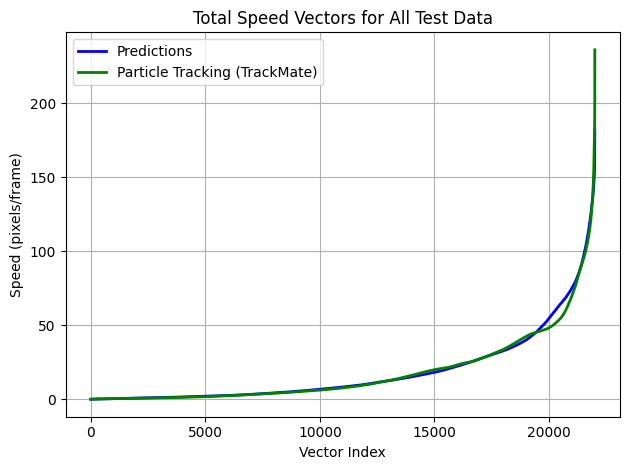

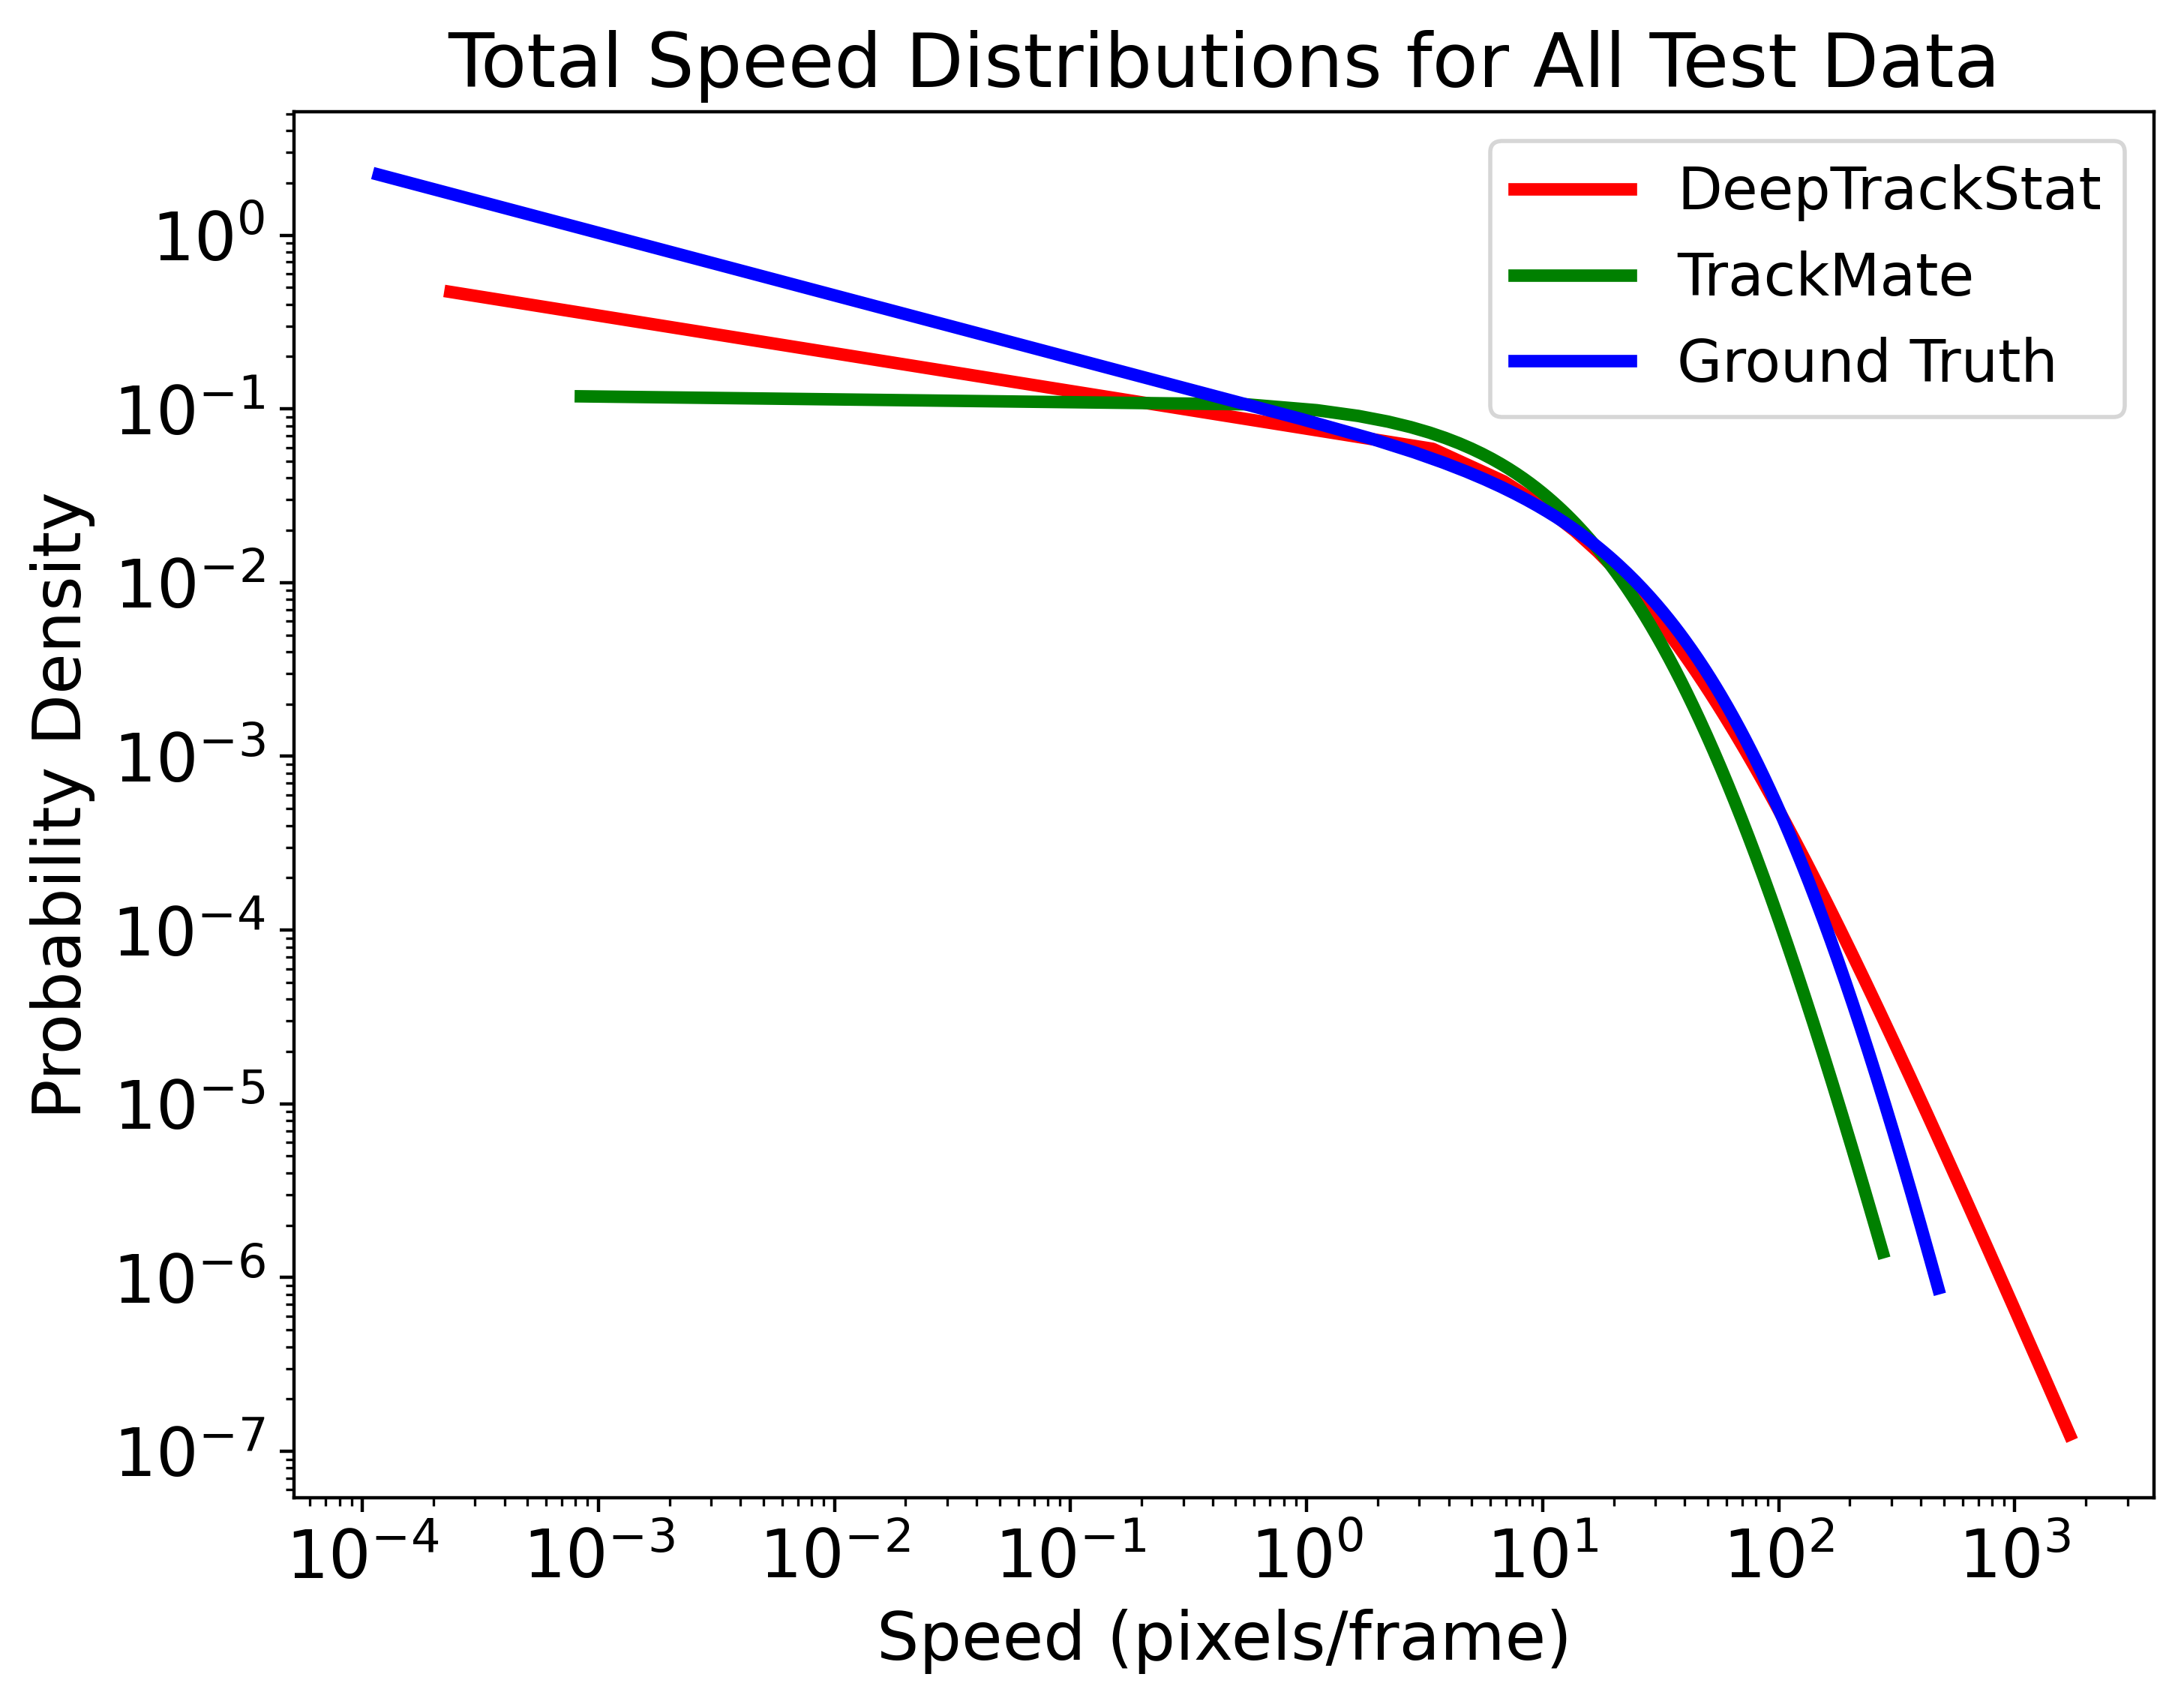

(22000,)


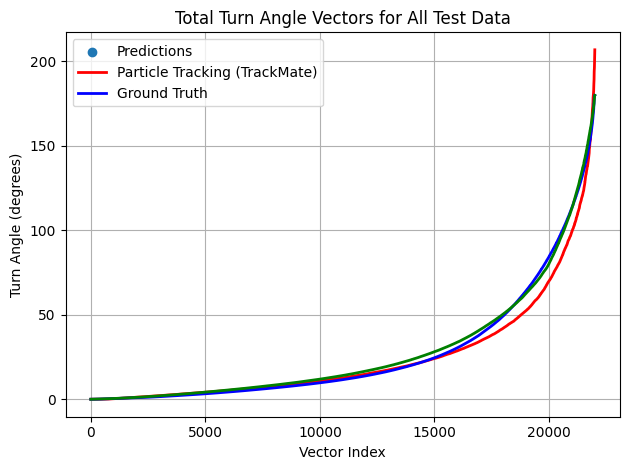

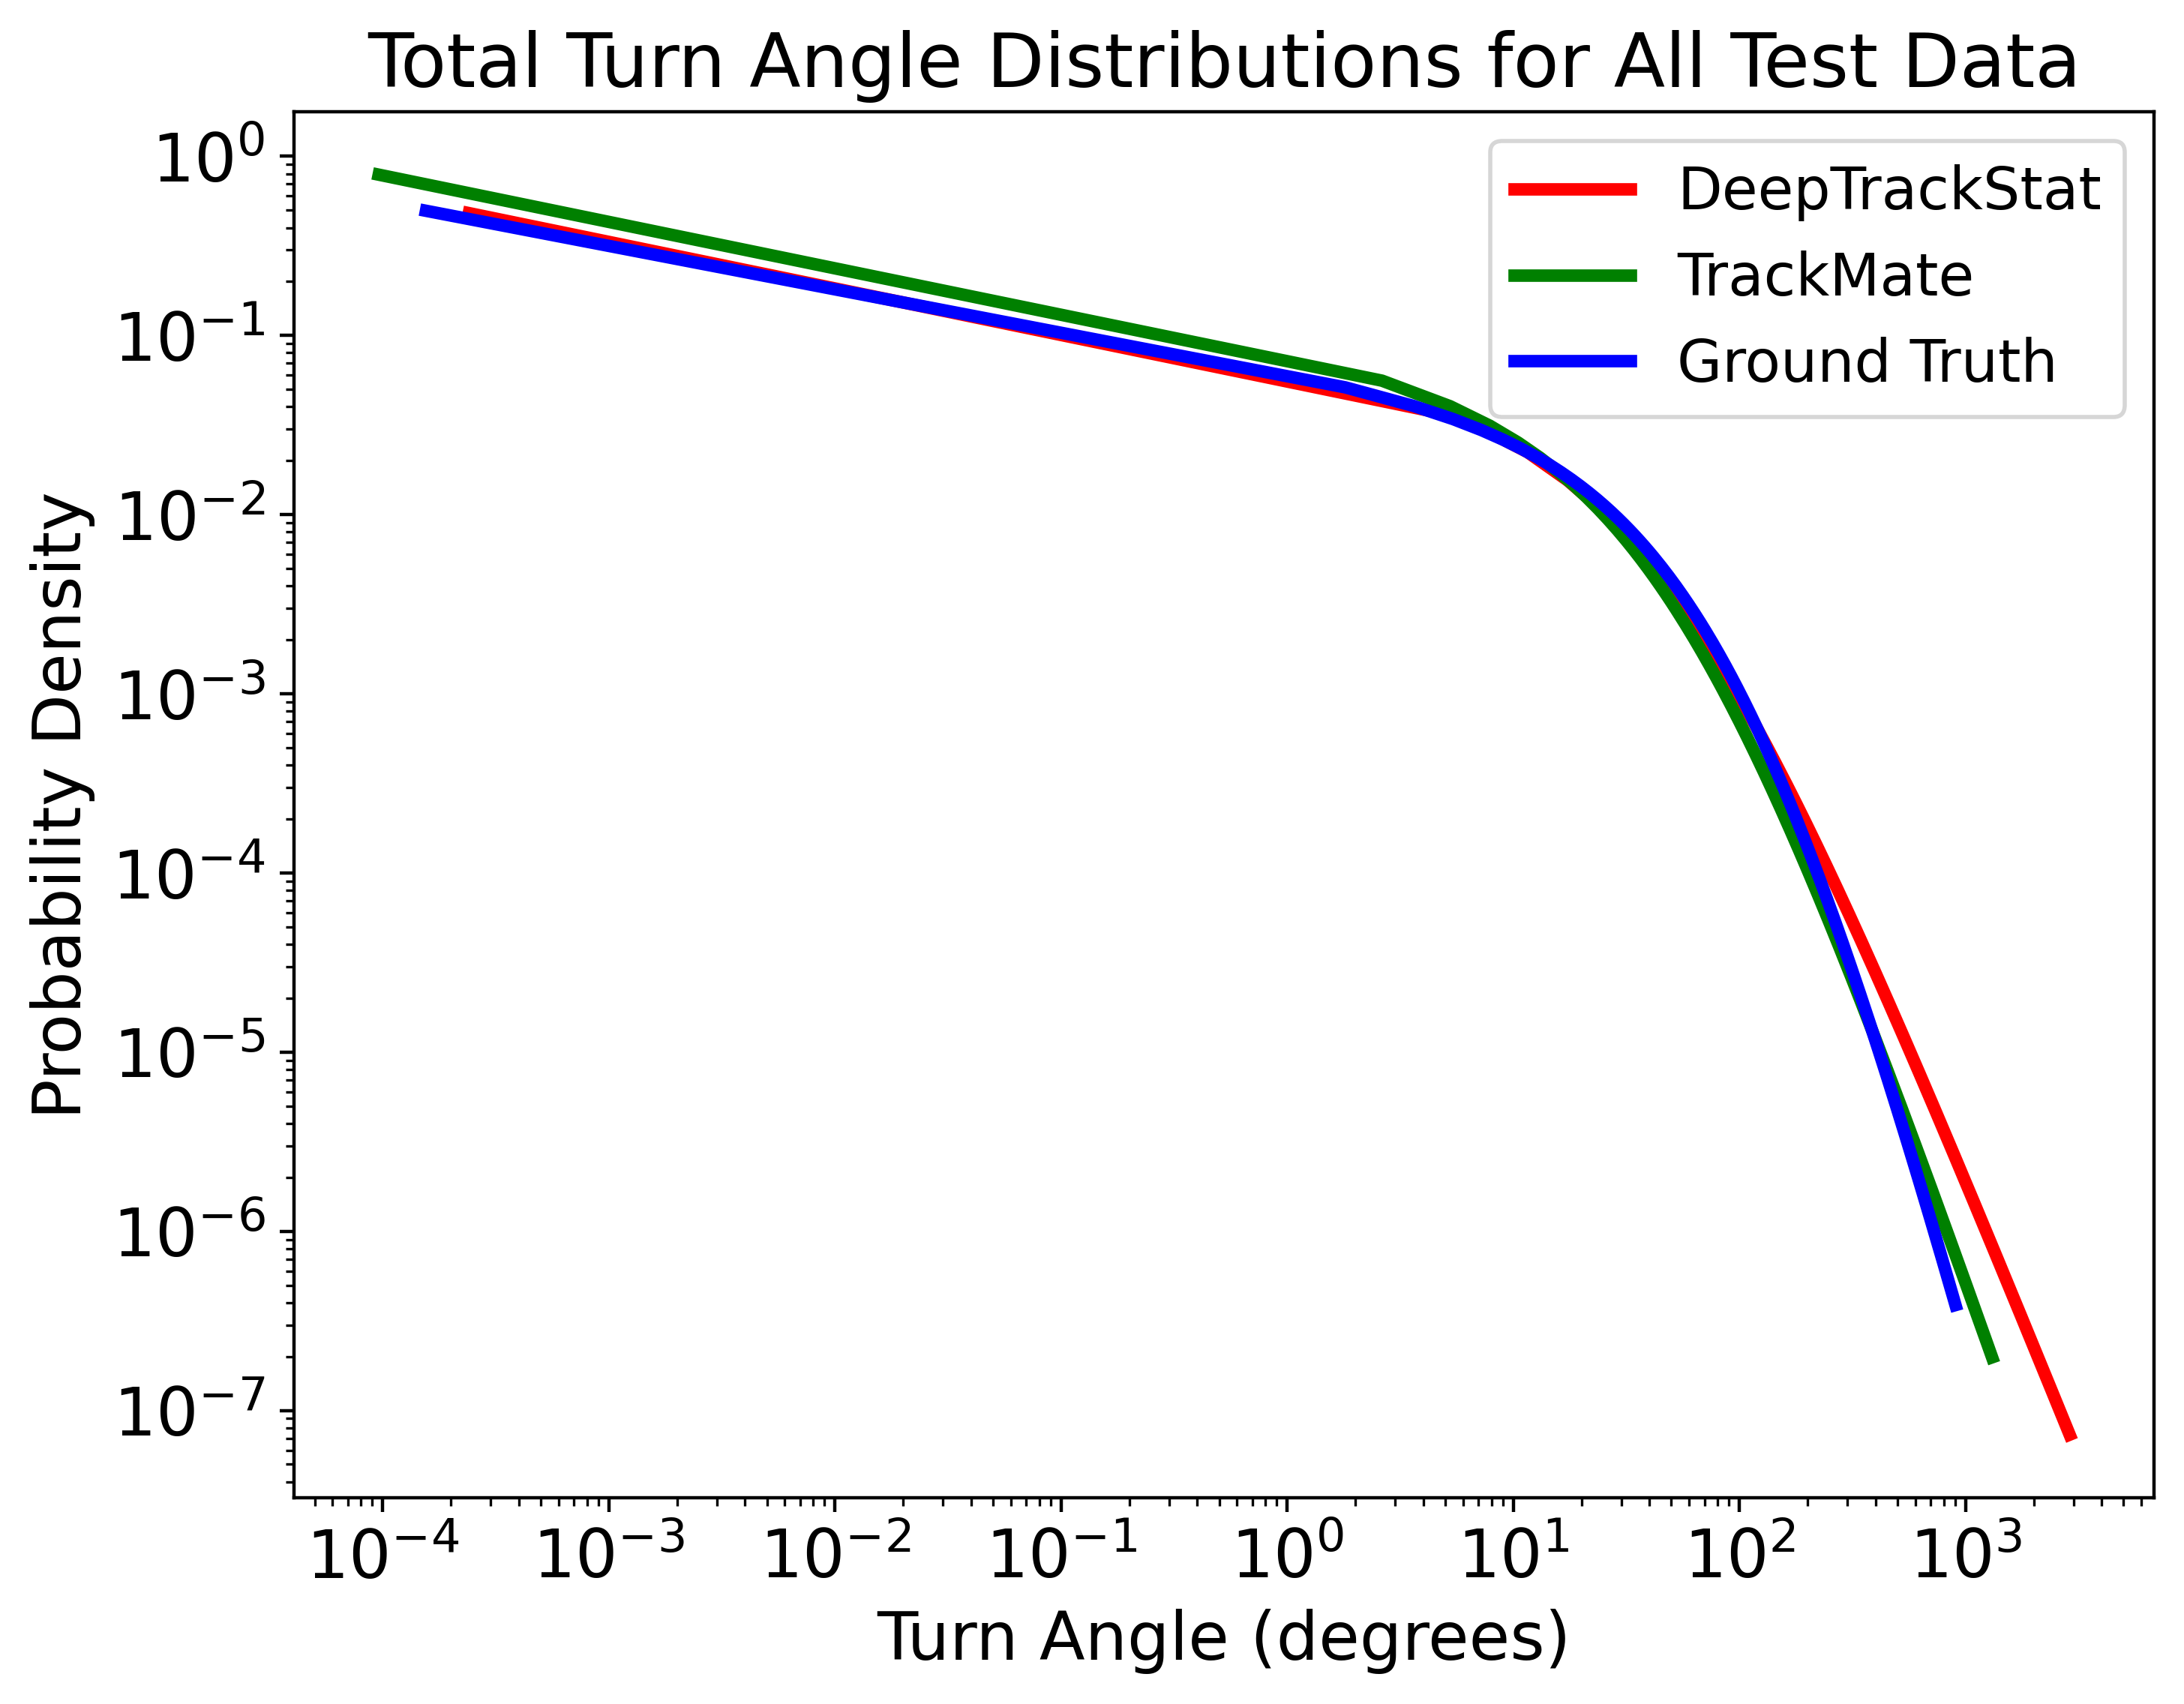

(22000,)


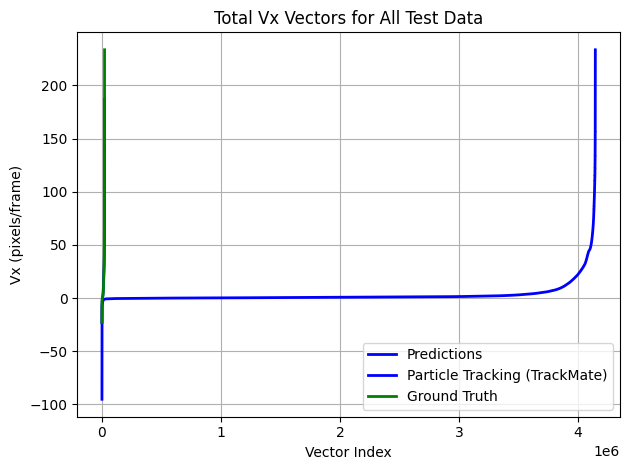

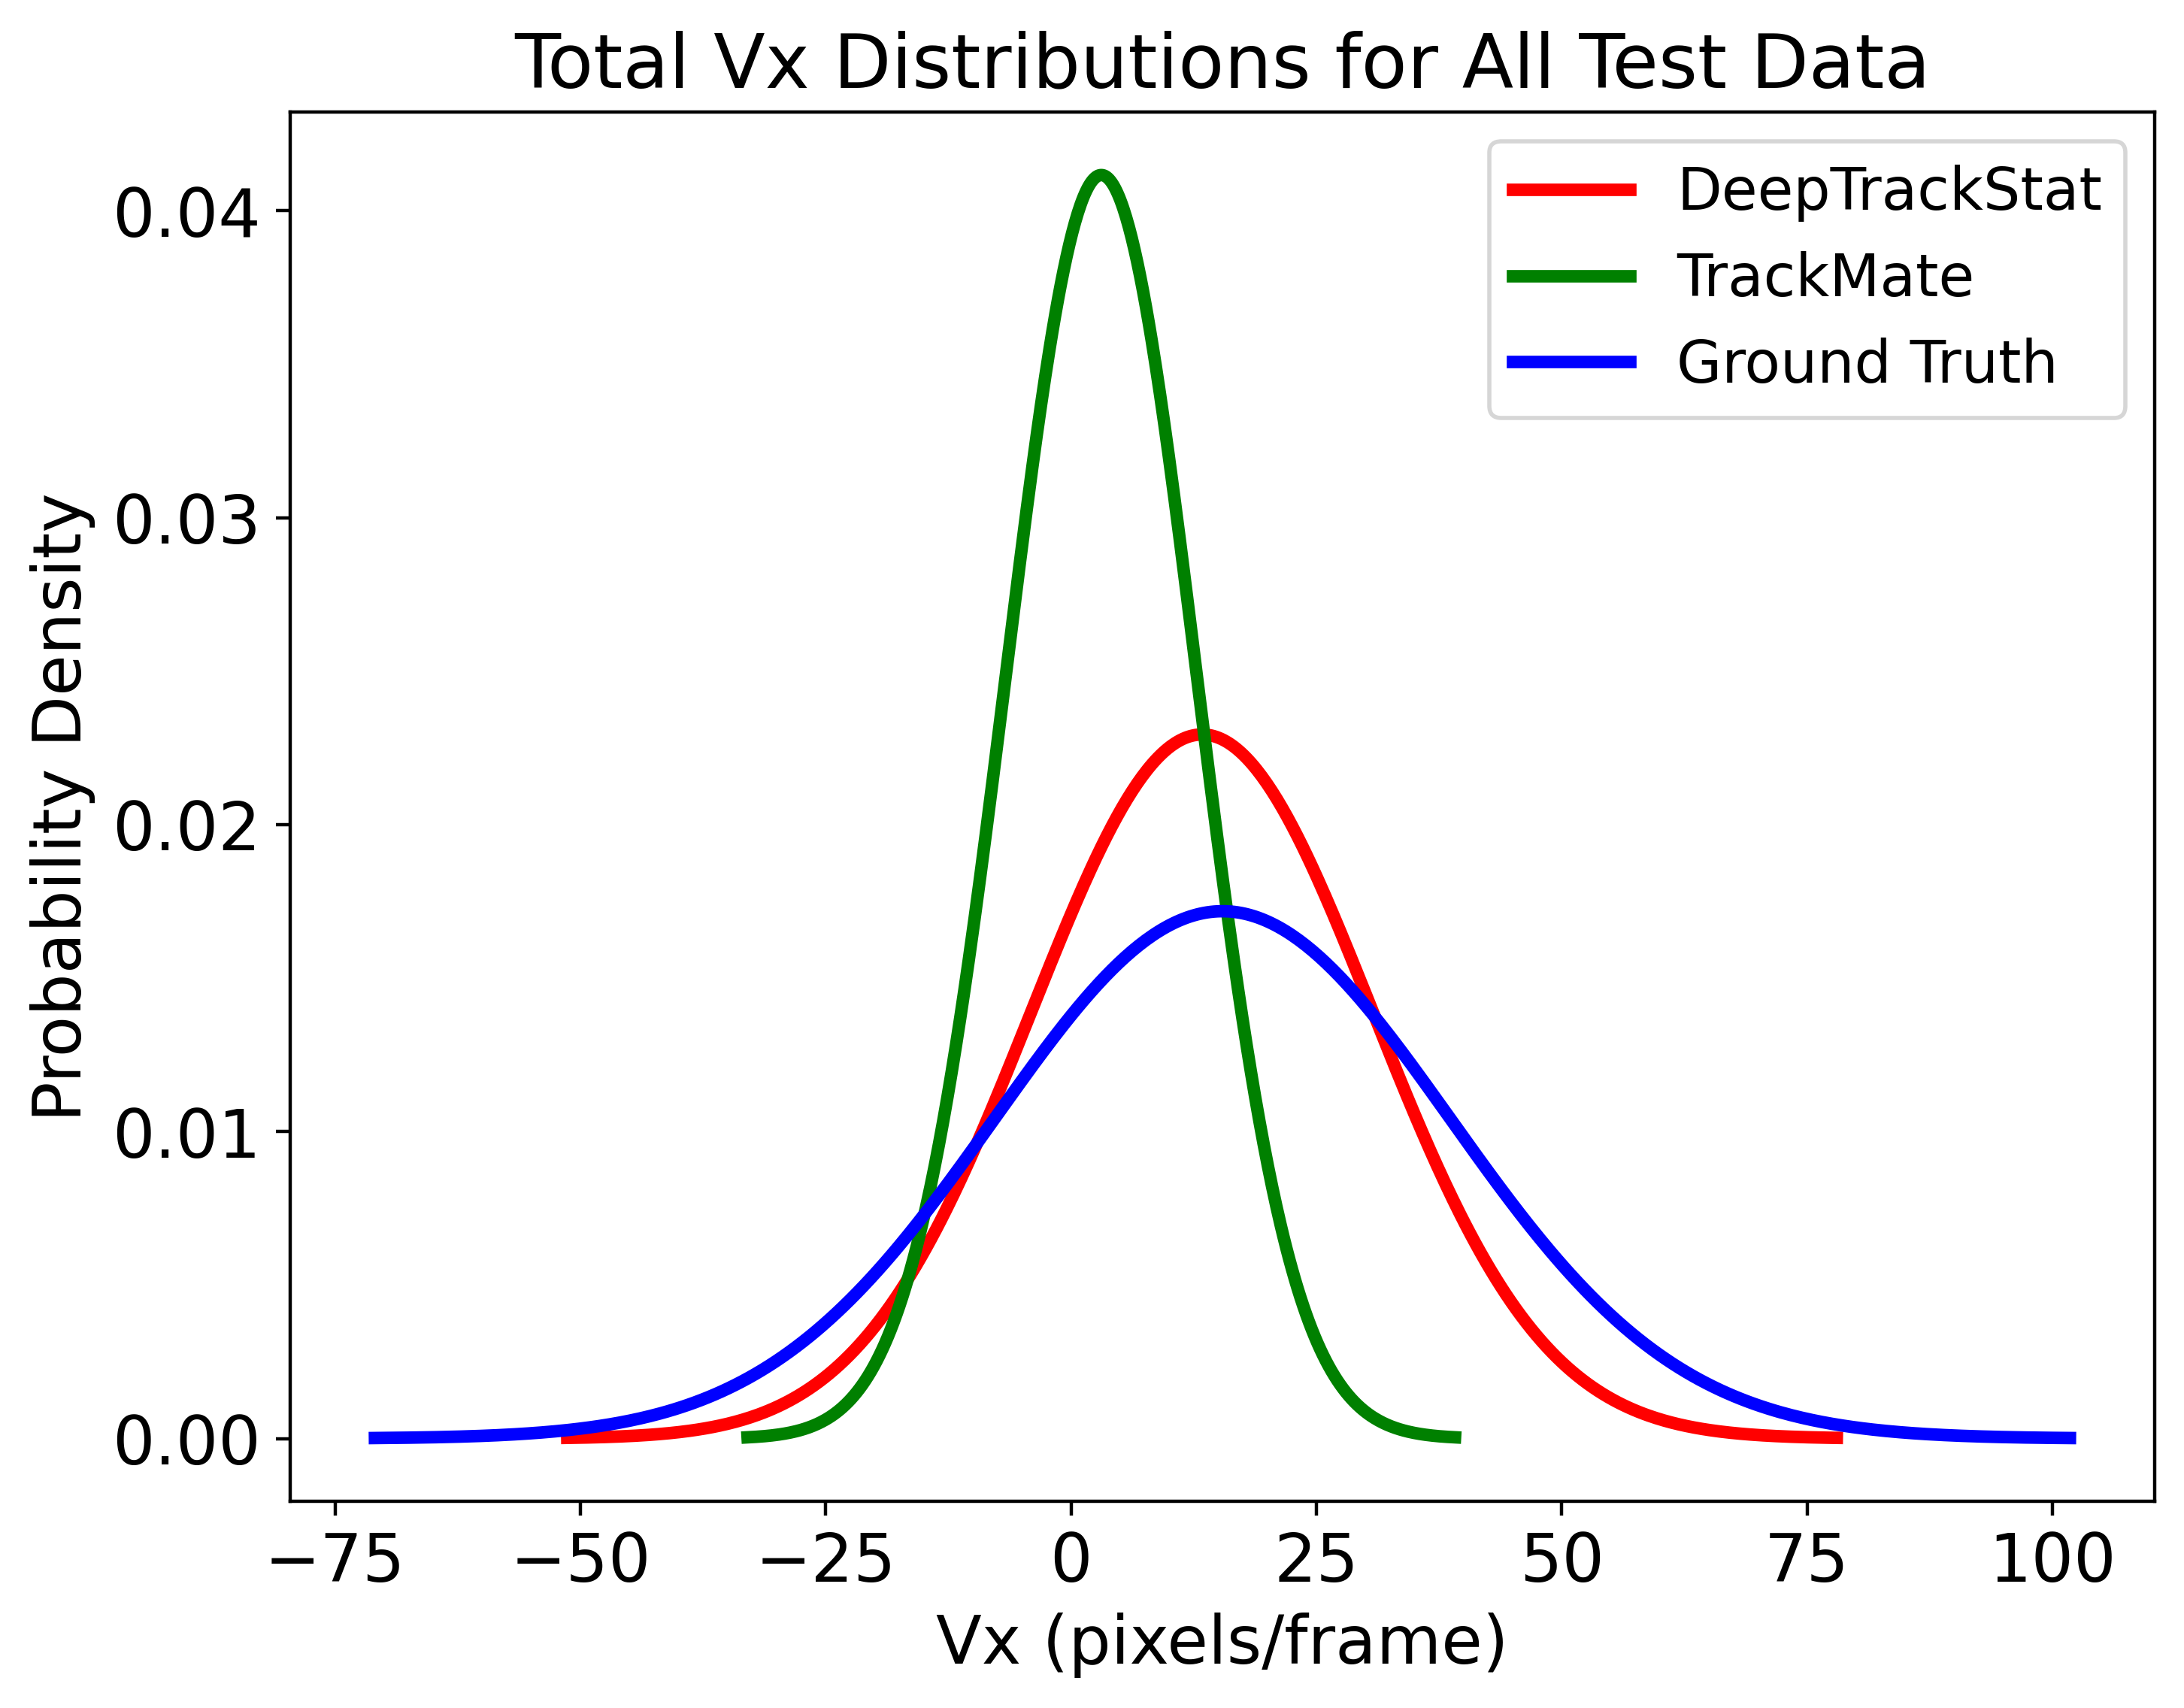

(22000,)


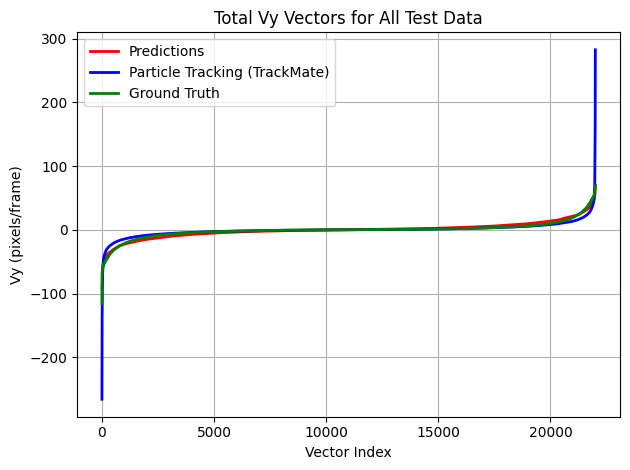

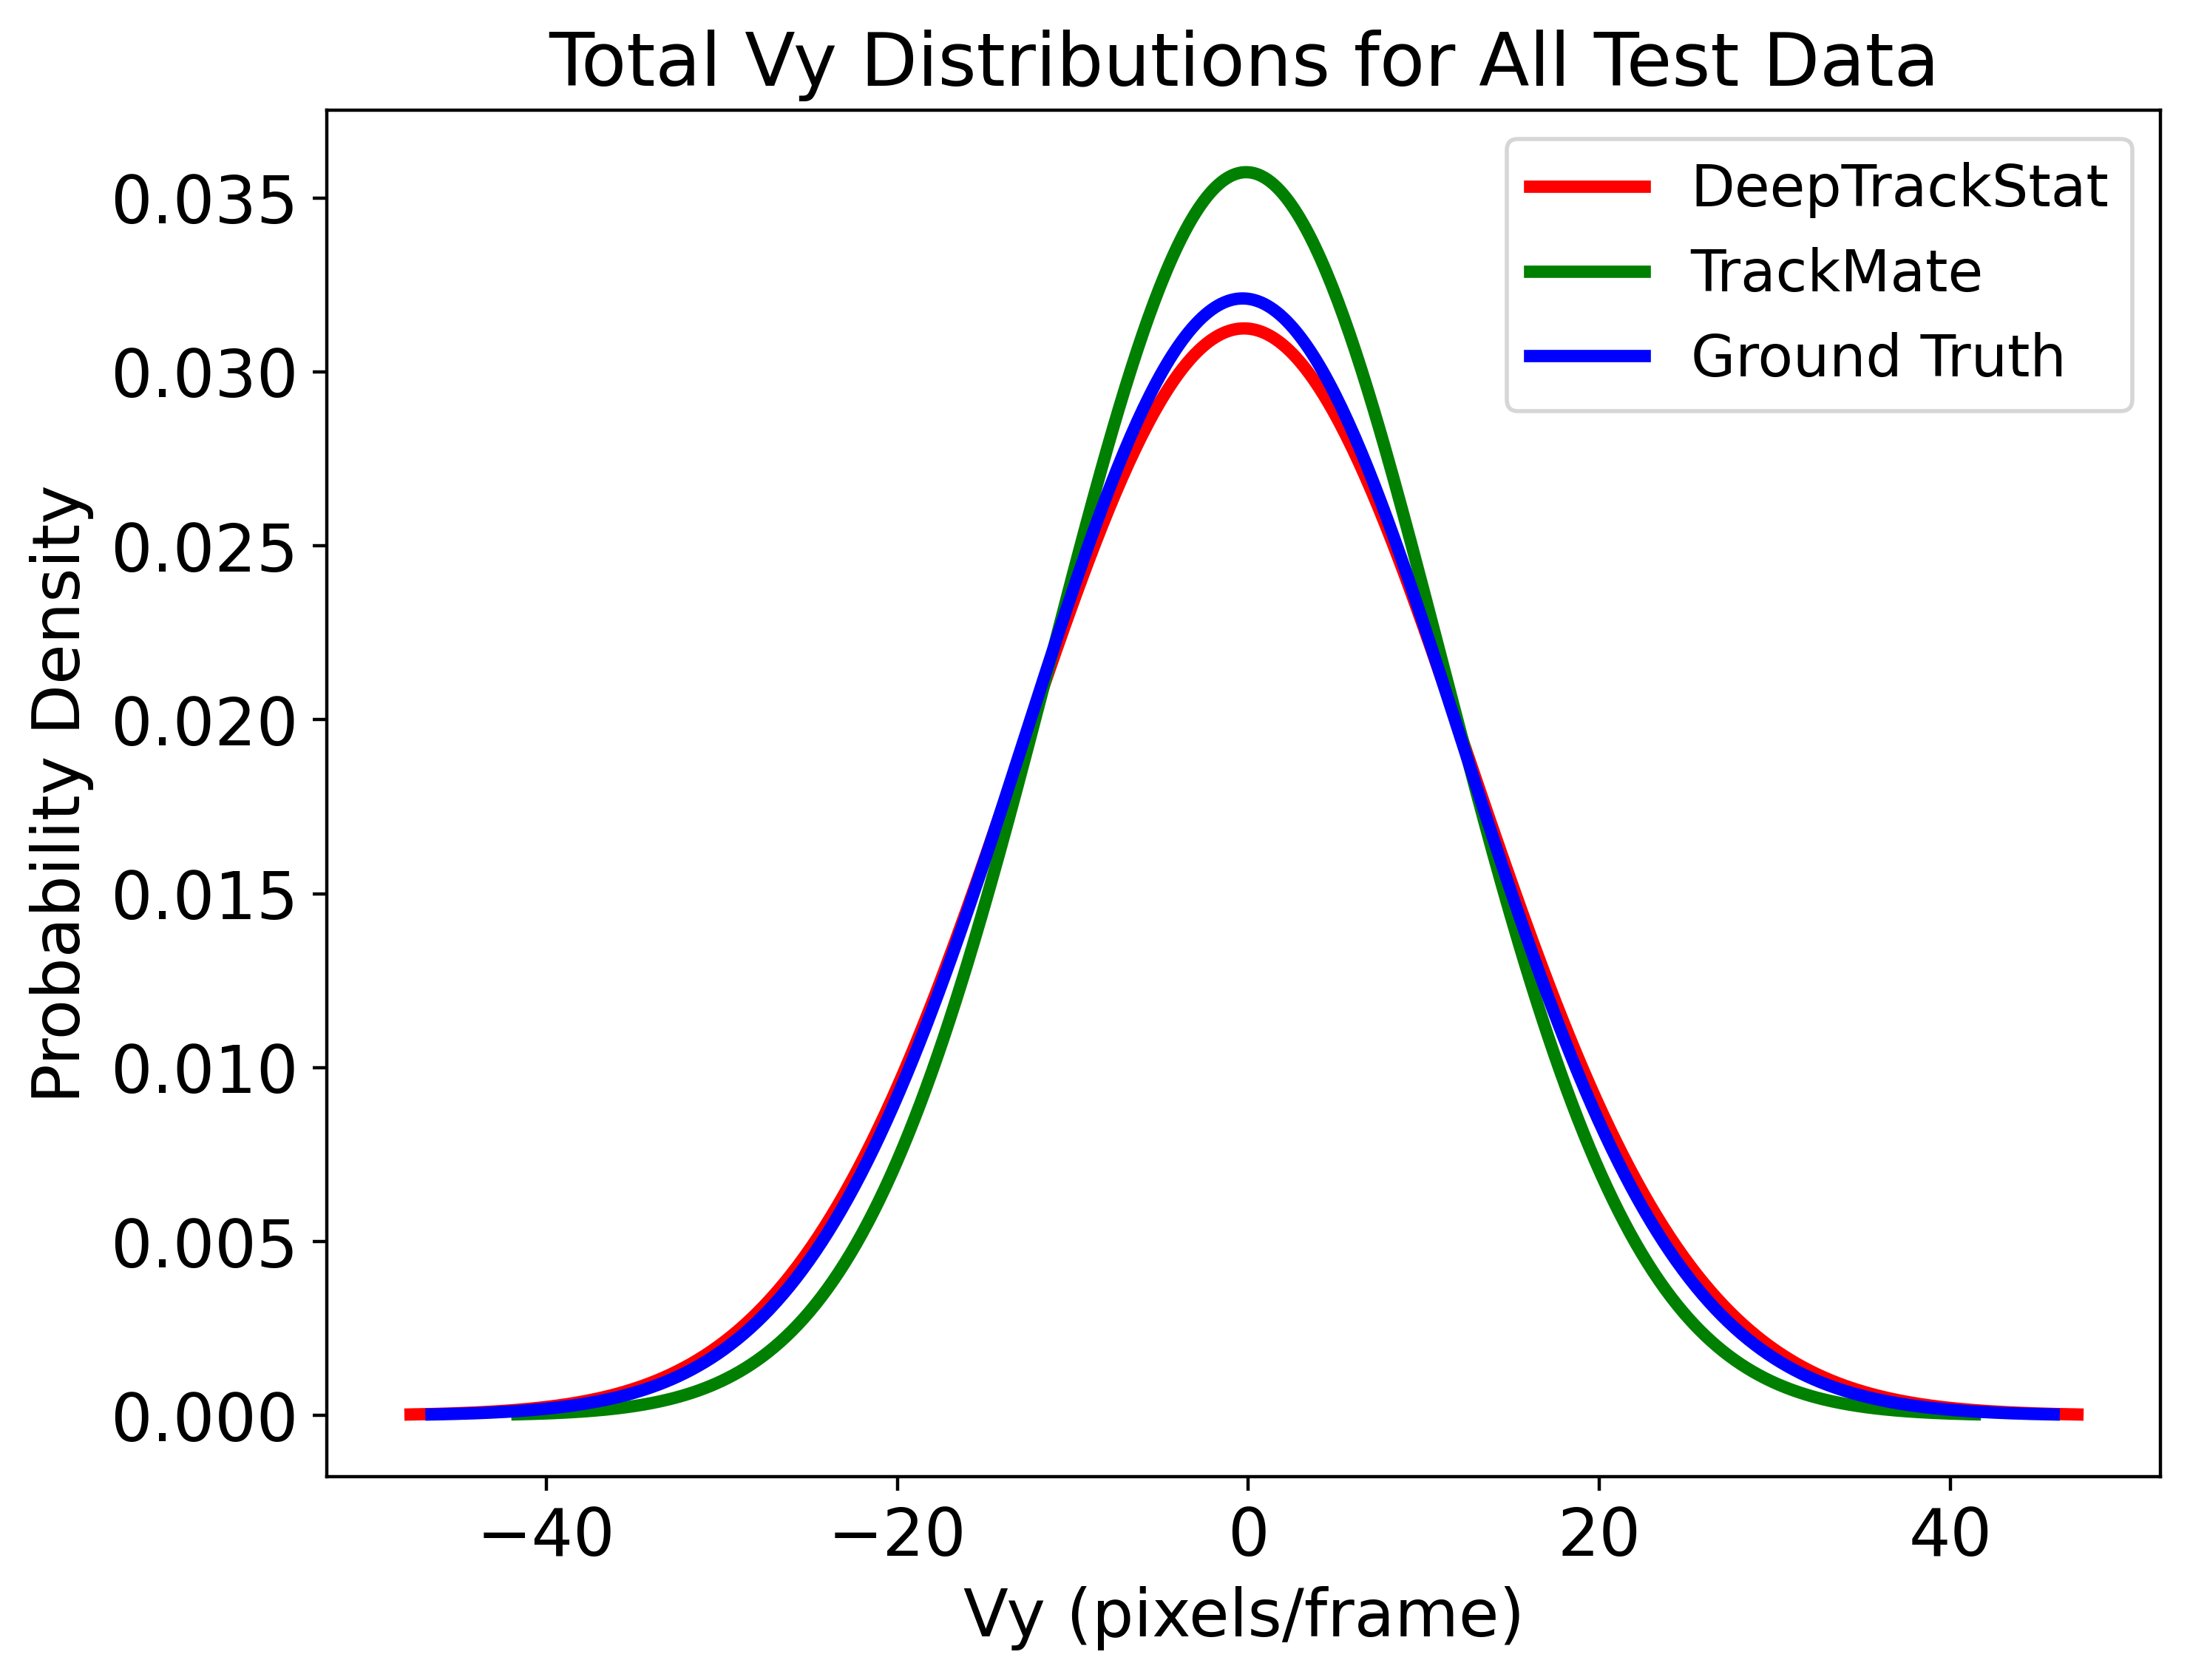

In [6]:


print(len(final_out))
print(final_out[0].shape)
q = np.sort(np.hstack(final_out))
e = np.sort(np.hstack(final_pt))
w = np.sort(np.hstack(final_true))
print(q.shape)
plt.plot(q, c='b', linewidth=2)
plt.plot(w, c='g', linewidth=2)
plt.xlabel('Vector Index')
plt.ylabel('Speed (pixels/frame)')
plt.title('Total Speed Vectors for All Test Data', fontsize=12)
plt.legend(['Predictions', 'Particle Tracking (TrackMate)'])
plt.grid(True)
plt.tight_layout()
plt.savefig('Results/Speed_final.png')
plt.show()

plt.figure(figsize=(8,6),dpi=400)
a,b,c,d = betaprime.fit(q)
xtorch= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), target_length)
distr_torch=betaprime.pdf(xtorch, a,b,c,d)
plt.plot(xtorch,distr_torch,c='r', linewidth=3)

a,b,c,d = betaprime.fit(e)
xtorch= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), target_length)
distr_torch=betaprime.pdf(xtorch, a,b,c,d)
plt.plot(xtorch,distr_torch,c='g', linewidth=3)

a,b,c,d = betaprime.fit(w) 
xtorch= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), target_length)
distr_torch=betaprime.pdf(xtorch, a,b,c,d)
plt.plot(xtorch,distr_torch,c='b', linewidth=3)
plt.title('Total Speed Distributions for All Test Data', fontsize=18)
plt.xlabel('Speed (pixels/frame)', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.legend(['DeepTrackStat', 'TrackMate', 'Ground Truth'], fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.xscale('log')
plt.yscale('log')
plt.savefig('Results/Speed_distribution_final.png')
plt.show()
plt.scatter(final_out_direction, final_true_direction)
plt.title('Directionality Predictions')
plt.xlabel('Predictions')
plt.ylabel('Particle Tracking')

###Angles
q = np.sort(np.hstack(final_out_ang))
print(q.shape)
e = np.sort(np.hstack(final_pt_ang))
w = np.sort(np.hstack(final_true_ang))
plt.plot(q, c='r', linewidth=2)
plt.plot(e, c='b', linewidth=2)
plt.plot(w, c='g', linewidth=2)
plt.xlabel('Vector Index')
plt.ylabel('Turn Angle (degrees)')
plt.title('Total Turn Angle Vectors for All Test Data', fontsize=12)
plt.legend(['Predictions', 'Particle Tracking (TrackMate)', 'Ground Truth'])
plt.grid(True)
plt.tight_layout()
plt.savefig('Results/angles_final.png')
plt.show()

plt.figure(figsize=(8,6),dpi=400)
a,b,c,d = betaprime.fit(q)
xtorch= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), target_length)
distr_torch=betaprime.pdf(xtorch, a,b,c,d)
plt.plot(xtorch,distr_torch,c='r', linewidth=3)
a,b,c,d = betaprime.fit(e)
xtorch= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), target_length)
distr_torch=betaprime.pdf(xtorch, a,b,c,d)
plt.plot(xtorch,distr_torch,c='g', linewidth=3)
a,b,c,d = betaprime.fit(w) 
xtorch= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), target_length)
distr_torch=betaprime.pdf(xtorch, a,b,c,d)
plt.plot(xtorch,distr_torch,c='b', linewidth=3)
plt.title('Total Turn Angle Distributions for All Test Data', fontsize=18)
plt.xlabel('Turn Angle (degrees)', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.legend(['DeepTrackStat', 'TrackMate', 'Ground Truth'], fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.xscale('log')
plt.yscale('log')
plt.savefig('Results/angle_distribution_final.png')
plt.show()

###Vx
q = np.sort(np.hstack(final_out_vx))
print(q.shape)
e = np.sort(np.hstack(final_pt_vx))

w = np.sort(np.hstack(final_true_vx))
plt.plot(q, c='b', linewidth=2)
plt.plot(e, c='b', linewidth=2)

plt.plot(w, c='g', linewidth=2)
plt.xlabel('Vector Index')
plt.ylabel('Vx (pixels/frame)')
plt.title('Total Vx Vectors for All Test Data', fontsize=12)
plt.legend(['Predictions', 'Particle Tracking (TrackMate)', 'Ground Truth'])
plt.grid(True)
plt.tight_layout()
plt.savefig('Results/Vx_final.png')
plt.show()

plt.figure(figsize=(8,6),dpi=400)
a,b = norm.fit(q)
xtorch= np.linspace(norm.ppf(0.0001, a,b),
                norm.ppf(0.9999, a,b), target_length)
distr_torch=norm.pdf(xtorch, a,b)
plt.plot(xtorch,distr_torch,c='r', linewidth=3)
a,b = norm.fit(e)
xtorch= np.linspace(norm.ppf(0.0001, a,b),
                norm.ppf(0.9999, a,b), target_length)
distr_torch=norm.pdf(xtorch, a,b)
plt.plot(xtorch,distr_torch,c='g', linewidth=3)
a,b = norm.fit(w) 
xtorch= np.linspace(norm.ppf(0.0001, a,b),
                norm.ppf(0.9999, a,b), target_length)
distr_torch=norm.pdf(xtorch, a,b)
plt.plot(xtorch,distr_torch,c='b', linewidth=3)
plt.title('Total Vx Distributions for All Test Data', fontsize=18)
plt.xlabel('Vx (pixels/frame)', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.legend(['DeepTrackStat', 'TrackMate', 'Ground Truth'], fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)

plt.savefig('Results/Vx_distribution_final.png')
plt.show()

###Vy
q = np.sort(np.hstack(final_out_vy))
e = np.sort(np.hstack(final_out_pt_vy))
print(q.shape)
w = np.sort(np.hstack(final_true_vy))
plt.plot(q, c='r', linewidth=2)
plt.plot(e, c='b', linewidth=2)

plt.plot(w, c='g', linewidth=2)
plt.xlabel('Vector Index')
plt.ylabel('Vy (pixels/frame)')
plt.title('Total Vy Vectors for All Test Data', fontsize=12)
plt.legend(['Predictions', 'Particle Tracking (TrackMate)', 'Ground Truth'])
plt.grid(True)
plt.tight_layout()
plt.savefig('Results/Vy_final.png')
plt.show()

plt.figure(figsize=(8,6),dpi=400)
a,b = norm.fit(q)
xtorch= np.linspace(norm.ppf(0.0001, a,b),
                norm.ppf(0.9999, a,b), target_length)
distr_torch=norm.pdf(xtorch, a,b)
plt.plot(xtorch,distr_torch,c='r', linewidth=3)
a,b = norm.fit(e)
xtorch= np.linspace(norm.ppf(0.0001, a,b),
                norm.ppf(0.9999, a,b), target_length)
distr_torch=norm.pdf(xtorch, a,b)
plt.plot(xtorch,distr_torch,c='g', linewidth=3)
a,b = norm.fit(w) 
xtorch= np.linspace(norm.ppf(0.0001, a,b),
                norm.ppf(0.9999, a,b), target_length)
distr_torch=norm.pdf(xtorch, a,b)
plt.plot(xtorch,distr_torch,c='b', linewidth=3)
plt.title('Total Vy Distributions for All Test Data', fontsize=18)
plt.xlabel('Vy (pixels/frame)', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.legend(['DeepTrackStat', 'TrackMate', 'Ground Truth'], fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)

plt.savefig('Results/Vy_distribution_final.png')
plt.show()

In [56]:
np.nanmean(displa)

0.8474611954345254

In [4]:
vels.shape

(14734,)

In [22]:
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gc
from torch.optim.lr_scheduler import StepLR
import torchvision as tv
import timm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from joblib import Parallel, delayed
from PIL import Image
from scipy.stats import exponweib,lognorm, beta, betaprime, norm, expon, wasserstein_distance
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import r2_score as r2
#class_num=4
target_length=500
device='cuda'

def classifier(dataloader, constants, weights):
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            l=200
            self.fc2=nn.Conv2d(100, l, 1, stride=2)
            #self.m1 = nn.BatchNorm1d(1000)
            self.d1 = nn.Dropout(.2)
            self.fc1=nn.Conv2d(40, 100, 1, stride=2)
            #self.m2 = nn.BatchNorm1d(l)

            self.fc5 = nn.Conv2d(l, 5,1, stride=1)
            #self.m3 = nn.BatchNorm1d(100)
            self.fc6 = nn.Linear(312500,1000)
            self.d3 = nn.Dropout(.2)
            self.fc7 = nn.Linear(100,4)
            self.fc8 = nn.Linear(2000,1000)

        def forward(self, x):
            b = x.shape[0]
            x = x.squeeze()
            
            l=200
            x = F.relu(self.fc1(x))
            #x = self.m1(x)
            x = self.d1(x)
            x = F.relu(self.fc2(x))
            #x = self.m2(x)
            x = self.d2(x)

            x = F.relu(self.fc5(x))
            #x = self.m3(x)
            x = x.reshape(b, -1)
            #x = F.relu(self.fc4(x))
            x = (self.fc6(x))

            return x


    class Patch_model(nn.Module):
        def __init__(self):
            super(Patch_model, self).__init__()
            self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.5,num_classes=500,pretrained=True)
            self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.5,num_classes=500,pretrained=True)
            self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.5,num_classes=500,pretrained=True)
            self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.5,num_classes=500,pretrained=True)


            self.fc0=nn.Linear(2000,200)
            self.fc1=nn.Linear(200,4)
            #self.fc2=nn.Linear(1000,500)


        def forward(self, x):
            l2=224
            x1 = x[:,:,0:l2,0:l2]
            x2 = x[:,:,0:l2,l2:]
            x3 = x[:,:,l2:,0:l2]
            x4 = x[:,:,l2:,l2:]
            x1 = (self.m1(x1))
            x2 = (self.m2(x2))
            x3 = (self.m3(x3))
            x4 = (self.m4(x4))
            
            #x4 = F.gelu(self.m4(x4))
            x = torch.cat([x1,x2,x3,x4],dim=1)

            x = F.gelu(self.fc0(x))

            x = F.softmax(self.fc1(x),dim=1)


            return x#,x2,x3,x4\


    class Net7(nn.Module):
        def __init__(self):
            super(Net7, self).__init__()
            self.m1 = timm.create_model('regnetx_160.pycls_in1k', in_chans=40,drop_path_rate=0.6, num_classes=4,pretrained=True)

        def forward(self, x):
            x = F.softmax(self.m1(x),dim=1)
            return x


    class Net6(nn.Module):
        def __init__(self):
            super(Net6, self).__init__()
            self.m1 = timm.create_model('regnetx_064', in_chans=40,drop_path_rate=0.4, num_classes=4,pretrained=True)

        def forward(self, x):
            x = F.softmax(self.m1(x),dim=1)
            return x
        
    class Net5(nn.Module):
        def __init__(self):
            super(Net5, self).__init__()
            self.m1 = timm.create_model('densenet169', in_chans=40, num_classes=4,pretrained=True)

        def forward(self, x):
            x = F.softmax(self.m1(x),dim=1)
            return x

    class Net4(nn.Module):
        def __init__(self):
            super(Net4, self).__init__()
            self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.9,num_classes=4,pretrained=True)

        def forward(self, x):
            x = F.softmax(self.m1(x),dim=1)
            return x
            
    class Net2(nn.Module):
        def __init__(self):
            super(Net2, self).__init__()
            self.m1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0.6,num_classes=3,pretrained=True)

        def forward(self, x):
            x = F.softmax(self.m1(x),dim=1)
            return x
        
    class Net0(nn.Module):
        def __init__(self):
            super(Net0, self).__init__()
            self.m1 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0.8,num_classes=4,pretrained=True)

        def forward(self, x):
            x = F.softmax(self.m1(x),dim=1)
            return x

    class Net1(nn.Module):
        def __init__(self):
            super(Net1, self).__init__()
            self.m1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0.6,num_classes=4,pretrained=True)

        def forward(self, x):
            x = F.softmax(self.m1(x),dim=1)
            return x
        
    class Net3(nn.Module):
        def __init__(self):
            super(Net3, self).__init__()
            l=80

            self.fc1=nn.Linear(1000,l)
            self.d1 = nn.Dropout(.1)
            self.fc2=nn.Linear(1000,l)
            self.d2 = nn.Dropout(.1)
            self.fc3 = nn.Linear(40*l*l,1000)
            self.d3 = nn.Dropout(.1)
            self.fc4 = nn.Linear(1000,250)
            self.fc4_2 = nn.Linear(250,1000)


        def forward(self, x):
            b = x.shape[0]
            x = F.relu(self.fc1(x))
            x = self.d1(x)
            x = x.permute(0,1,3,2)
            x = F.relu(self.fc2(x))
            x = self.d2(x)
            x = torch.reshape(x, [b,-1])
            x = F.relu(self.fc3(x))
            x = self.d3(x)
            x = F.relu(self.fc4(x))
            #x = torch.reshape(x, [b,10000])
            x = (self.fc4_2(x))

            return x
            
    # model3 = timm.create_model('volo_d3_448', in_chans=30,drop_path_rate=.0, num_classes=4,pretrained=False)
    # model3.load_state_dict(torch.load('models/speed_classifier_volod1_448px_disp_all_5_04'))
    # model3.to(device).eval()

    # model0 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=4,pretrained=False)
    # model0.load_state_dict(torch.load('models/speed_classifier_volod1_384px_disp_all_5_04_v3'))
    # model0.to(device).eval()

    # model1 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=4,pretrained=False)
    # model1.load_state_dict(torch.load('models/speed_classifier_volod1_384px_disp_all_5_04_v2'))
    # model1.to(device).eval()

    # model2 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=4,pretrained=False)
    # model2.load_state_dict(torch.load('models/speed_classifier_volod1_384px_disp_all_5_04_v1'))
    # model2.to(device).eval()

    model4 = timm.create_model('volo_d4_448', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    model4.load_state_dict(torch.load('models/speed_classifier_5class_volod4_448px_disp_all_5_04'))
    model4.to(device).eval()

    model5 = timm.create_model('volo_d3_448', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    model5.load_state_dict(torch.load('models/speed_classifier_5class_volod3_448px_disp_all_5_05'))
    model5.to(device).eval()

    model6 = timm.create_model('volo_d3_448', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    model6.load_state_dict(torch.load('models/speed_classifier_5class_volod3_448px_disp_lbm_5_07'))
    model6.to(device).eval()

    model7 = timm.create_model('volo_d3_448', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    model7.load_state_dict(torch.load('models/speed_classifier_5class_volod3_448px_disp_homo_5_07'))
    model7.to(device).eval()

    #model8 = timm.create_model('volo_d3_448', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    #model8.load_state_dict(torch.load('models/speed_classifier_5class_volod3_448px_disp_lbm_5_07_v2'))
    #model8.to(device).eval()

    #model9 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    #model9.load_state_dict(torch.load('models/speed_classifier_5class_volod1_384px_disp_all_5_06'))
    #model9.to(device).eval()

    model10 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    model10.load_state_dict(torch.load('models/speed_classifier_5class_volod1_384px_disp_all_5_06_v2'))
    model10.to(device).eval()

    model11 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    model11.load_state_dict(torch.load('models/speed_classifier_5class_volod1_384px_disp_all_5_06_v3'))
    model11.to(device).eval()

    #model12 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    #model12.load_state_dict(torch.load('models/speed_classifier_5class_volod1_384px_disp_all_5_06_v4'))
    #model12.to(device).eval()

    model13 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    model13.load_state_dict(torch.load('models/speed_classifier_5class_volod1_384px_disp_all_5_06_v5'))
    model13.to(device).eval()

    model14 = timm.create_model('volo_d1_384', in_chans=30,drop_path_rate=.0, num_classes=5,pretrained=False)
    model14.load_state_dict(torch.load('models/speed_classifier_5class_volod1_384px_disp_all_5_06_v6'))
    model14.to(device).eval()
    
    model15 = timm.create_model('efficientvit_b1', in_chans=30, num_classes=5,pretrained=False)
    model15.load_state_dict(torch.load('models/speed_classifier_efficientvit_b1_mse_448px_all_5_08'))
    model15.to(device).eval()
    
    model16 = timm.create_model('pvt_v2_b1', in_chans=30,num_classes=5,pretrained=False)
    model16.load_state_dict(torch.load('models/speed_classifier_pvt_v2_b1_mse_448px_all_5_08'))
    model16.to(device).eval()
    
    model17 = timm.create_model('regnetx_032', in_chans=30,num_classes=5,pretrained=False)
    model17.load_state_dict(torch.load('models/speed_classifier_regnetx_032_mse_448px_all_5_08'))
    model17.to(device).eval()
    
    model18 = timm.create_model('twins_svt_small', in_chans=30, num_classes=5,pretrained=False)
    model18.load_state_dict(torch.load('models/speed_classifier_twins_svt_small_mse_448px_all_5_09'))
    model18.to(device).eval()
    
    model19 = timm.create_model('davit_base', in_chans=30, num_classes=5,pretrained=False)
    model19.load_state_dict(torch.load('models/speed_classifier_davit_base_small_mse_448px_all_5_09'))
    model19.to(device).eval()
    
    model20 = timm.create_model('davit_base', in_chans=30, num_classes=5,pretrained=False)
    model20.load_state_dict(torch.load('models/speed_classifier_davit_base_small_mse_448px_all_5_09_v2'))
    model20.to(device).eval()
    
    model21 = timm.create_model('regnetx_064', in_chans=30, num_classes=3,pretrained=False)
    model21.load_state_dict(torch.load('models/speed_classifier_regnetx064_mse_448px_all_5_12'))
    model21.to(device).eval()
    
    model22 = timm.create_model('regnetx_064', in_chans=30, num_classes=3,pretrained=False)
    model22.load_state_dict(torch.load('models/speed_classifier_regnetx064_mse_448px_all_5_12_v2'))
    model22.to(device).eval()
    
    model23 = timm.create_model('regnetx_064', in_chans=30, num_classes=3,pretrained=False)
    model23.load_state_dict(torch.load('models/speed_classifier_regnetx064_mse_448px_all_5_12_v3'))
    model23.to(device).eval()
    
    model24 = timm.create_model('regnetx_160', in_chans=30, num_classes=3,pretrained=False)
    model24.load_state_dict(torch.load('models/speed_classifier_regnetx160_mse_448px_all_5_12'))
    model24.to(device).eval()
    
    model25 = timm.create_model('pvt_v2_b0', in_chans=30, num_classes=3,pretrained=False)
    model25.load_state_dict(torch.load('models/speed_classifier_pvt_v2_b0_mse_384px_all_5_12'))
    model25.to(device).eval()
    
    model26 = timm.create_model('pvt_v2_b1', in_chans=30, num_classes=3,pretrained=False)
    model26.load_state_dict(torch.load('models/speed_classifier_pvt_v2_b1_mse_384px_all_5_12'))
    model26.to(device).eval()
    
    model27 = timm.create_model('pvt_v2_b2', in_chans=30, num_classes=3,pretrained=False)
    model27.load_state_dict(torch.load('models/speed_classifier_pvt_v2_b2_mse_384px_all_5_12'))
    model27.to(device).eval()
    
    
    #outputs3=[]
    
    outputs1=[]
    count=0
    with torch.no_grad():
        for x in test_dataloader2:
            if torch.mean(x)>.5:
                x = 1-x
            #x=1-x
            #x1 = tv.transforms.functional.resize(x, 448)
            x2 = tv.transforms.functional.resize(x, 384)
            #x3 = tv.transforms.functional.resize(x, 224)
            # out0 =F.softmax((model0((x2).to(device)).detach().cpu()),1).numpy()
            # out1 =F.softmax((model1((x2).to(device)).detach().cpu()),1).numpy()
            # out2 =F.softmax((model2((x2).to(device)).detach().cpu()),1).numpy()
            # out3 =F.softmax((model3((x).to(device)).detach().cpu()),1).numpy()


            #out4 =F.softmax((model4((x).to(device)).detach().cpu()),1).numpy()
            out5 =F.softmax((model5((x).to(device)).detach().cpu()),1).numpy()
            out6 =F.softmax((model6((x).to(device)).detach().cpu()),1).numpy() # class 4, close to 1
            out7 =F.softmax((model7((1-x).to(device)).detach().cpu()),1).numpy()
            #out8 =F.softmax((model8((x).to(device)).detach().cpu()),1).numpy()
            #out9 =F.softmax((model9((x2).to(device)).detach().cpu()),1).numpy()
            out10 =F.softmax((model10((x2).to(device)).detach().cpu()),1).numpy()
            out11 =F.softmax((model11((x2).to(device)).detach().cpu()),1).numpy()
            #out12 =F.softmax((model12((x2).to(device)).detach().cpu()),1).numpy()
            out13 =F.softmax((model13((x2).to(device)).detach().cpu()),1).numpy()
            out13[:,3] = out13[:,3]*.1
            out14 =F.softmax((model15((x2).to(device)).detach().cpu()),1).numpy() #class 2 close to cslaa 3
            #out15 =F.softmax((model15((x).to(device)).detach().cpu()),1).numpy() # class 4
            out16 =F.softmax((model16((x).to(device)).detach().cpu()),1).numpy() #class 2 .25
            out17 =F.softmax((model17((x).to(device)).detach().cpu()),1).numpy() # class 2
            out18 =F.softmax((model18((x).to(device)).detach().cpu()),1).numpy() # class 2
            out19 =F.softmax((model19((x).to(device)).detach().cpu()),1).numpy() # class 3
            out20 =F.softmax((model20((x).to(device)).detach().cpu()),1).numpy() # class 2, .22
            out21 =F.softmax((model21((x).to(device)).detach().cpu()),1).numpy()
            out21z = np.zeros([len(out21), 5])
            out21z[:,2:5] = out21
            out22 =F.softmax((model22((x).to(device)).detach().cpu()),1).numpy()
            out22z = np.zeros([len(out22), 5])
            out22z[:,2:5] = out22
            out23 =F.softmax((model23((x).to(device)).detach().cpu()),1).numpy()
            out23z = np.zeros([len(out23), 5])
            out23z[:,2:5] = out23
            out24 =F.softmax((model24((x).to(device)).detach().cpu()),1).numpy()
            out24z = np.zeros([len(out24), 5])
            out24z[:,2:5] = out24
            out25 =F.softmax((model25((x2).to(device)).detach().cpu()),1).numpy()
            out25z = np.zeros([len(out25), 5])
            out25z[:,2:5] = out25
            out26 =F.softmax((model26((x2).to(device)).detach().cpu()),1).numpy()
            out26z = np.zeros([len(out26), 5])
            out26z[:,2:5] = out26
            out27 =F.softmax((model27((x2).to(device)).detach().cpu()),1).numpy()
            out27z = np.zeros([len(out27), 5])
            out27z[:,2:5] = out27
            
            out=(out11*5+out14*.5+out16*28.5+out17*22.6+out19*3+out5*17.5+out10*3.4+out7*.6+out13*32.2+out6*2+out18*1.5)/constants[0]#(out16*4+out17*2+out14*.5)/6.5#(out0*2+out3*40+out5*2+out7*2+out10+out13)/48
            ensemble_expression = "+".join(f"out{weight[0]}*{weight[1]}" for weight in weights)
            out = eval(ensemble_expression) / constants[0]
            out[:,0] = out[:,0]+constants[1]
            out[:,1] = out[:,1]+constants[2]
            out[:,2] = out[:,2]+constants[3]
            out[:,3] = out[:,3]+constants[4]
            out[:,4] = out[:,4]+constants[5]
            out = out/1.25

            outputs1.append(out)
            count=count+1

    print('5: ', np.mean(np.vstack(out5),0))
    print('6: ',np.mean(np.vstack(out6),0))
    print('7: ',np.mean(np.vstack(out7),0))
    #print(np.mean(np.vstack(out8),0))
    #print(np.mean(np.vstack(out9),0))
    print('10: ',np.mean(np.vstack(out10),0))
    print('11: ',np.mean(np.vstack(out11),0))
    #print(np.mean(np.vstack(out12),0))
    print('13: ',np.mean(np.vstack(out13),0))
    print('14: ',np.mean(np.vstack(out14),0))
    #print(np.mean(np.vstack(out15),0))
    print('16: ',np.mean(np.vstack(out16),0))
    print('17: ',np.mean(np.vstack(out17),0))
    print('18: ',np.mean(np.vstack(out18),0))
    print('19: ',np.mean(np.vstack(out19),0))
    
    print('20: ',np.mean(np.vstack(out20),0))
    print('21: ',np.mean(np.vstack(out21),0))
    print('22: ',np.mean(np.vstack(out22),0))
    print('23: ',np.mean(np.vstack(out23),0))
    print('24: ',np.mean(np.vstack(out24),0))
    print('25: ',np.mean(np.vstack(out25),0))
    print('26: ',np.mean(np.vstack(out26),0))
    print('27: ',np.mean(np.vstack(out27),0))
            #print('next batch')
    return outputs1


class TestDataset2(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]

        return image.float()
        
        
        
def interpolate_vectors(vector, target_length):
    current_length = len(vector)
    # Create a new x-axis with the desired length
    new_x = np.linspace(0, current_length - 1, target_length)
    # Create the old x-axis based on the current length
    old_x = np.arange(current_length)
    # Perform linear interpolation
    interpolated_vector = np.interp(new_x, old_x, vector)
    return interpolated_vector
    
def process_file(file_path, l):
    image = np.array(Image.open(file_path))
    resized_image = cv2.resize(image, [l, l])
    resized_image = (resized_image - np.min(resized_image)) / (np.max(resized_image) - np.min(resized_image))
    return resized_image

def parallel_image_processing(full_files, l):
    num_files = len(full_files)
    images = np.zeros([num_files, l, l])
    results = Parallel(n_jobs=16)(delayed(process_file)(file_path, l) for file_path in full_files)
    for i, resized_image in enumerate(results):
        images[i] = resized_image
    return images
    
def calculate_angles_test(x_arr, y_arr):
    traj_stats=[]
    x_diff = np.diff(x_arr)
    y_diff = np.diff(y_arr)
    #print(x_diff.shape)
    angles=np.zeros((len(x_diff),1))
    for i in range(len(x_diff)-1):
        theta_1=np.arctan(y_diff[i]/x_diff[i])
        theta_2=np.arctan(y_diff[i+1]/x_diff[i+1])
        angles[i]=(theta_2-theta_1)*(180/np.pi)
        traj_stats.append([angles])
    
    angles=np.abs(angles[~np.isnan(angles)])
    angles = interpolate_vectors(np.sort(angles), target_length)
    angles=angles[angles!=0]
    #angles[angles==0]=0.1
    return angles
    
directory='../experimental_trajectories/'
filenames = os.listdir(directory)
print(filenames)
# f_idx = 9
# print(filenames[f_idx])

directories = [
'../newbgs/Acid4010FR_1ulh_20X_25fps_1x1y_5min_001/',
'../newbgs/Acid4010FR_5ulh_20X_25fps_1x1y_5min_001/',
'../newbgs/Acid4020FR_1ulh_20X_25fps_1x1y_5min_001/',
'../newbgs/Acid4020FR_5ulh_20X_25fps_1x1y_5min_002/','Acid_1ulh_pre/', 
'acid_noflow/open_20x_20fps_001_frames/', 
'../newbgs/Geo8020FR_5ulh_20X_25fps_1x1y_5min_003/', 'Geo_1ulh_pre/',  
 '../new_traj/Acid01xx_20X_25fps_1min_001_frames_bgs/',
'../new_traj/Acid01xx_20X_25fps_1min_002_frames_bgs/','../new_traj/Acid01xx_20X_25fps_1min_003_frames_bgs/',
'../new_traj/Acid01xx_20X_25fps_1min_004_frames_bgs/','../new_traj/Geo01xx_20X_25fps_1min_001_frames_bgs/',
'../new_traj/Geo01xx_20X_25fps_1min_002_frames_bgs/','../new_traj/Geo01xx_20X_25fps_1min_003_frames_bgs/',
'../new_traj/01xx_20X_25fps_5min_003_frames_bgs/','../new_traj/01xx_20X_25fps_5min_003_frames_bgs/',
'../newbgs/Paen8020FR_5ulh_20X_25fps_1x1y_5min_003/',
'paen_noflow/paen_8040_20x_20fps_006_frames/', 'Paen_1ulh_pre/', 
'Paen_5ulh_pre/', 'shew_noflow/8040_20x_002_frames/', 'shew_noflow/808_20x_20fps_005_frames/']

#Speed
file_error=[]
file_mse=[]
final_out=[]
final_true=[]
speed_w1=[]
#Angle
file_error_ang=[]
file_mse_ang=[]
final_out_ang=[]
final_true_ang=[]
ang_w1=[]
#Vx
file_error_vx=[]
file_mse_vx=[]
final_out_vx=[]
final_true_vx=[]
vx_w1=[]
#Vx
file_error_vy=[]
file_mse_vy=[]
final_out_vy=[]
final_true_vy=[]
vy_w1=[]
#directionality
file_error_direction=[]
file_mse_direction=[]
final_out_direction=[]
final_true_direction=[]
direction_r2=[]

final_true_direction=[]
final_out_direction=[]
final_error_direction=[]

for f_idx in range(2,len(directories)):
    start_time = time.time()  # Record the start time

        

    print(len(filenames), len(directories))
    base=directories[f_idx]
    print(base)
    #base='shew_noflow/8040_20x_002_frames/'
    files=os.listdir(base)
    print(files[0])
    if (9<=f_idx<=13):
        brownian = 1
    else:
        brownian=0
    #5 for noflow
    #3 ofr flow
    full_files=[]
    if 'noflow' in base:
        sorted_frames = sorted(files, key=lambda x: int(x[5:-4]))
    elif 'homo' in base:
        sorted_frames = sorted(files, key=lambda x: int(x[4:-4]))
    elif 'test_sims_het' in base:
        sorted_frames = sorted(files, key=lambda x: int(x[4:-4]))
    elif 'frame' in files[0]:
        sorted_frames = sorted(files, key=lambda x: int(x[5:-4]))
    else:
        sorted_frames = sorted(files, key=lambda x: int(x[3:-4]))

    for i in range(len(sorted_frames)):
        file = base+sorted_frames[i]
        full_files.append(file)
        
    # gc.collect()

    # l1=448
    # l2 = 384
    # l3 = 224


    # images = parallel_image_processing(full_files,l1)
    # images2 = parallel_image_processing(full_files,l1)
    
    # #plt.figure(figsize=(10,10),dpi=500)
    # #plt.imshow(images1[-1])

    # if (images.shape[0]-30)%40==0:
    #     images = images[30:,:,:].reshape([(images.shape[0]-30)//40,40,448,448])
    # elif (images.shape[0]-20)%40==0:
    #     images = images[20:,:,:].reshape([(images.shape[0]-20)//40,40,448,448])
    # elif (images.shape[0]-10)%40==0:
    #     images = images[10:,:,:].reshape([(images.shape[0]-10)//40,40,448,448])
    # else:
    #     images = images.reshape([(images.shape[0])//40,40,448,448])
        
    # images = torch.tensor(images)

    # dataset_test = TestDataset2(images)#  xtorch_test, distr_torch_test, scales_test2)
    # if len(images)<4:
    #     batch_size = 1
    # else:
    #     batch_size = 4
    # test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=0)

    # if (images2.shape[0]-20)%30==0:
    #     images2 = images2[20:,:,:].reshape([(images2.shape[0]-20)//30,30,448,448])
    # elif (images2.shape[0]-10)%30==0:
    #     images2 = images2[10:,:,:].reshape([(images2.shape[0]-10)//30,30,448,448])
    # else:
    #     images2 = images2.reshape([(images2.shape[0])//30,30,448,448])

    # images2 = torch.tensor(images2)

    # dataset_test = TestDataset2(images2)#  xtorch_test, distr_torch_test, scales_test2)
    # #batch_size = 2
    # test_dataloader2 = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=0)

    # x = next(iter(test_dataloader))
    # print(x.shape)
    # #plt.imshow(x[0,29,:,:])

    
        
    # constants = [93,0,0,.169,.126,-.066]
    # weights = [['11',5],['14',.5],['16',28.5],['17',22.6],['19',3],['5',17.5],['10',3.4],['7',.6],['13',32.2],['6',2],['18',1.5]]
    # outputs1 = classifier(test_dataloader2,constants,weights)
    # mean_out = np.mean(np.vstack(outputs1),0)
    # class_num = np.argmax(mean_out)
    # print('Class Number: ',class_num)
    # print(mean_out)
    # # #class_num=1


    # class Patch_model2(nn.Module):
    #     def __init__(self):
    #         super(Patch_model2, self).__init__()
    #         self.m0 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0.0,num_classes=2000,pretrained=True)
    #         self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)

    #         self.fc1=nn.Linear(2000, 1000)
    #         self.fc2=nn.Linear(1000,500)


    #     def forward(self, x):
    #         l2=224
    #         x1 = x[:,:,0:l2,0:l2]
    #         x2 = x[:,:,0:l2,l2:]
    #         x3 = x[:,:,l2:,0:l2]
    #         x4 = x[:,:,l2:,l2:]
    #         #torch.cuda.empty_cache()
    #         #gc.collect()
    #         x = F.gelu(self.m0(x))
    #         x1 = F.gelu(self.m1(x1))
    #         x2 = F.gelu(self.m2(x2))
    #         x3 = F.gelu(self.m3(x3))
    #         x4 = F.gelu(self.m4(x4))
    #         x0 = torch.cat([x1,x2,x3,x4],dim=1)
    #         del x1,x2, x3, x4
    #         x = x*x0
    #         x = F.gelu(self.fc1(x))
    #         x = self.fc2(x)
    #         return x#,x2,x3,x4

    # class Patch_model3(nn.Module):
    #     def __init__(self):
    #         super(Patch_model3, self).__init__()
    #         self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)

    #         self.fc1=nn.Linear(2000, 1000)
    #         self.fc2=nn.Linear(1000,500)


    #     def forward(self, x):
    #         l2=224
    #         x1 = x[:,:,0:l2,0:l2]
    #         x2 = x[:,:,0:l2,l2:]
    #         x3 = x[:,:,l2:,0:l2]
    #         x4 = x[:,:,l2:,l2:]
    #         #torch.cuda.empty_cache()
    #         #gc.collect()
    #         x1 = F.gelu(self.m1(x1))
    #         x2 = F.gelu(self.m2(x2))
    #         x3 = F.gelu(self.m3(x3))
    #         x4 = F.gelu(self.m4(x4))
    #         x = torch.cat([x1,x2,x3,x4],dim=1)
    #         del x1,x2, x3, x4
    #         x = F.gelu(self.fc1(x))
    #         x = self.fc2(x)
    #         return x#,x2,x3,x4

    # class Patch_model4(nn.Module):
    #     def __init__(self):
    #         super(Patch_model4, self).__init__()
    #         self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)

    #         self.fc0=nn.Linear(2000, 500)
    #         #self.fc2=nn.Linear(1000,500)


    #     def forward(self, x):
    #         l2=224
    #         x1 = x[:,:,0:l2,0:l2]
    #         x2 = x[:,:,0:l2,l2:]
    #         x3 = x[:,:,l2:,0:l2]
    #         x4 = x[:,:,l2:,l2:]
    #         #torch.cuda.empty_cache()
    #         #gc.collect()
    #         x1 = F.gelu(self.m1(x1))
    #         x2 = F.gelu(self.m2(x2))
    #         x3 = F.gelu(self.m3(x3))
    #         x4 = F.gelu(self.m4(x4))
    #         x = torch.cat([x1,x2,x3,x4],dim=1)
    #         del x1,x2, x3, x4
    #         #x = F.gelu(self.fc1(x))
    #         x = self.fc0(x)
    #         return x#,x2,x3,x4


    # class Patch_model(nn.Module):
    #     def __init__(self):
    #         super(Patch_model, self).__init__()
    #         self.m0 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0.0,num_classes=2000,pretrained=True)
    #         self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)

    #         self.fc1=nn.Linear(4000, 1000)
    #         self.fc2=nn.Linear(1000,500)


    #     def forward(self, x):
    #         l2=224
    #         x1 = x[:,:,0:l2,0:l2]
    #         x2 = x[:,:,0:l2,l2:]
    #         x3 = x[:,:,l2:,0:l2]
    #         x4 = x[:,:,l2:,l2:]
    #         #torch.cuda.empty_cache()
    #         #gc.collect()
    #         x = F.gelu(self.m0(x))
    #         x1 = F.gelu(self.m1(x1))
    #         x2 = F.gelu(self.m2(x2))
    #         x3 = F.gelu(self.m3(x3))
    #         x4 = F.gelu(self.m4(x4))
    #         x0 = torch.cat([x1,x2,x3,x4],dim=1)
    #         del x1,x2, x3, x4
    #         x = torch.cat([x,x0],dim=1)#x*x0
    #         x = F.gelu(self.fc1(x))
    #         x = self.fc2(x)
    #         return x#,x2,x3,x4

    # class Net0(nn.Module):
    #     def __init__(self):
    #         super(Net0, self).__init__()
    #         self.m1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=True)



    #     def forward(self, x):
    #         x = self.m1(x)


    #         return x#,x2,x3,x4

    # class Net2(nn.Module):
    #     def __init__(self):
    #         super(Net2, self).__init__()
    #         self.m1 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0,num_classes=1000,pretrained=True)



    #     def forward(self, x):
    #         x = self.m1(x)


    #         return x#,x2,x3,x4

    # class Net3(nn.Module):
    #     def __init__(self):
    #         super(Net3, self).__init__()
    #         self.m1 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=True)



    #     def forward(self, x):
    #         x = self.m1(x)


    #         return x#,x2,x3,x4
            
    # class Patch_model5(nn.Module):
    #     def __init__(self):
    #         super(Patch_model5, self).__init__()
    #         self.m1 = timm.create_model('volo_d1_224', in_chans=30, drop_path_rate=0.4,num_classes=500,pretrained=True)
    #         self.m2 = timm.create_model('volo_d1_224', in_chans=30, drop_path_rate=0.4,num_classes=500,pretrained=True)
    #         self.m3 = timm.create_model('volo_d1_224', in_chans=30, drop_path_rate=0.4,num_classes=500,pretrained=True)
    #         self.m4 = timm.create_model('volo_d1_224', in_chans=30, drop_path_rate=0.4,num_classes=500,pretrained=True)
    #         self.fc0=nn.Linear(2000,500)

    #     def forward(self, x):
    #         l2=224
    #         x1 = x[:,:,0:l2,0:l2]
    #         x2 = x[:,:,0:l2,l2:]
    #         x3 = x[:,:,l2:,0:l2]
    #         x4 = x[:,:,l2:,l2:]

    #         x1 = F.relu(self.m1(x1))
    #         x2 = F.relu(self.m2(x2))
    #         x3 = F.relu(self.m3(x3))
    #         x4 = F.relu(self.m4(x4))

    #         x = torch.cat([x1,x2,x3,x4],dim=1)
    #         x = self.fc0(x)
    #         return x#,x2,x3,x4



    # model6 = Patch_model3()
    # model6.load_state_dict(torch.load('models/speed_model_volod1_patch_4x224px_dispBrown_4_21'))
    # model6.to(device).eval()

    # # model7 = Patch_model()
    # # model7.load_state_dict(torch.load('models/speed_model_Volo224-448_dispBrown_patch_v3'))
    # # model7.to(device).eval()

    # model8 =Patch_model2()
    # model8.load_state_dict(torch.load('models/speed_model_Volo224-448_dispBrown_patch_v1'))
    # model8.to(device).eval()

    # # model17 =Patch_model4()
    # # model17.load_state_dict(torch.load('models/speed_model_patch448px_disp300_4_23_v2'))
    # # model17.to(device).eval()

    # # model5 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=.0,num_classes=1000,pretrained=False)
    # # model5.load_state_dict(torch.load('models/speed_model_volod3_448px_dispBrown_4_22_v2'))
    # # model5.to(device).eval()

    # # model1 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=.0,num_classes=1000,pretrained=False)
    # # model1.load_state_dict(torch.load('models/speed_model_volod3_448px_dispBrown_4_22'))
    # # model1.to(device).eval()

    # # model2 = timm.create_model('twins_svt_small', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # # model2.load_state_dict(torch.load('models/speed_model_TwinsSvtSmall_500px_opposite_dispBrown_4_21'))
    # # model2.to(device).eval()

    # # model3 = timm.create_model('volo_d2_224', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # # model3.load_state_dict(torch.load('models/speed_model_volod1_224px_disp_4_21'))
    # # model3.to(device).eval()

    # # model4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # # model4.load_state_dict(torch.load('models/speed_model_volod1_224px_dispBrown_4_21'))
    # # model4.to(device).eval()

    # # model18 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # # model18.load_state_dict(torch.load('models/speed_model_384px_disp300_4_23'))
    # # model18.to(device).eval()

    # model19 = timm.create_model('volo_d2_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # model19.load_state_dict(torch.load('models/speed_model_384px_disp300_4_23_v2'))
    # model19.to(device).eval()

    # # model20 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # # model20.load_state_dict(torch.load('models/speed_model_volod3_448px_disp300_4_25'))
    # # model20.to(device).eval()

    # # model9 = Net0()
    # # model9.load_state_dict(torch.load('models/speed_model_Volo384_dispBrown_full'))
    # # model9.to(device).eval()

    # #model10 = Net0()
    # #model10.load_state_dict(torch.load('models/speed_model_Volo384_dispBrown_fullv2'))
    # #model10.to(device).eval()

    # model11 = Net0()
    # model11.load_state_dict(torch.load('models/speed_model_Volo384_dispBrown_fullv3'))
    # model11.to(device).eval()

    # # model12 = Net0()
    # # model12.load_state_dict(torch.load('models/speed_model_Volo384_dispBrown_full_new_v1'))
    # # model12.to(device).eval()

    # # model13 = Net2()
    # # model13.load_state_dict(torch.load('models/speed_model_Volo448_dispBrown'))
    # # model13.to(device).eval()

    # # model14 = Net3()
    # # model14.load_state_dict(torch.load('models/speed_model_Volo448_dispBrown_full'))
    # # model14.to(device).eval()

    # # model15 = timm.create_model('swinv2_small_window16_256', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # # model15.load_state_dict(torch.load('models/speed_model_patch_swin_256px_dispBrown_4_23'))
    # # model15.to(device).eval()

    # # #model16 = timm.create_model('botnet26t_256', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # # #model16.load_state_dict(torch.load('models/speed_model_ByobNet26_256px_dispBrown_4_23'))
    # # #model16.to(device).eval()

    # # model21 = timm.create_model('volo_d1_384', in_chans=35, drop_path_rate=.0,num_classes=500,pretrained=False)
    # # model21.load_state_dict(torch.load('models/speed_model_volod1_384px_disp_lbm_5_04_max216_7189'))
    # # model21.to(device).eval()

    # # model22 = timm.create_model('volo_d1_384', in_chans=30, drop_path_rate=.0,num_classes=500,pretrained=False)
    # # model22.load_state_dict(torch.load('models/speed_model_volod1_384px_disp_lbm_5_04_v3'))
    # # model22.to(device).eval()

    # # model23 = timm.create_model('volo_d1_224', in_chans=30, drop_path_rate=.0,num_classes=500,pretrained=False)
    # # model23.load_state_dict(torch.load('models/speed_model_volod1_384px_disp_all_5_04_v4'))
    # # model23.to(device).eval()

    # # model24 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # # model24.load_state_dict(torch.load('models/speed_model_volod2_384px_disp_lbm_5_04_max122_8786_v2'))
    # # model24.to(device).eval()
    
    # model25 = timm.create_model('volo_d3_448', in_chans=30, drop_path_rate=.0,num_classes=500,pretrained=False)
    # model25.load_state_dict(torch.load('models/speed_model_volod3_448px_disp_lbm_5_07'))
    # model25.to(device).eval()

    # # model26 = timm.create_model('volo_d3_448', in_chans=30, drop_path_rate=.0,num_classes=500,pretrained=False)
    # # model26.load_state_dict(torch.load('models/speed_model_volod3_448px_disp_lbm_5_07_v2'))
    # # model26.to(device).eval()
    
    # model27 = Patch_model5()
    # model27.load_state_dict(torch.load('models/speed_model_patch_448px_disp_lbm_5_07_v4'))
    # model27.to(device).eval()
    
    # # model28 = Patch_model5()
    # # model28.load_state_dict(torch.load('models/speed_model_patch_448px_disp_lbm_5_07_v3'))
    # # model28.to(device).eval()
    
    # # model29 = Patch_model5()
    # # model29.load_state_dict(torch.load('models/speed_model_patch_448px_disp_lbm_5_07_v2'))
    # # model29.to(device).eval()
    
    # # model30 = Patch_model5()
    # # model30.load_state_dict(torch.load('models/speed_model_patch_448px_disp_lbm_5_07'))
    # # model30.to(device).eval()
    

    # outputs=[]
    # outputs2=[]
    # torch.cuda.empty_cache()
    # gc.collect()
    # max24 = 140.0
    # max21 = 216.7189

    # max24 = 140.0
    # max21 = 216.7189

    # with torch.no_grad():
    #     for x in test_dataloader:
    #         if torch.mean(x)<.5:
    #             x = 1-x
    #         # # x1 = tv.transforms.functional.resize(x, 448)
    #         # x2 = tv.transforms.functional.resize(x, 224)
    #         x3 = tv.transforms.functional.resize(x, 384)
    #         #x4 = tv.transforms.functional.resize(x, 256)
    #         # # out1_1000 = (model1((1-x1).to(device)).detach().cpu().numpy())
    #         # # out1 = np.zeros([batch_size,500])
    #         # # for i in range(len(out1)):
    #         # #    out1[i,:] = interpolate_vectors(out1_1000[i,:],500)
    #         # out2 = np.sort(model2((x).to(device)).detach().cpu().numpy())
    #         out11 = np.sort(model11((x3).to(device)).detach().cpu().numpy())
    #         # # #out10 =(model10((x3).to(device)).detach().cpu().numpy())
    #         # out9 = np.sort(model9((x3).to(device)).detach().cpu().numpy())
    #         out8 = np.sort(model8((x).to(device)).detach().cpu().numpy())
    #         # out7 =np.sort(model7((x).to(device)).detach().cpu().numpy())
    #         out6 = np.sort(model6((1-x).to(device)).detach().cpu().numpy())
    #         # # #out3 = np.sort(model3((1-x2).to(device)).detach().cpu().numpy())
    #         # out4 = np.sort(model4((x2).to(device)).detach().cpu().numpy())
    #         # # #out5 = np.sort(model5((x1).to(device)).detach().cpu().numpy())
    #         # # #out12 = np.sort(model12((x3).to(device)).detach().cpu().numpy())
    #         # # #out0 = (model((1-x1).to(device)).detach().cpu().numpy())
    #         # out13_1000 = np.sort(model13((x).to(device)).detach().cpu().numpy())
    #         # out13 = np.zeros([batch_size,500])
    #         # for i in range(len(out13)-1):
    #         #      out13[i,:] = interpolate_vectors(out13_1000[i,:],500)
    #         # out14 = np.sort(model14((x).to(device)).detach().cpu().numpy())
    #         # out15 = np.sort(model15((1-x4).to(device)).detach().cpu().numpy())
    #         # # # #out16 = (model16((1-x4).to(device)).detach().cpu().numpy())
    #         #out17 = np.sort(model17((1-x).to(device)).detach().cpu().numpy())
    #         # out18 = np.sort(model18((x3).to(device)).detach().cpu().numpy())
    #         out19 = np.sort(model19((1-x3).to(device)).detach().cpu().numpy())
    #         # out20 = np.sort(model20((1-x).to(device)).detach().cpu().numpy())
    #         # # #out21 = np.sort(model21((x3[:,5:,:,:]).to(device)).detach().cpu().numpy())*max21
    #         # # #out22 = np.sort(model22((1-x3[:,5:35,:,:]).to(device)).detach().cpu().numpy())
            
    #         # # #out23 = np.sort(model23((1-x2[:,5:35,:,:]).to(device)).detach().cpu().numpy())
    #         out25 = np.sort(model25((1-x[:,5:35,:,:]).to(device)).detach().cpu().numpy())
    #         # out26 = np.sort(model26((x[:,5:35,:,:]).to(device)).detach().cpu().numpy())
    #         # out26_2 = np.sort(model26((1-x[:,5:35,:,:]).to(device)).detach().cpu().numpy())
    #         out27 = np.sort(model27((1-x[:,5:35,:,:]).to(device)).detach().cpu().numpy())
    #         # out28 = np.sort(model28((1-x[:,5:35,:,:]).to(device)).detach().cpu().numpy())
    #         # # # out29 = np.sort(model29((1-x[:,5:35,:,:]).to(device)).detach().cpu().numpy())
    #         # # #out30 = np.sort(model30((1-x[:,5:35,:,:]).to(device)).detach().cpu().numpy())
    #         # out00 = (out27*20+out25*26+out28*14+out19*3+out6*3+out20*3+out8*3+out9*3+out11*3+out15)/79

    #         # out24 = np.sort(model24((1-x3).to(device)).detach().cpu().numpy())*max24
            

    #         # out14_2 = np.sort(model14((1-x).to(device)).detach().cpu().numpy())
    #         # #out15_2 = np.sort(model15((x4).to(device)).detach().cpu().numpy())
    #         # #out16 = (model16((1-x4).to(device)).detach().cpu().numpy())
    #         # out17_2 = np.sort(model17((x).to(device)).detach().cpu().numpy())
    #         # #out18_2 = np.sort(model18((1-x3).to(device)).detach().cpu().numpy())
    #         # out19_2 = np.sort(model19((x3).to(device)).detach().cpu().numpy())
    #         # #out20_2 = np.sort(model20((x).to(device)).detach().cpu().numpy())
    #         if class_num==4:
    #             out = 1.11*(out25*40+out27*2+out19*6+out6*8+out8*4+out11)/61-.1
    #             out[:,0:10] = out[:,0:10]*1.1
    #             out[:,-5:] = out[:,-5:]*1.9
    #         elif class_num==3:
    #             out = 1.38*(out25*20+out27*1+out19*4+out6*6+out8*11+out11*8)/50-1.5
    #             out[:,0:10] = out[:,0:10]*1.2
    #             out[:,-5:] = out[:,-5:]*1.9
    #         elif class_num==2:
    #             out = 1.80*(out25*20+out27*1+out19*3+out6*6+out8*8+out11*5)/43-2
    #             out[:,0:10] = out[:,0:10]*1.3
    #             out[:,250:300] = out[:,250:300]*1.1
    #             out[:,-5:] = out[:,-5:]*2.0
    #         elif class_num==1:
    #             out = 1.25*(out25*35+out27*1+out19*3+out6*4+out11*2)/45-2.4
    #             out[:,0:10] = out[:,0:10]*1.3
    #             out[:,200:300] = out[:,200:300]*1.2
    #             out[:,-15:] = out[:,-15:]*.85
    #         else:
    #             out = 1.45*(out25*30+out27*1+out19*3+out6*4)/38-8
    #             out[:,0:10] = out[:,0:10]*1.1
    #             out[:,200:300] = out[:,200:300]*1.2
    #             out[:,-15:] = out[:,-15:]*.85
                
    #         # out = (out6*8+out7*3+out8*2+out9*2+out15*4+out17+out20+out25*4+out27*3)/28
    #         # if class_num==4:
    #         #     #1ulh
    #         #     #class 3 (x<3)
    #         #     out=(out*150+out4*2+(out14)*10+out14_2*60+out17*90+out18*15+(out17_2)*10+(out19_2)*15+(out20)*20+(out8)*1.5+(out9)*.5+out26_2*20+out24+out25*30+out27*50)/450
    #         #     const = .5
    #         #     out = np.mean(out,0)
    #         #     out = out+np.abs(np.min(out))
    #         #     out = np.sort(out)
    #         #     out = out[out<280]
    #         #     #out = out=np.abs(out)
    #         #     out = out*const
    #         #     out[0:10] = out[0:10]*.65
    #         #     out[10:20] = out[10:20]*.75
    #         #     out[30:80] = out[30:80]*1.4
    #         #     out[-30:] = out[-30:]*1.5
    #         #     out[-10:] = out[-10:]*1.4
    #         #     out[-5:] = out[-5:]*1.6
    #         #     out[0] = 0.001
    #         #     #out[-1]=299
    #         #     #out[0] = 0.01
    #         #     #out = out*.6
    #         # elif class_num==3:
    #         #     #class 2 (3<x<6)
    #         #     out=(out*600+out19_2*50+out8*750+out9*190+out4*40+out2*100+out6*225+out11*80+out15*150+out18*220+out19*150+out27*125+out26_2*5)/2780
    #         #     const = 1.1
                
    #         #     out = np.mean(out,0)
    #         #     out = out+np.abs(np.min(out))
    #         #     out = np.sort(out)
                
    #         #     out = out[out<280]
    #         #     out = out*const
    #         #     #out = out+np.abs(np.min(out))
    #         #     print(out.shape)
                
    #         #     out[0:30] = out[0:30]*.65
    #         #     out[70:300] = out[70:300]*.75
    #         #     out[-50:-20] = out[-50:-20]*.9
    #         #     out[-8:] = out[-8:]*1.3
    #         #     out[-5:] = out[-5:]*1.2
    #         #     out[-2:] = out[-2:]*1.8
    #         #     out[0] = 0.01
    #         #     #out[-:]=299
    #         #     print(out.shape)
              
    #         # elif class_num==2:
    #         #     #5ulh
    #         #     #class 1 (6<x<10)
    #         #     out = (out*500+out8*150+out9*160+out6*200+out11*100+out27*115+out24*40+out26*80+out19*30+out18*110+out26_2*20)/1510
    #         #     #out=(out*50+out3*8+out2*5+out8*15+out11*33+out13*50+out14*5+out18*17+out19*17+out6*5+out2*5+out27*5+out9*40+out11*20)/270
    #         #     const = 1.27
    #         #     out = np.mean(out,0)
    #         #     out = out+np.abs(np.min(out))
    #         #     out = np.sort(out)
    #         #     out = out[out<260]
    #         #     out = out[out>0]
    #         #     out = out*const
    #         #     out[0:10] = out[0:10]*.65
    #         #     out[60:110] = out[60:110]*.7
    #         #     out[-100:-50] = out[-100:-50]*1.1
    #         #     out[-30:] = out[-30:]*1.2
    #         #     #out[-20:] = out[-20:]*1.1
    #         #     out[-10:] = out[-10:]*1.4
    #         #     out[-5:] = out[-5:]*1.4
    #         #     out[0] = .01
    #         #     #out[-1]=299
    #         #     #out = out*1.3
    #         # elif class_num==1:
    #         #     #5ulh
    #         #     #class 1 (6<x<10)
    #         #     out = (out*550+out8*50+out9*120+out11*190+out27*160+out24*60+out26*120+out19*40+out18*100+out26_2*40)/1450
    #         #     #out=(out*50+out3*8+out2*5+out8*15+out11*33+out13*50+out14*5+out18*17+out19*17+out6*5+out2*5+out27*5+out9*40+out11*20)/270
    #         #     const = 1.32
    #         #     out = np.mean(out,0)
    #         #     out = out+np.abs(np.min(out))
    #         #     out = np.sort(out)
    #         #     out = out[out<260]
    #         #     out = out[out>0]
    #         #     out = out*const
    #         #     out[0:30] = out[0:30]*.7
    #         #     out[30:90] = out[30:90]*.95
    #         #     out[200:300] = out[200:300]*1.2
    #         #     out[-60:-10] = out[-60:-10]*.85
    #         #     out[-10:] = out[-10:]*.9
    #         #     #out[-10:] = out[-10:]*1.02
    #         #     #out[-5:] = out[-5:]*1.4
    #         #     out[0] = .1
    #         #     #out[-1]=299
    #         #     #out = out*1.5
    #         # else:
    #         #     #class 0 (x>10)
    #         #     out = (out*450+out9*140+out8*70+out11*120+out18*100+out20*20+out27*220+out25*320+out26_2*150)/1670
    #         #     const = 1.27
    #         #     out = np.mean(out,0)
    #         #     out = out+np.abs(np.min(out))
    #         #     out = np.sort(out)
    #         #     out = out[out<260]
    #         #     out = out[out>0]
    #         #     out = out*const
    #         #     out[0:30] = out[0:30]*.75
    #         #     out[30:90] = out[30:90]*.9
    #         #     out[200:300] = out[200:300]*1.2
    #         #     out[-100:-50] = out[-100:-50]*.9
    #         #     out[-5:] = out[-5:]*.9
    #         #     #out[-10:] = out[-10:]*1.04
    #         #     #out[-5:] = out[-5:]*1.5
    #         #     # out[0] = 1
    #         #    # out[-1]=299
    #         #     #out = out*1.65
    #         # #outputs.append(out)
            
            
    #         # ##out = (out6*8+out7*2+out15*4+out25*4)/18
            
    #         outputs.append(np.sort(out))

    # # directory='../tmate_trajectories/'
    # out = np.sort(np.vstack(outputs))
    filename = os.listdir(directory)[f_idx]
    print(filename)
    df = pd.read_csv(os.path.join(directory,filename),header=0, skiprows=[1,2,3])
    tracks = df.TRACK_ID.unique()
    vels=1
    for i in range(len(tracks)):
        idx = tracks[i]
        if df[df.TRACK_ID==idx].sort_values(by='FRAME').FRAME.iloc[-1] < (images.shape[0]*images.shape[1]):
            posx = df[df.TRACK_ID==idx].sort_values(by='FRAME').POSITION_X
            posy = df[df.TRACK_ID==idx].sort_values(by='FRAME').POSITION_Y

            vel = (np.sqrt(posx.diff()**2+posy.diff()**2)).dropna()
        
            vels = np.hstack([vels, vel])
            
    vels=vels[~np.isnan(vels)]
    vels = vels[vels<250]
    vels = vels[vels>0]
    # out = out[out<250]
    # out = out[out>0]
    # out = out*2

    # criterion = nn.MSELoss()
    # # #speed_loss = criterion(torch.tensor(np.sort(interpolate_vectors(np.sort(out[out>0]), len(vels)))), torch.tensor(np.sort(vels)))
    # mean_loss =  np.abs(np.mean(vels)-np.mean(out))
    # print('Mean Speed from PT: ', np.mean(vels))
    
    # print('Absolute Error of Average Speed: ',mean_loss)
    # q=np.sort(interpolate_vectors(np.sort(out), 500))
    # w=np.sort(interpolate_vectors(np.sort(vels), 500))
    # speed_loss = RMSE(w, q)
    # print('Speed Loss: ', speed_loss)
    # file_error.append(mean_loss)
    # file_mse.append(speed_loss)

    
    # final_out.append(q)
    # final_true.append(w)
    
    # plt.figure(figsize=(8, 6))
    # a,b,c,d = betaprime.fit(q)

    # xtorch= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
    #                 betaprime.ppf(0.9999, a,b,c,d), target_length)

    # distr_torch1=betaprime.pdf(xtorch, a,b,c,d)
    # plt.plot(xtorch,distr_torch1,c='r')


    # a,b,c,d = betaprime.fit(w)
        
    # xtorch= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
    #                 betaprime.ppf(0.9999, a,b,c,d), target_length)

    # distr_torch=betaprime.pdf(xtorch, a,b,c,d)

    # plt.plot(xtorch,distr_torch,c='g')
    # plt.ylabel('Probability Density')
    # plt.xlabel('Speed (pixels/frame)')
    # plt.title('Speed Vectors for '+str(base), fontsize=12)
    # plt.legend(['Predictions', 'Particle Tracking (TrackMate)'])
    # plt.grid(True)
    # plt.tight_layout()
    # plt.savefig('Results/Speed_experimental_'+str(f_idx)+'.png')
    # w1 = wasserstein_distance(distr_torch, distr_torch1)
    # print ('Earth Movers Distance: ', w1)
    
    # speed_w1.append(w1)
    

    
    
    ######################################
    ######   Turn Angle Prediction  ######
    ######################################

    tracks = df.TRACK_ID.unique()
    angles=1
    for i in range(len(tracks)):
        idx = tracks[i]
        if df[df.TRACK_ID==idx].sort_values(by='FRAME').FRAME.iloc[-1] < (images.shape[0]*images.shape[1]):
            posx = df[df.TRACK_ID==idx].sort_values(by='FRAME').POSITION_X
            posy = df[df.TRACK_ID==idx].sort_values(by='FRAME').POSITION_Y

            angle_array = calculate_angles_test(np.array(posx),np.array(posy))
            
        
            angles = np.hstack([angles, angle_array])
    angles=np.abs(angles[~np.isnan(angles)])
    angles = angles[angles>0]
    angles = angles[angles<360]
    angles = np.sort(angles)
    
    # class Net0(nn.Module):
    #     def __init__(self):
    #         super(Net0, self).__init__()
    #         self.m1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=True)

    #     def forward(self, x):
    #         x = self.m1(x)

    # model0 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=False)
    # model0.load_state_dict(torch.load('models/turn_angle_model_volod3_448px_disp_all_4_25'))
    # model0.to(device).eval()

    # model1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=False)
    # model1.load_state_dict(torch.load('models/turn_angle_model_Volod1_384_dispBrownv4'))
    # model1.to(device).eval()

    # model2 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=False)
    # model2.load_state_dict(torch.load('models/turn_angle_model_Volod1_384_dispBrownv3'))
    # model2.to(device).eval()

    # model3 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=False)
    # model3.load_state_dict(torch.load('models/turn_angle_model_Volod1_384_dispBrownv2'))
    # model3.to(device).eval()

    # model4 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=False)
    # model4.load_state_dict(torch.load('models/turn_angle_model_Volod1_384_dispBrown'))
    # model4.to(device).eval()

    # model5 = timm.create_model('volo_d3_448', in_chans=30, drop_path_rate=0,num_classes=500,pretrained=False)
    # model5.load_state_dict(torch.load('models/angle_model_volod3_448px_disp_all_5_5'))
    # model5.to(device).eval()

    # model6 = timm.create_model('volo_d1_384', in_chans=30, drop_path_rate=0,num_classes=500,pretrained=False)
    # model6.load_state_dict(torch.load('models/angle_model_volod1_384px_disp_all_5_5'))
    # model6.to(device).eval()

    # model7 = timm.create_model('volo_d1_384', in_chans=30, drop_path_rate=0,num_classes=500,pretrained=False)
    # model7.load_state_dict(torch.load('models/angle_model_volod1_384px_disp_all_5_5_v2'))
    # model7.to(device).eval()

    # model8 = timm.create_model('volo_d1_384', in_chans=30, drop_path_rate=0,num_classes=500,pretrained=False)
    # model8.load_state_dict(torch.load('models/angle_model_volod1_384px_disp_all_5_5_v3'))
    # model8.to(device).eval()
    
    # model9 = timm.create_model('volo_d3_448', in_chans=30, drop_path_rate=0,num_classes=500,pretrained=False)
    # model9.load_state_dict(torch.load('models/angle_model_volod3_448px_disp_lbm_5_7'))
    # model9.to(device).eval()
    
    # # constants = [115,0,0.25,.289,.246,+.02]
    # # weights = [['11',5],
    # # #['14',.5],
    # # ['16',38.5],
    # # ['17',22.6],
    # # ['19',3],
    # # ['5',14.5],
    # # ['10',3.4],
    # # #['7',.6],
    # # ['13',32.2],
    # # ['6',2],
    # # ['18',1.5]]
    # # outputs_class = classifier(test_dataloader2,constants,weights)
    # # mean_out = np.mean(np.vstack(outputs_class),0)
    # class_num_ang = class_num#np.argmax(mean_out)
    # print('Class Number for Angles: ',class_num_ang)
    # print(mean_out)
    # outputs_ang=[]

    # with torch.no_grad():
    #     for x in test_dataloader:
    #         if torch.mean(x)<.5:
    #             x = 1-x
    #         #x1 = torchvision.transforms.functional.resize(x, 448)
    #         x2 = tv.transforms.functional.resize(x, 384)

    #         out0 =np.sort(model0((x).to(device)).detach().cpu().numpy())
    #         out1 =np.sort(model1((x2).to(device)).detach().cpu().numpy())*.6
    #         out2 =np.sort(model2((x2).to(device)).detach().cpu().numpy())*.6
    #         out3 =np.sort(model3((x2).to(device)).detach().cpu().numpy())*.6
    #         out4 =np.sort(model4((x2).to(device)).detach().cpu().numpy())*.55
    #         out5 = out4*.03
    #         #out4 = out4*1000-27304


    #         if class_num_ang==4:
    #             out=(out2*4+out1*5+out0*2+out4)/11
    #         elif class_num_ang==3:
    #             out=(out0*10+out2*2+out1*4+out3*4+out4*5)/25
    #         elif class_num_ang==2:
    #             out=(out0+out1+out4+out3*3)/6
    #         elif class_num_ang==1:
    #             out=(out0*3+out4*1+out3*4)/8
    #         elif class_num_ang==0:
    #             out=(out0*4+out4*1)/5
    #         else:
    #             out=(out5*85+out2*4+out1*4+out0*2+out4*10)/105
    #         out[:,0] = 0.0001
    #         out[:,1] = 0.001
    #         out[:,2] = 0.0011
    #         outputs_ang.append(np.sort(out))

          
    # outputs2_ang=[]
    # import torchvision
    # with torch.no_grad():
    #     for x in test_dataloader2:
    #         if torch.mean(x)<.5:
    #             x = 1-x
    #         x1 = torchvision.transforms.functional.resize(x, 448)
    #         x2 = tv.transforms.functional.resize(x, 384)

    #         out5 =np.sort(model5((x).to(device)).detach().cpu().numpy())
    #         out6 =np.sort(model6((x2).to(device)).detach().cpu().numpy())
    #         out7 =np.sort(model7((x2).to(device)).detach().cpu().numpy())
    #         out8 =np.sort(model8((x2).to(device)).detach().cpu().numpy())
    #         out9 =np.sort(model9((x).to(device)).detach().cpu().numpy())
    #         out10 =out8*1.04
    #         out11 =out8*.04

    #         if class_num_ang==4:
    #             out=(out5*1+out6*5+out7*12+out8*2+out10*14)/34
    #         elif class_num_ang==3:
    #             out=(out5*8+out6*3+out7*4+out8*2+out9*4+out10*6)/25
    #         elif class_num_ang==2:
    #             out=(out9*3+out5*5+out8+out10*3+out7*2)/14
    #         elif class_num_ang==1:
    #             out=(out9*2+out5*2+out10)/5
    #         elif class_num_ang==0:
    #             out=(out9*2+out5*2+out7)/5
    #         else:
    #             out=(out11*120+out5*1+out6*5+out7*12+out8*2+out10*14)/154
    #         out[:,0] = 0.0001
    #         out[:,1] = 0.001
    #         out[:,2] = 0.0011
    #         #out=out0
    #         # elif class_num==2:
    #         #     out=out1
    #         #out = (out0+out1+out2)/2

    #         outputs2_ang.append(np.sort(out))
    


    # # #print('next batch')  
    # newout1 = np.vstack(outputs_ang)
    # out1 = np.mean(np.abs(newout1),0)
    # out1=out1[out1>0]

    # newout2=np.vstack(outputs2_ang)
    # out2 = np.mean(np.abs(newout2),0)
    # out2=out2[out2>0]

    # out1 = interpolate_vectors(out1,len(out2))
    # print('final 1: ',np.mean(out1))
    # print('final 2: ',np.mean(out2))


    # if class_num_ang==4:
    #     out = 1.22*(out1*1+out2*3)/4
    #     out[0:20] = out[0:20]*.94
    #     out[-4:] = out[-4:]*1.02
    # elif class_num_ang==3:
    #     out = 1.06*(out1*4+out2*2)/6
    #     out[0:20] = out[0:20]*.91
    #     out[-4:] = out[-4:]*1.02
    # elif class_num_ang==2:
    #     out=.97*(out1*6+out2*2)/8
    #     out[0:20] = out[0:20]*.91
    #     out[-4:] = out[-4:]*1.02
    # elif class_num_ang==1:
    #     out=.9*(out1*5+out2*1)/6
    #     out[0:20] = out[0:20]*.93
    #     out[-4:] = out[-4:]*1.04
    # else:
    #     out=.85*(out1*6+out2*1)/7
    #     out[0:20] = out[0:20]*.92
    #     out[-4:] = out[-4:]*1.06
    # # out.shape
    # out = np.sort(out)
    
    # out = out[out>0]
    # out = out[out<360]
    # out = out*2
    
    # mean_loss =  np.abs(np.mean(angles)-np.mean(out))
    # print('Min, Max: ', np.min(angles), np.max(angles))
    # print('Min out, Max out: ', np.min(out), np.max(out))
    # print('Mean Turn Angle from PT: ', np.mean(angles))
    # print('Mean Turn Angle from DeepTrackStat: ', np.mean(out))
    
    # print('Absolute Error of Average Turn Angle: ',mean_loss)
    # q=np.sort(interpolate_vectors(np.sort(out), 500))
    # w=np.sort(interpolate_vectors(np.sort(angles),500))
    # speed_loss = RMSE(w,q)
    # print('Turn Angle Loss: ', speed_loss)  
    # file_error_ang.append(mean_loss)
    # file_mse_ang.append(speed_loss)
    # plt.figure(figsize=(8, 6))
    # a,b = expon.fit(q)
    # xtorch= np.linspace(expon.ppf(0.0001, a,b),
    #                 expon.ppf(0.9999, a,b), target_length)
    # distr_torch1=expon.pdf(xtorch, a,b)
    # plt.plot(xtorch,distr_torch1,c='r')
    # a,b = expon.fit(w)     
    # xtorch= np.linspace(expon.ppf(0.0001, a,b),
    #                 expon.ppf(0.9999, a,b), target_length)
    # distr_torch=expon.pdf(xtorch, a,b)
    # plt.plot(xtorch,distr_torch,c='g')
    # plt.ylabel('Probability Density')
    # plt.xlabel('Turn Angle (degrees)')
    # plt.title('Turn Angle Vectors for '+str(base), fontsize=12)
    # plt.legend(['Predictions', 'Particle Tracking (TrackMate)'])
    # plt.grid(True)
    # plt.tight_layout()
    # plt.savefig('Results/Turn_angle_experimental_'+str(f_idx)+'.png')
    # w1 = wasserstein_distance(distr_torch, distr_torch1)
    # print ('Earth Movers Distance: ', w1)
    # ang_w1.append(w1)
    # final_out_ang.append(q)
    # final_true_ang.append(w)
    
    
    # ###################
    # ######   Vx  ######
    # ###################
    
    # print('Starting Vx')

    
    # from torch import nn
    # import torch.nn.functional as F

    # class Patch_model2(nn.Module):
    #     def __init__(self):
    #         super(Patch_model2, self).__init__()
    #         self.m0 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0.0,num_classes=2000,pretrained=True)
    #         self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)

    #         self.fc1=nn.Linear(2000, 1000)
    #         self.fc2=nn.Linear(1000,500)


    #     def forward(self, x):
    #         l2=224
    #         x1 = x[:,:,0:l2,0:l2]
    #         x2 = x[:,:,0:l2,l2:]
    #         x3 = x[:,:,l2:,0:l2]
    #         x4 = x[:,:,l2:,l2:]
    #         x = F.gelu(self.m0(x))
    #         x1 = F.gelu(self.m1(x1))
    #         x2 = F.gelu(self.m2(x2))
    #         x3 = F.gelu(self.m3(x3))
    #         x4 = F.gelu(self.m4(x4))
    #         x0 = torch.cat([x1,x2,x3,x4],dim=1)
    #         del x1,x2, x3, x4
    #         x = x*x0
    #         x = F.gelu(self.fc1(x))
    #         x = self.fc2(x)
    #         return x#,x2,x3,x4

    # class Patch_model3(nn.Module):
    #     def __init__(self):
    #         super(Patch_model3, self).__init__()
    #         self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.fc1=nn.Linear(2000, 1000)
    #         self.fc2=nn.Linear(1000,500)

    #     def forward(self, x):
    #         l2=224
    #         x1 = x[:,:,0:l2,0:l2]
    #         x2 = x[:,:,0:l2,l2:]
    #         x3 = x[:,:,l2:,0:l2]
    #         x4 = x[:,:,l2:,l2:]
    #         x1 = F.gelu(self.m1(x1))
    #         x2 = F.gelu(self.m2(x2))
    #         x3 = F.gelu(self.m3(x3))
    #         x4 = F.gelu(self.m4(x4))
    #         x = torch.cat([x1,x2,x3,x4],dim=1)
    #         del x1,x2, x3, x4
    #         x = F.gelu(self.fc1(x))
    #         x = self.fc2(x)
    #         return x#,x2,x3,x4

    # class Patch_model4(nn.Module):
    #     def __init__(self):
    #         super(Patch_model4, self).__init__()
    #         self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.fc0=nn.Linear(2000, 500)

    #     def forward(self, x):
    #         l2=224
    #         x1 = x[:,:,0:l2,0:l2]
    #         x2 = x[:,:,0:l2,l2:]
    #         x3 = x[:,:,l2:,0:l2]
    #         x4 = x[:,:,l2:,l2:]
    #         x1 = F.gelu(self.m1(x1))
    #         x2 = F.gelu(self.m2(x2))
    #         x3 = F.gelu(self.m3(x3))
    #         x4 = F.gelu(self.m4(x4))
    #         x = torch.cat([x1,x2,x3,x4],dim=1)
    #         del x1,x2, x3, x4
    #         #x = F.gelu(self.fc1(x))
    #         x = self.fc0(x)
    #         return x#,x2,x3,x4


    # class Patch_model(nn.Module):
    #     def __init__(self):
    #         super(Patch_model, self).__init__()
    #         self.m0 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0.0,num_classes=2000,pretrained=True)
    #         self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
    #         self.fc1=nn.Linear(4000, 1000)
    #         self.fc2=nn.Linear(1000,500)

    #     def forward(self, x):
    #         l2=224
    #         x1 = x[:,:,0:l2,0:l2]
    #         x2 = x[:,:,0:l2,l2:]
    #         x3 = x[:,:,l2:,0:l2]
    #         x4 = x[:,:,l2:,l2:]
    #         x = F.gelu(self.m0(x))
    #         x1 = F.gelu(self.m1(x1))
    #         x2 = F.gelu(self.m2(x2))
    #         x3 = F.gelu(self.m3(x3))
    #         x4 = F.gelu(self.m4(x4))
    #         x0 = torch.cat([x1,x2,x3,x4],dim=1)
    #         del x1,x2, x3, x4
    #         x = torch.cat([x,x0],dim=1)#x*x0
    #         x = F.gelu(self.fc1(x))
    #         x = self.fc2(x)
    #         return x#,x2,x3,x4

    # class Net0(nn.Module):
    #     def __init__(self):
    #         super(Net0, self).__init__()
    #         self.m1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=True)

    #     def forward(self, x):
    #         x = self.m1(x)
    #         return x#,x2,x3,x4

    # class Net2(nn.Module):
    #     def __init__(self):
    #         super(Net2, self).__init__()
    #         self.m1 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0,num_classes=1000,pretrained=True)

    #     def forward(self, x):
    #         x = self.m1(x)
    #         return x#,x2,x3,x4

    # class Net3(nn.Module):
    #     def __init__(self):
    #         super(Net3, self).__init__()
    #         self.m1 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=True)

    #     def forward(self, x):
    #         x = self.m1(x)
    #         return x#,x2,x3,x4
            
    # class Net4(nn.Module):
    #     def __init__(self):
    #         super(Net4, self).__init__()
    #         self.m1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0.2,num_classes=500,pretrained=True) 
    #         self.m2 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0.2,num_classes=500,pretrained=True) 
    #         self.fc1=nn.Linear(2,2)
    #     def forward(self, x):
    #         vx = F.gelu(self.m1(x))
    #         vy = F.gelu(self.m2(x))
    #         vx = vx.unsqueeze(2)
    #         vy = vy.unsqueeze(2)
    #         x = torch.cat([vx,vy],dim=2)
    #         x = self.fc1(x)
    #         return x#,x2,x3,x4
            
    # model0 = timm.create_model('volo_d4_448', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # model0.load_state_dict(torch.load('models/vx_model_volod4_448px_disp_all_max151_1078_min-49_9241'))
    # model0.to(device).eval()

    # model1 = timm.create_model('volo_d2_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # model1.load_state_dict(torch.load('models/vx_model_volod1_384px_noscale_disp_500_4_27'))
    # model1.to(device).eval()

    # model2 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # model2.load_state_dict(torch.load('models/vx_model_volod1_384px_opposite_disp_300_4_27'))
    # model2.to(device).eval()

    # model3 = timm.create_model('regnetx_032', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # model3.load_state_dict(torch.load('models/vx_model_regnetx32_384px_disp_all_4_27'))
    # model3.to(device).eval()

    # model4 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # model4.load_state_dict(torch.load('models/vx_model_volod1_384px_disp_all_4_27'))
    # model4.to(device).eval()

    # model5 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # model5.load_state_dict(torch.load('models/vx_model_volod3_448px_disp_all_4_27'))
    # model5.to(device).eval()

    # model6 = timm.create_model('regnetx_016', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # model6.load_state_dict(torch.load('models/vx_model_regnetx_384px_disp_all_4_27'))
    # model6.to(device).eval()

    # model7 = Net4()
    # model7.load_state_dict(torch.load('models/vel_model_volod1_384px_disp_all_4_27'))
    # model7.to(device).eval()

    # model8 = timm.create_model('volo_d3_448', in_chans=30, drop_path_rate=.0,num_classes=500,pretrained=False)
    # model8.load_state_dict(torch.load('models/vx_model_volod3_448px_disp_all_max219_541_min-49_9241'))
    # model8.to(device).eval()
    
    # def calculate_velocity( y_positions):
    #     # Calculate velocities
    #     y_velocities = (y_positions[1:] - y_positions[:-1]) 
                
    #     return  y_velocities
    
    # outputs=[]
    # outputs2=[]
    # torch.cuda.empty_cache()
    # gc.collect()


    # # print (slope200, slope300, slope500, slope_all)
    # # print (int200, int300, int500, int_all)
    # # tensor(182.7808) tensor(182.7808) tensor(184.0055) tensor(216.6908)
    # # tensor(-16.0141) tensor(-16.0141) tensor(-17.2388) tensor(-49.9241)
    # slope200, int200 = 182.7808, -16.0141
    # slope_all, int_all = 216.6908, -49.9241
    # slope_all2, int_all2 = 230, -45
    # #vx_model_volod4_448px_disp_all_max151_1078_min-49_9241
    # max1 = 151.1078
    # min1 = -49.9241
    # slope1 = max1-min1
    # int1 = min1

    # max2 = 219.541
    # min2 = -49.9241
    # slope2 = max2-min2
    # int2 = min2

    # with torch.no_grad():
    #     for x in test_dataloader:
    #         if torch.mean(x)<.5:
    #             x = 1-x
    #         #x1 = torchvision.transforms.functional.resize(x, 448)
    #         out0 = np.sort(model0((x).to(device)).detach().cpu().numpy())*slope1+int1
    #        # # x=1-x
    #         x2 = torchvision.transforms.functional.resize(x, 384)
            
    #         out1 = np.sort(model1((x2).to(device)).detach().cpu().numpy())
    #         out2 = np.sort(model2((1-x2).to(device)).detach().cpu().numpy())*slope200+int200
    #         out4 = np.sort(model4((x2).to(device)).detach().cpu().numpy())*slope_all+int_all
    #         out5 = np.sort(model5((x).to(device)).detach().cpu().numpy())*slope_all2+int_all2
    #         out6 = np.sort(model6((x).to(device)).detach().cpu().numpy())*50
    #         out7= np.sort(model7((x2).to(device)).detach().cpu().numpy())*slope_all2+int_all2
    #         out7 = out7[:,:,0].squeeze()
    #         out12= 24*(np.sort(model7((x2).to(device)).detach().cpu().numpy())*slope_all2+int_all2)
    #         out13= np.sort(-23*(np.sort(model7((x2).to(device)).detach().cpu().numpy())*slope_all2+int_all2))
    #         out12 = out12[:,:,0].squeeze()
    #         out13 = out13[:,:,0].squeeze()
    #         out15 = (out12*3+out13)/4
    #         out16 = (out12*1+out13)/2
    #         out8 = out7*1.5-10
    #         out9 = 5*(out7*1.3-17)
    #         out10 = np.sort(model8((x[:,5:35,:,:]).to(device)).detach().cpu().numpy())*slope2+int2
    #         out5_2 = out5*2
            
    #         # print(out7.shape)
    #         out11 = (out0-1.0)*4
    #         out14 = (out6*6+out4*10+out7*4+out8*2+out0*2+out1*2+out5+out16*4+out10*5)/35.5
    #         out15 = (out6*2+out4*4+out10)/7
            

            
    #         # ##class1
    #         if class_num==0:
    #             out=10.4*(out15*1+out0*2+out14*5+out6*2+out4*4+out10+out16*2)/17+1
    #             #out=5.4*(out5_2*20+out14*130+out15*60+out16*240+out11*140+out0*10+out4*10+out5*2+out2*2+out8*80+out10*100+out9*20)/940-4
    #         elif class_num==1:
    #             out=4.8*(out15*1+out0*2+out14*4+out6*2+out4*4+out10)/14+1
    #             #out=2.65*(out14*130+out15*50+out16*200+out11*135+out0*10+out4*10+out5*2+out2*2+out8*60+out10*80+out9*20)/800-3
    #         elif class_num==2:
    #             out=3.9*(out15*2+out0*2+out14*4+out6*2+out4*4+out10+out16)/16-6.4
    #             #out=2.85*(out0*10+out1*10+out14*130+out15*40+out16*220+out11*180+out0*10+out4*10+out5*2+out2*2+out8*40+out9*90+out10*60)/900-2

    #         elif class_num==3:
    #             #out=2.05*(out0*20+out1*20+out14*130+out15*10+out16*80+out11*90+out0*10+out4*10+out5*2+out2*2+out8*20+out9*30+out10*40)/560-.6
    #             out=2.25*(out15*2+out0*2+out14*4+out6*2+out4*4+out10+out16)/16-4.5
    #         elif class_num==4:
    #             out=.65*(out15*1+out0*2+out14*4+out6*2+out4*4+out10)/14-2
    #             #out=.56*(out14*130+out15*10+out16*30+out11*10+out0*60+out1*60+out8*10+out9*25)/345-1.2

    #         ### out = (out6*2+out4*4+out10)/7
    #         if np.mean(out)<0:
    #             out = out-np.mean(out)+.5
    #         if brownian:
    #             out = out - np.mean(out)
    #         outputs.append(out)
    #         #outputs2.append(out2)


    # newout = np.vstack(outputs)
    # outputs = np.mean(newout,0)
    # out3 = outputs
   
    

    vels=1
    for i in range(len(tracks)):
        idx = tracks[i]
        if df[df.TRACK_ID==idx].sort_values(by='FRAME').FRAME.iloc[-1] < (images.shape[0]*images.shape[1]):
            posy = df[df.TRACK_ID==idx].sort_values(by='FRAME').POSITION_X
            yvel = calculate_velocity(np.array(posy))
        
            vels = np.hstack([vels, yvel])
            
    vels=vels[~np.isnan(vels)]
    vels = vels[vels!=0]
    vels = vels[np.abs(vels)<300]
    # out3 = out3[out3!=0]
    # out3 = out3[np.abs(out3)<300]
    # out3 = out3*2
    # mean_loss =  np.abs(np.mean(vels)-np.mean(out3))
    # print('Min, Max: ', np.min(vels), np.max(vels))
    # print('Min out, Max out: ', np.min(out3), np.max(out3))
    # print('Mean Vx from PT: ', np.mean(vels))
    
    # print('Absolute Error of Average Vx: ',mean_loss)
    # q=np.sort(interpolate_vectors(np.sort(out3), 500))
    # w=np.sort(interpolate_vectors(np.sort(vels), 500))
    # speed_loss = RMSE(w,q)
    # print('Vx Loss: ', speed_loss)
    
    # file_error_vx.append(mean_loss)
    # file_mse_vx.append(speed_loss)
    
    # plt.figure(figsize=(8, 6))
    # a,b = norm.fit(q)

    # xtorch= np.linspace(norm.ppf(0.0001, a,b),
    #                 norm.ppf(0.9999, a,b), target_length)

    # distr_torch1=norm.pdf(xtorch, a,b)
    # plt.plot(xtorch,distr_torch1,c='r')


    # a,b = norm.fit(w)
        
    # xtorch= np.linspace(norm.ppf(0.0001, a,b),
    #                 norm.ppf(0.9999, a,b), target_length)

    # distr_torch=norm.pdf(xtorch, a,b)

    # plt.plot(xtorch,distr_torch,c='g')
    # plt.ylabel('Probability Density')
    # plt.xlabel('Speed (pixels/frame)')
    # plt.title('Vx Distribution for '+str(base), fontsize=12)
    # plt.legend(['Predictions', 'Particle Tracking (TrackMate)'])
    # plt.grid(True)
    # plt.tight_layout()
    # plt.savefig('Results/Vx_experimental_'+str(f_idx)+'.png')
    # w1 = wasserstein_distance(distr_torch, distr_torch1)
    # print ('Earth Movers Distance: ', w1)
    
    # vx_w1.append(w1)
    
    # final_out_vx.append(np.sort(q))
    # final_true_vx.append(w)
    
    # ##################
    # ######  Vy  ######
    # ##################
    
    # print('Starting Vy')

    # model0 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # model0.load_state_dict(torch.load('models/vy_model_volod1_384px_disp_all_max69_2162_min-66_9786_v3'))
    # model0.to(device).eval()

    # model1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # model1.load_state_dict(torch.load('models/vy_model_volod1_384px_disp_all_max69_2162_min-66_9786_v2'))
    # model1.to(device).eval()

    # model2 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # model2.load_state_dict(torch.load('models/vy_model_volod1_384px_disp_all_max69_2162_min-66_9786'))
    # model2.to(device).eval()

    # model3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # model3.load_state_dict(torch.load('models/vy_model_volod1_224px_disp_all_max69_2162_min-66_9786'))
    # model3.to(device).eval()

    # model4 = timm.create_model('volo_d4_448', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # model4.load_state_dict(torch.load('models/vy_model_volod4_448px_disp_all_max64_4513_min-66_1406'))
    # model4.to(device).eval()

    # model5 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
    # model5.load_state_dict(torch.load('models/vy_model_volod1_384px_disp_all_4_27'))
    # model5.to(device).eval()

    # model6 = timm.create_model('volo_d3_448', in_chans=30, drop_path_rate=.0,num_classes=500,pretrained=False)
    # model6.load_state_dict(torch.load('models/vy_model_volod3_448px_disp_all_max132_73_min-95_1744'))
    # model6.to(device).eval()

    # max1 = 69.2162
    # min1 = -66.9786
    # slope1 = max1-min1
    # int1 = min1

    # max2 = 64.4513
    # min2 = -66.1406
    # slope2 = max2-min2
    # int2 = min2
    
    # max3 =132.73
    # min3 = -95.1744
    # slope3 = max3-min3
    # int3 = min3


    # outputs=[]
    # outputs2=[]
    # torch.cuda.empty_cache()
    # gc.collect()


    # with torch.no_grad():
    #     for x in test_dataloader:
    #         if torch.mean(x)<.5:
    #             x = 1-x
    #         # x1 = torchvision.transforms.functional.resize(x, 448)
            
    #         x2 = torchvision.transforms.functional.resize(x, 384)
    #         x3 = torchvision.transforms.functional.resize(x, 224)
    #         out0 = np.sort(model0((x2).to(device)).detach().cpu().numpy())*slope1+int1
    #         out1 = np.sort(model1((x2).to(device)).detach().cpu().numpy())*slope1+int1
    #         out2 = np.sort(model2((x2).to(device)).detach().cpu().numpy())*slope1+int1
    #         out3 = np.sort(model3((x3).to(device)).detach().cpu().numpy())*slope1+int1
    #         out4 = np.sort(model4((x).to(device)).detach().cpu().numpy())*slope2+int2
    #         out4_1 = out4*1.75+2.5
    #         out4_2 = out4*1.55-3.5
    #         out4_3 = out4*.7
    #         out5 = np.sort(model5((x2).to(device)).detach().cpu().numpy())*slope2+int2
    #         out6 = np.sort(model6((x[:,5:35,:,:]).to(device)).detach().cpu().numpy())*slope3+int3
    #         out5_2 = np.sort(model5((x2).to(device)).detach().cpu().numpy())*slope1+int1
    #         out7 = (out0+out4*2+out6)/4

            
    #         ##class1
    #         if class_num==0:
    #             out=4.8*(out0+out1+out2+out3+out4*30+out5+out5_2+out4_2*20+out4_3*2+out7*10)/68+4.6
    #         elif class_num==1:
    #             out=3.07*(out0+out1+out2+out3+out4*30+out5+out5_2+out4_2*20+out4_3*2+out7*10)/68+3.2
            
    #         elif class_num==2:
    #             out=1.91*(out0+out1+out2+out3+out4*30+out5+out5_2+out4_2*22+out7*10)/68+3.14

    #         elif class_num==3:
    #             out=.94*(out0+out1+out2+out3+out4*30+out5+out5_2+out4_2*24+out4_1*6+out7*10)/74+1.42

    #         elif class_num==4:
    #             out=.33*(out4*25+out4_2*1+out4_3*16+out7*10)/52+.3

    #                 ##class3
    #         #out=(out0*18+out1*4+out4*1+out2*2)/31

    #         ##out = (out0+out4*2+out6)/4
    #         outputs.append(out)
    #         #outputs2.append(out2)

    # max2 =132.73
    # min2 = -95.1744
    # slope2 = max2-min2
    # int2 = min2
    # outputs2=[]

    # newout = np.vstack(outputs)
    # outputs = np.mean(newout,0)


    # out3=outputs
    
    vels=1
    for i in range(len(tracks)):
        idx = tracks[i]
        if df[df.TRACK_ID==idx].sort_values(by='FRAME').FRAME.iloc[-1] < (images.shape[0]*images.shape[1]):
            posy = df[df.TRACK_ID==idx].sort_values(by='FRAME').POSITION_Y
            yvel = calculate_velocity(np.array(posy))
        
            vels = np.hstack([vels, yvel])
    vels=vels[~np.isnan(vels)]
    vels = vels[vels!=0]
    vels = vels[np.abs(vels)<300]
    # out3 = out3[out3!=0]
    # out3 = out3[np.abs(out3)<300]
    # out3 = out3*2
    # print('Min, Max: ', np.min(vels), np.max(vels))
    # print('Min out, Max out: ', np.min(out3), np.max(out3))

    # mean_loss =  np.abs(np.mean(vels)-np.mean(out3))
    # print('Mean Vy from PT: ', np.mean(vels))
    
    # print('Absolute Error of Average Vy: ',mean_loss)
    # q=np.sort(interpolate_vectors(np.sort(out3), 500))
    # w=np.sort(interpolate_vectors(np.sort(vels), 500))
    # speed_loss = RMSE(w,q)
    # print('Vy Loss: ', speed_loss)
    
    # file_error_vy.append(mean_loss)
    # file_mse_vy.append(speed_loss)
    
    # plt.figure(figsize=(8, 6))
    # a,b = norm.fit(q)

    # xtorch= np.linspace(norm.ppf(0.0001, a,b),
    #                 norm.ppf(0.9999, a,b), target_length)

    # distr_torch1=norm.pdf(xtorch, a,b)
    # plt.plot(xtorch,distr_torch1,c='b')


    # a,b = norm.fit(w)
        
    # xtorch= np.linspace(norm.ppf(0.0001, a,b),
    #                 norm.ppf(0.9999, a,b), target_length)

    # distr_torch=norm.pdf(xtorch, a,b)

    # plt.plot(xtorch,distr_torch,c='g')
    # plt.ylabel('Probability Density')
    # plt.xlabel('Speed (pixels/frame)')
    # plt.title('Vy Distribution for '+str(base), fontsize=12)
    # plt.legend(['Predictions', 'Particle Tracking (TrackMate)'])
    # plt.grid(True)
    # plt.tight_layout()
    # plt.savefig('Results/Vy_experimental_'+str(f_idx)+'.png')
    # w1 = wasserstein_distance(distr_torch, distr_torch1)
    # print ('Earth Movers Distance: ', w1)
    
    # final_out_vy.append(q)
    # final_true_vy.append(w)
    # vy_w1.append(w1)

    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time  # Calculate the elapsed time
    
    print(f"Iteration {i + 1} took {elapsed_time:.6f} seconds")
    
    ########################
    ###  Directionality  ###
    ########################
    # vels=1
    
    
    
print('Average Speed Error for all Files: ',np.nanmean(file_error))
print('Average MSE (speed) Error for all Files: ',np.nanmean(file_mse))
print('Average W1 (speed) Error for all Files: ',np.nanmean(speed_w1))

print('Average Speed STD for all Files: ',np.nanstd(file_error))
print('Average MSE (speed) STD for all Files: ',np.nanstd(file_mse))
print('Average W1 (speed) STD for all Files: ',np.nanstd(speed_w1))

print('Average Angle Error for all Files: ',np.nanmean(file_error_ang))
print('Average MSE (angle) Error for all Files: ',np.nanmean(file_mse_ang))
print('Average W1 (angle) Error for all Files: ',np.nanmean(ang_w1))

print('Average Angle STD for all Files: ',np.nanstd(file_error_ang))
print('Average MSE (angle) STD for all Files: ',np.nanstd(file_mse_ang))
print('Average W1 (angle) STD for all Files: ',np.nanstd(ang_w1))

print('Average Vx Error for all Files: ',np.nanmean(file_error_vx))
print('Average MSE (Vx) Error for all Files: ',np.nanmean(file_mse_vx))
print('Average W1 (Vx) Error for all Files: ',np.nanmean(vx_w1))

print('Average Vx STD for all Files: ',np.nanstd(file_error_vx))
print('Average MSE (Vx) STD for all Files: ',np.nanstd(file_mse_vx))
print('Average W1 (Vx) STD for all Files: ',np.nanstd(vx_w1))

print('Average Vy Error for all Files: ',np.nanmean(file_error_vy))
print('Average MSE (Vy) Error for all Files: ',np.nanmean(file_mse_vy))
print('Average W1 (Vy) Error for all Files: ',np.nanmean(vy_w1))

print('Average Vy STD for all Files: ',np.nanstd(file_error_vy))
print('Average MSE (Vy) STD for all Files: ',np.nanstd(file_mse_vy))
print('Average W1 (Vy) STD for all Files: ',np.nanstd(vy_w1))






q = np.sort(np.hstack(final_out))
w = np.sort(np.hstack(final_true))
print(q.shape)
plt.plot(q, c='r', linewidth=2)
plt.plot(w, c='g', linewidth=2)
plt.xlabel('Vector Index', fontsize=16)
plt.ylabel('Speed (pixels/frame)', fontsize=16)
plt.title('Total Speed Vector for All Test Data', fontsize=18)
plt.legend(['DeepTrackStat', 'TrackMate'], fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('Results/Speed_final_experimental.png')
plt.show()

plt.figure(figsize=(8,6),dpi=400)
a,b,c,d = betaprime.fit(q)
xtorch= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), target_length)
distr_torch=betaprime.pdf(xtorch, a,b,c,d)
plt.plot(xtorch,distr_torch,c='r', linewidth=3)
a,b,c,d = betaprime.fit(w) 
xtorch= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), target_length)
distr_torch=betaprime.pdf(xtorch, a,b,c,d)
plt.plot(xtorch,distr_torch,c='g', linewidth=3)
plt.title('Total Speed Distribution for All Test Data', fontsize=18)
plt.xlabel('Speed (pixels/frame)', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.legend(['DeepTrackStat', 'TrackMate'], fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.xscale('log')
plt.yscale('log')
plt.savefig('Results/Speed_distribution_final_experimental.png')
plt.show()


# Angles
q = np.sort(np.hstack(final_out_ang)[::40])
print(q.shape)
w = np.sort(np.hstack(final_true_ang)[::40])
plt.plot(q, c='r', linewidth=2)
plt.plot(w, c='g', linewidth=2)
plt.xlabel('Vector Index', fontsize=16)
plt.ylabel('Turn Angle (degrees)', fontsize=16)
plt.title('Total Turn Angle Vector for All Test Data', fontsize=18)
plt.legend(['DeepTrackStat', 'TrackMate'], fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('Results/angles_final_experimental.png')
plt.show()

plt.figure(figsize=(8,6),dpi=400)
a,b= expon.fit(q)
xtorch= np.linspace(expon.ppf(0.0001, a,b),
                expon.ppf(0.9999, a,b), target_length)
distr_torch=expon.pdf(xtorch, a,b)
plt.plot(xtorch,distr_torch,c='r', linewidth=3)
a,b= expon.fit(w) 
xtorch= np.linspace(expon.ppf(0.0001, a,b),
                expon.ppf(0.9999, a,b), target_length)
distr_torch=expon.pdf(xtorch, a,b)
plt.plot(xtorch,distr_torch,c='g', linewidth=3)
plt.title('Total Turn Angle Distribution for All Test Data', fontsize=18)
plt.xlabel('Turn Angle (degrees)', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.legend(['DeepTrackStat', 'TrackMate'], fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.xscale('log')
plt.yscale('log')
plt.savefig('Results/angle_distribution_final_experimental.png')
plt.show()

#Vx
q = np.sort(np.hstack(final_out_vx))
print(q.shape)
w = np.sort(np.hstack(final_true_vx))
plt.plot(q, c='r', linewidth=2)
plt.plot(w, c='g', linewidth=2)
plt.xlabel('Vector Index', fontsize=16)
plt.ylabel('Vx (pixels/frame)', fontsize=16)
plt.title('Total Vx Vector for All Test Data', fontsize=18)
plt.legend(['DeepTrackStat', 'TrackMate'], fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('Results/Vx_final_experimental.png')
plt.show()

plt.figure(figsize=(8,6),dpi=400)
a,b= norm.fit(q)
xtorch= np.linspace(norm.ppf(0.0001, a,b),
                norm.ppf(0.9999, a,b), target_length)
distr_torch=norm.pdf(xtorch, a,b)
plt.plot(xtorch,distr_torch,c='r', linewidth=3)
a,b= norm.fit(w) 
xtorch= np.linspace(norm.ppf(0.0001, a,b),
                norm.ppf(0.9999, a,b), target_length)
distr_torch=norm.pdf(xtorch, a,b)
plt.plot(xtorch,distr_torch,c='g', linewidth=3)
plt.title('Total Vx Distribution for All Test Data', fontsize=18)
plt.xlabel('Vx (pixels/frame)', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.legend(['DeepTrackStat', 'TrackMate'], fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
# plt.xscale('log')
# plt.yscale('log')
plt.savefig('Results/Vx_distribution_final_experimental.png')
plt.show()

#Vy
q = np.sort(np.hstack(final_out_vy))
print(q.shape)
w = np.sort(np.hstack(final_true_vy))
plt.plot(q, c='r', linewidth=2)
plt.plot(w, c='g', linewidth=2)
plt.xlabel('Vector Index', fontsize=16)
plt.ylabel('Vy (pixels/frame)', fontsize=16)
plt.title('Total Vy Vector for All Test Data', fontsize=18)
plt.legend(['DeepTrackStat', 'TrackMate'], fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('Results/Vy_final_experimental.png')
plt.show()

plt.figure(figsize=(8,6),dpi=400)
a,b= norm.fit(q)
xtorch= np.linspace(norm.ppf(0.0001, a,b),
                norm.ppf(0.9999, a,b), target_length)
distr_torch=norm.pdf(xtorch, a,b)
plt.plot(xtorch,distr_torch,c='r', linewidth=3)
a,b = norm.fit(w) 
xtorch= np.linspace(norm.ppf(0.0001, a,b),
                norm.ppf(0.9999, a,b), target_length)
distr_torch=norm.pdf(xtorch, a,b)
plt.plot(xtorch,distr_torch,c='g', linewidth=3)
plt.title('Total Vy Distribution for All Test Data', fontsize=18)
plt.xlabel('Vy (pixels/frame)', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.legend(['DeepTrackStat', 'TrackMate'], fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
# plt.xscale('log')
# plt.yscale('log')
plt.savefig('Results/Vy_distribution_final_experimental.png')
plt.show()

['acid_401020_1ulh_001.csv', 'acid_401020_5ulh_001.csv', 'acid_402020_1ulh_001.csv', 'acid_402020_5ulh_002.csv', 'acid_8020_1ulh_001.csv', 'acid_open_20x_20fps_001.csv', 'geo_802020_5ulh_003.csv', 'geo_8020_1ulh_001.csv', 'noflow_acid4020_20x_1min_001.csv', 'noflow_acid4020_20x_1min_002.csv', 'noflow_acid4020_20x_1min_003.csv', 'noflow_acid4020_20x_1min_004.csv', 'noflow_geo4020_20x_1min_001.csv', 'noflow_geo4020_20x_1min_002.csv', 'noflow_geo4020_20x_1min_003.csv', 'noflow_paen4020_20x_5min_001.csv', 'noflow_paen4020_20x_5min_003.csv', 'paen_802020_5ulh_003.csv', 'paen_8040_20x_20fps_006.csv', 'pean_8020_1ulh_001.csv', 'pean_8020_5ulh_001.csv', 'shew_8040_20x_002.csv', 'shew_808_20x_20fps_005.csv']
23 23
../newbgs/Acid4020FR_1ulh_20X_25fps_1x1y_5min_001/
frame100.jpg
acid_402020_1ulh_001.csv


C:\Users\marcb\AppData\Local\Temp\ipykernel_34088\3874313904.py:452: RuntimeWarning: divide by zero encountered in scalar divide
  theta_2=np.arctan(y_diff[i+1]/x_diff[i+1])
C:\Users\marcb\AppData\Local\Temp\ipykernel_34088\3874313904.py:451: RuntimeWarning: invalid value encountered in scalar divide
  theta_1=np.arctan(y_diff[i]/x_diff[i])
C:\Users\marcb\AppData\Local\Temp\ipykernel_34088\3874313904.py:452: RuntimeWarning: invalid value encountered in scalar divide
  theta_2=np.arctan(y_diff[i+1]/x_diff[i+1])
C:\Users\marcb\AppData\Local\Temp\ipykernel_34088\3874313904.py:451: RuntimeWarning: divide by zero encountered in scalar divide
  theta_1=np.arctan(y_diff[i]/x_diff[i])


Iteration 26465 took 100.608151 seconds
23 23
../newbgs/Acid4020FR_5ulh_20X_25fps_1x1y_5min_002/
frame100.jpg
acid_402020_5ulh_002.csv


KeyboardInterrupt: 

(11500,)


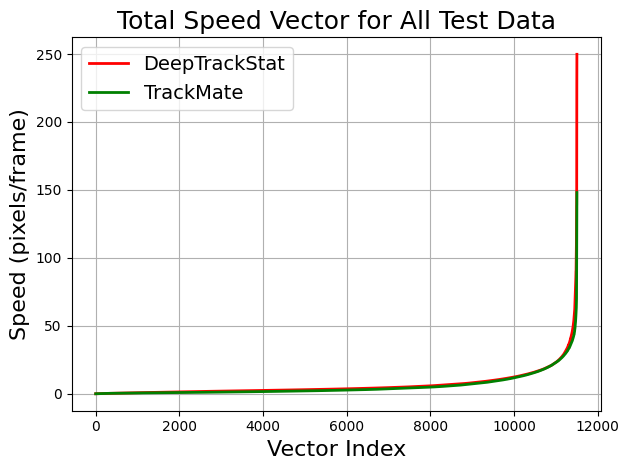

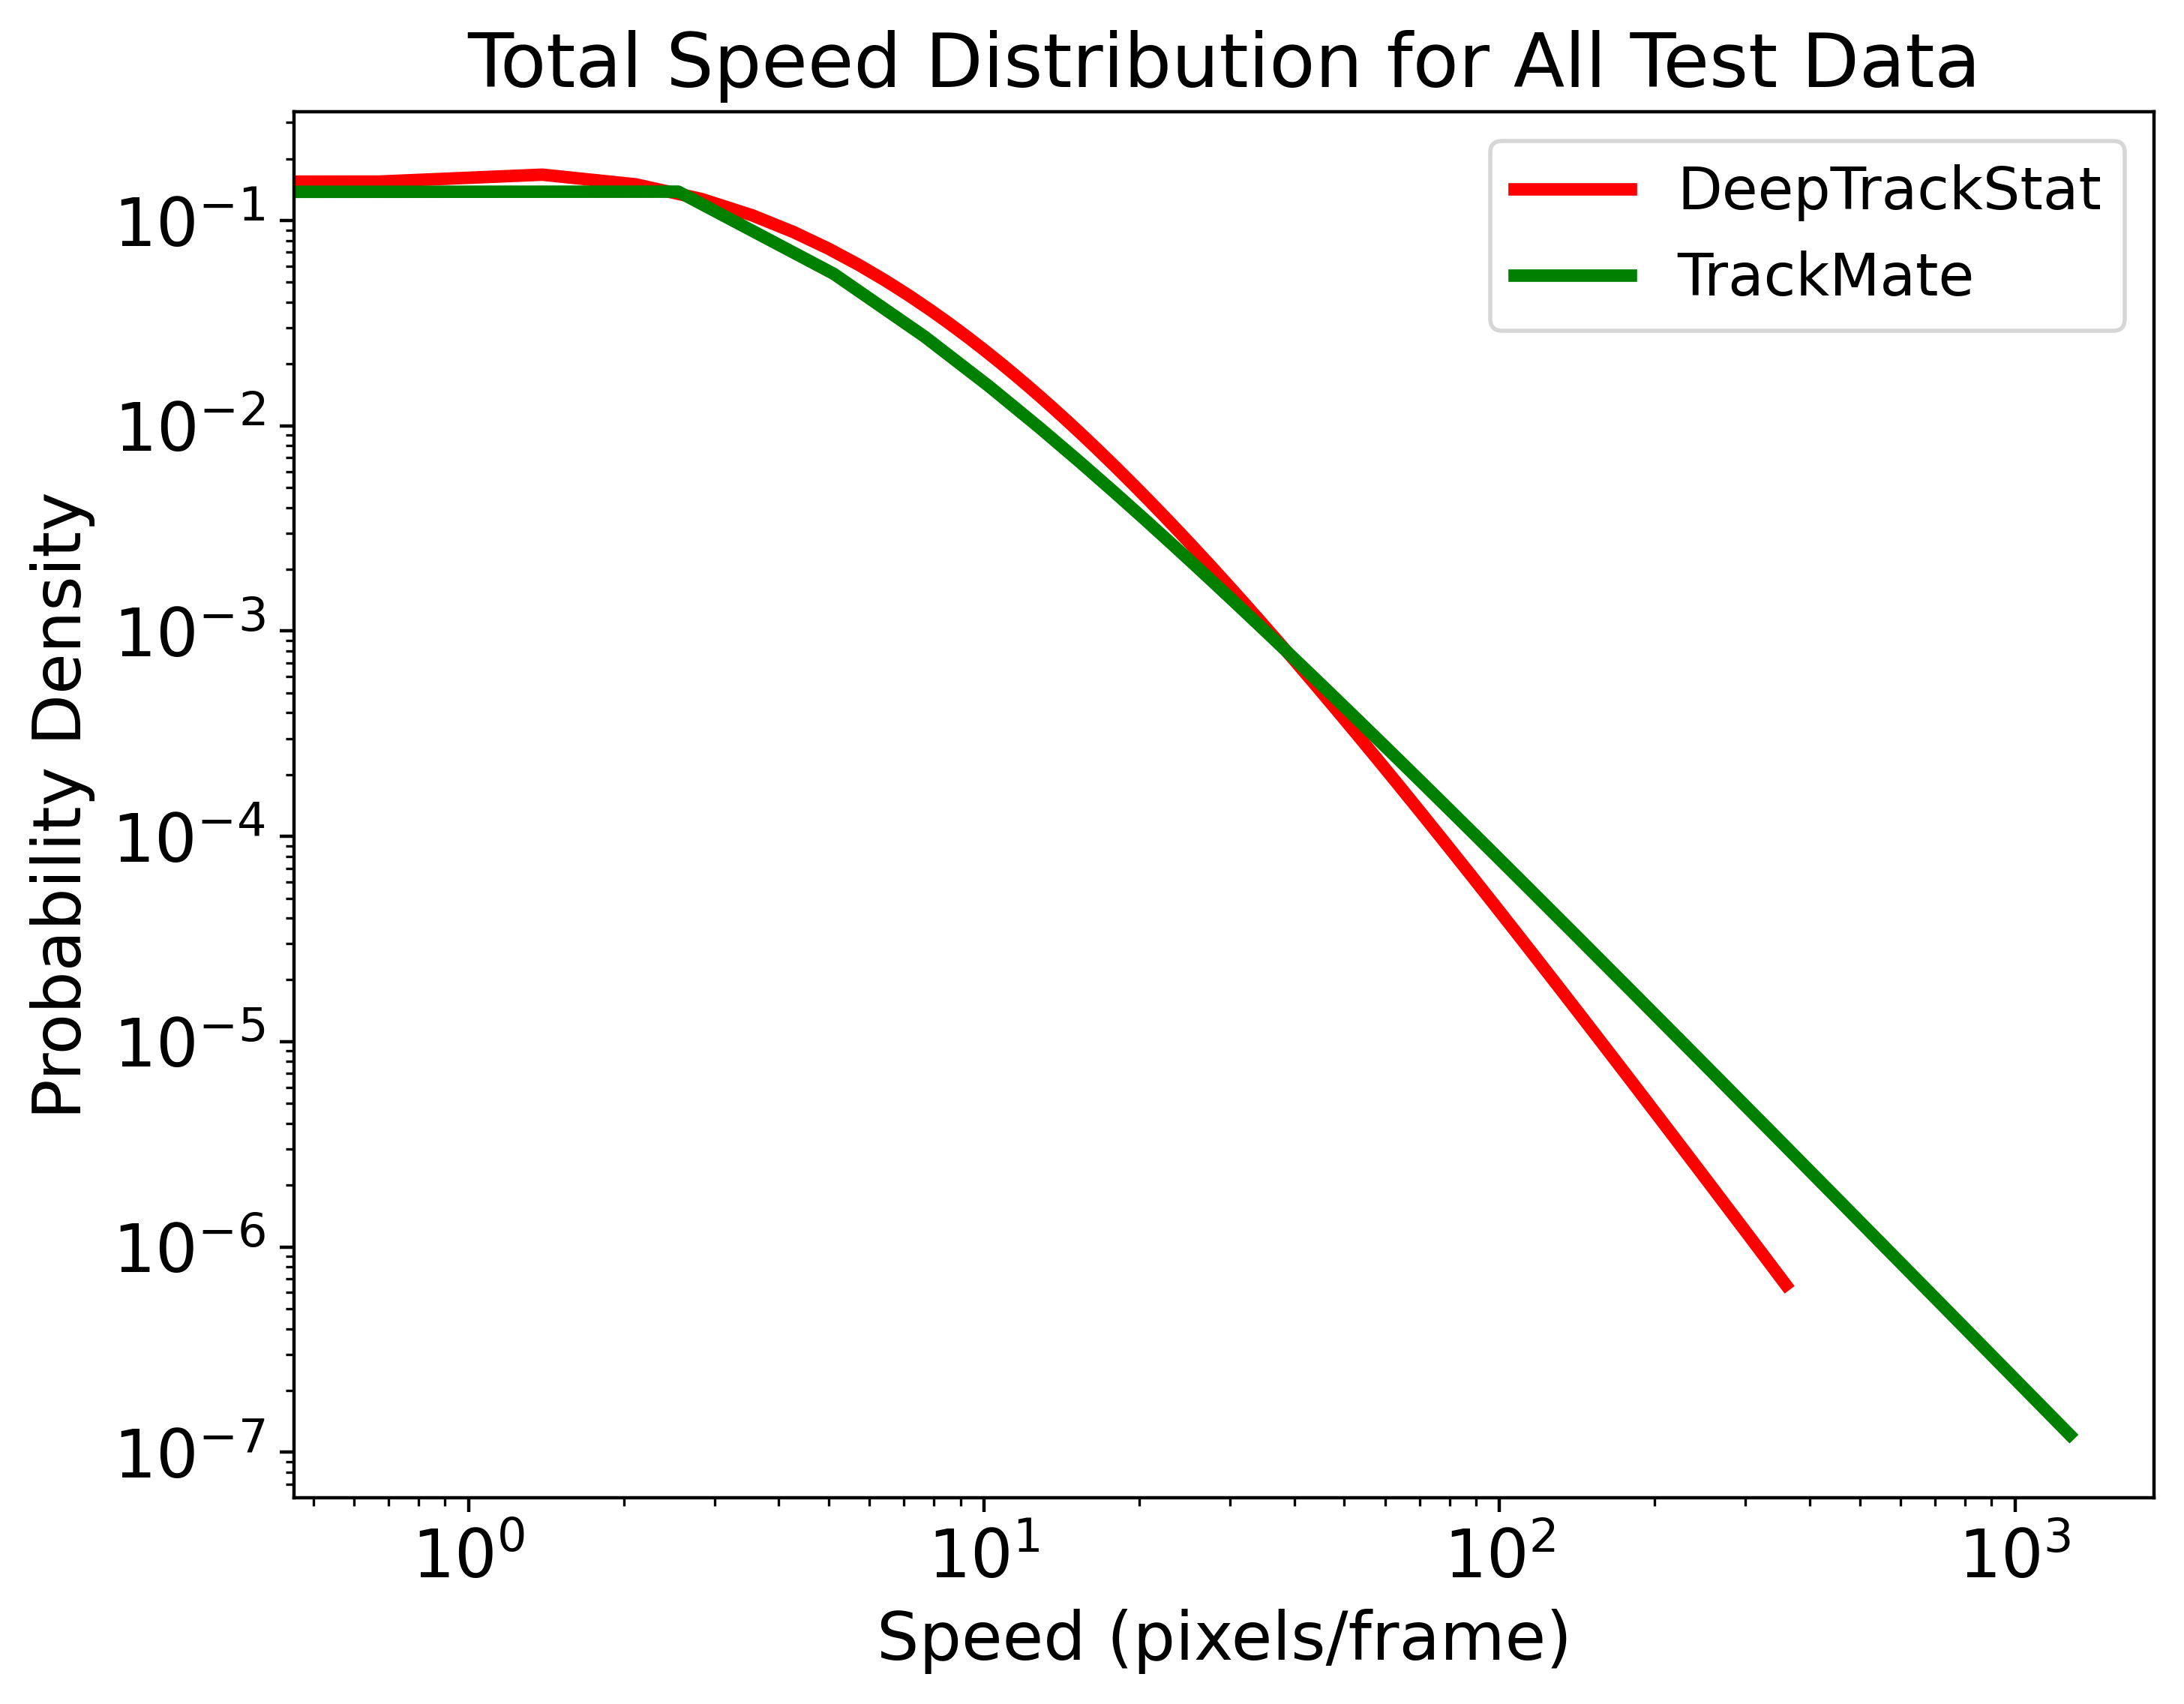

(3369171,)


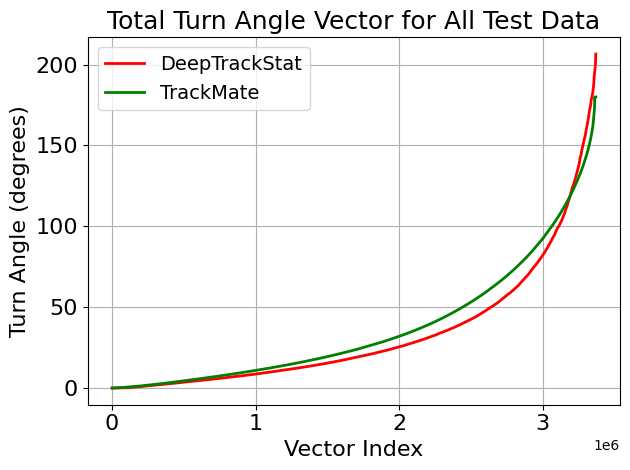

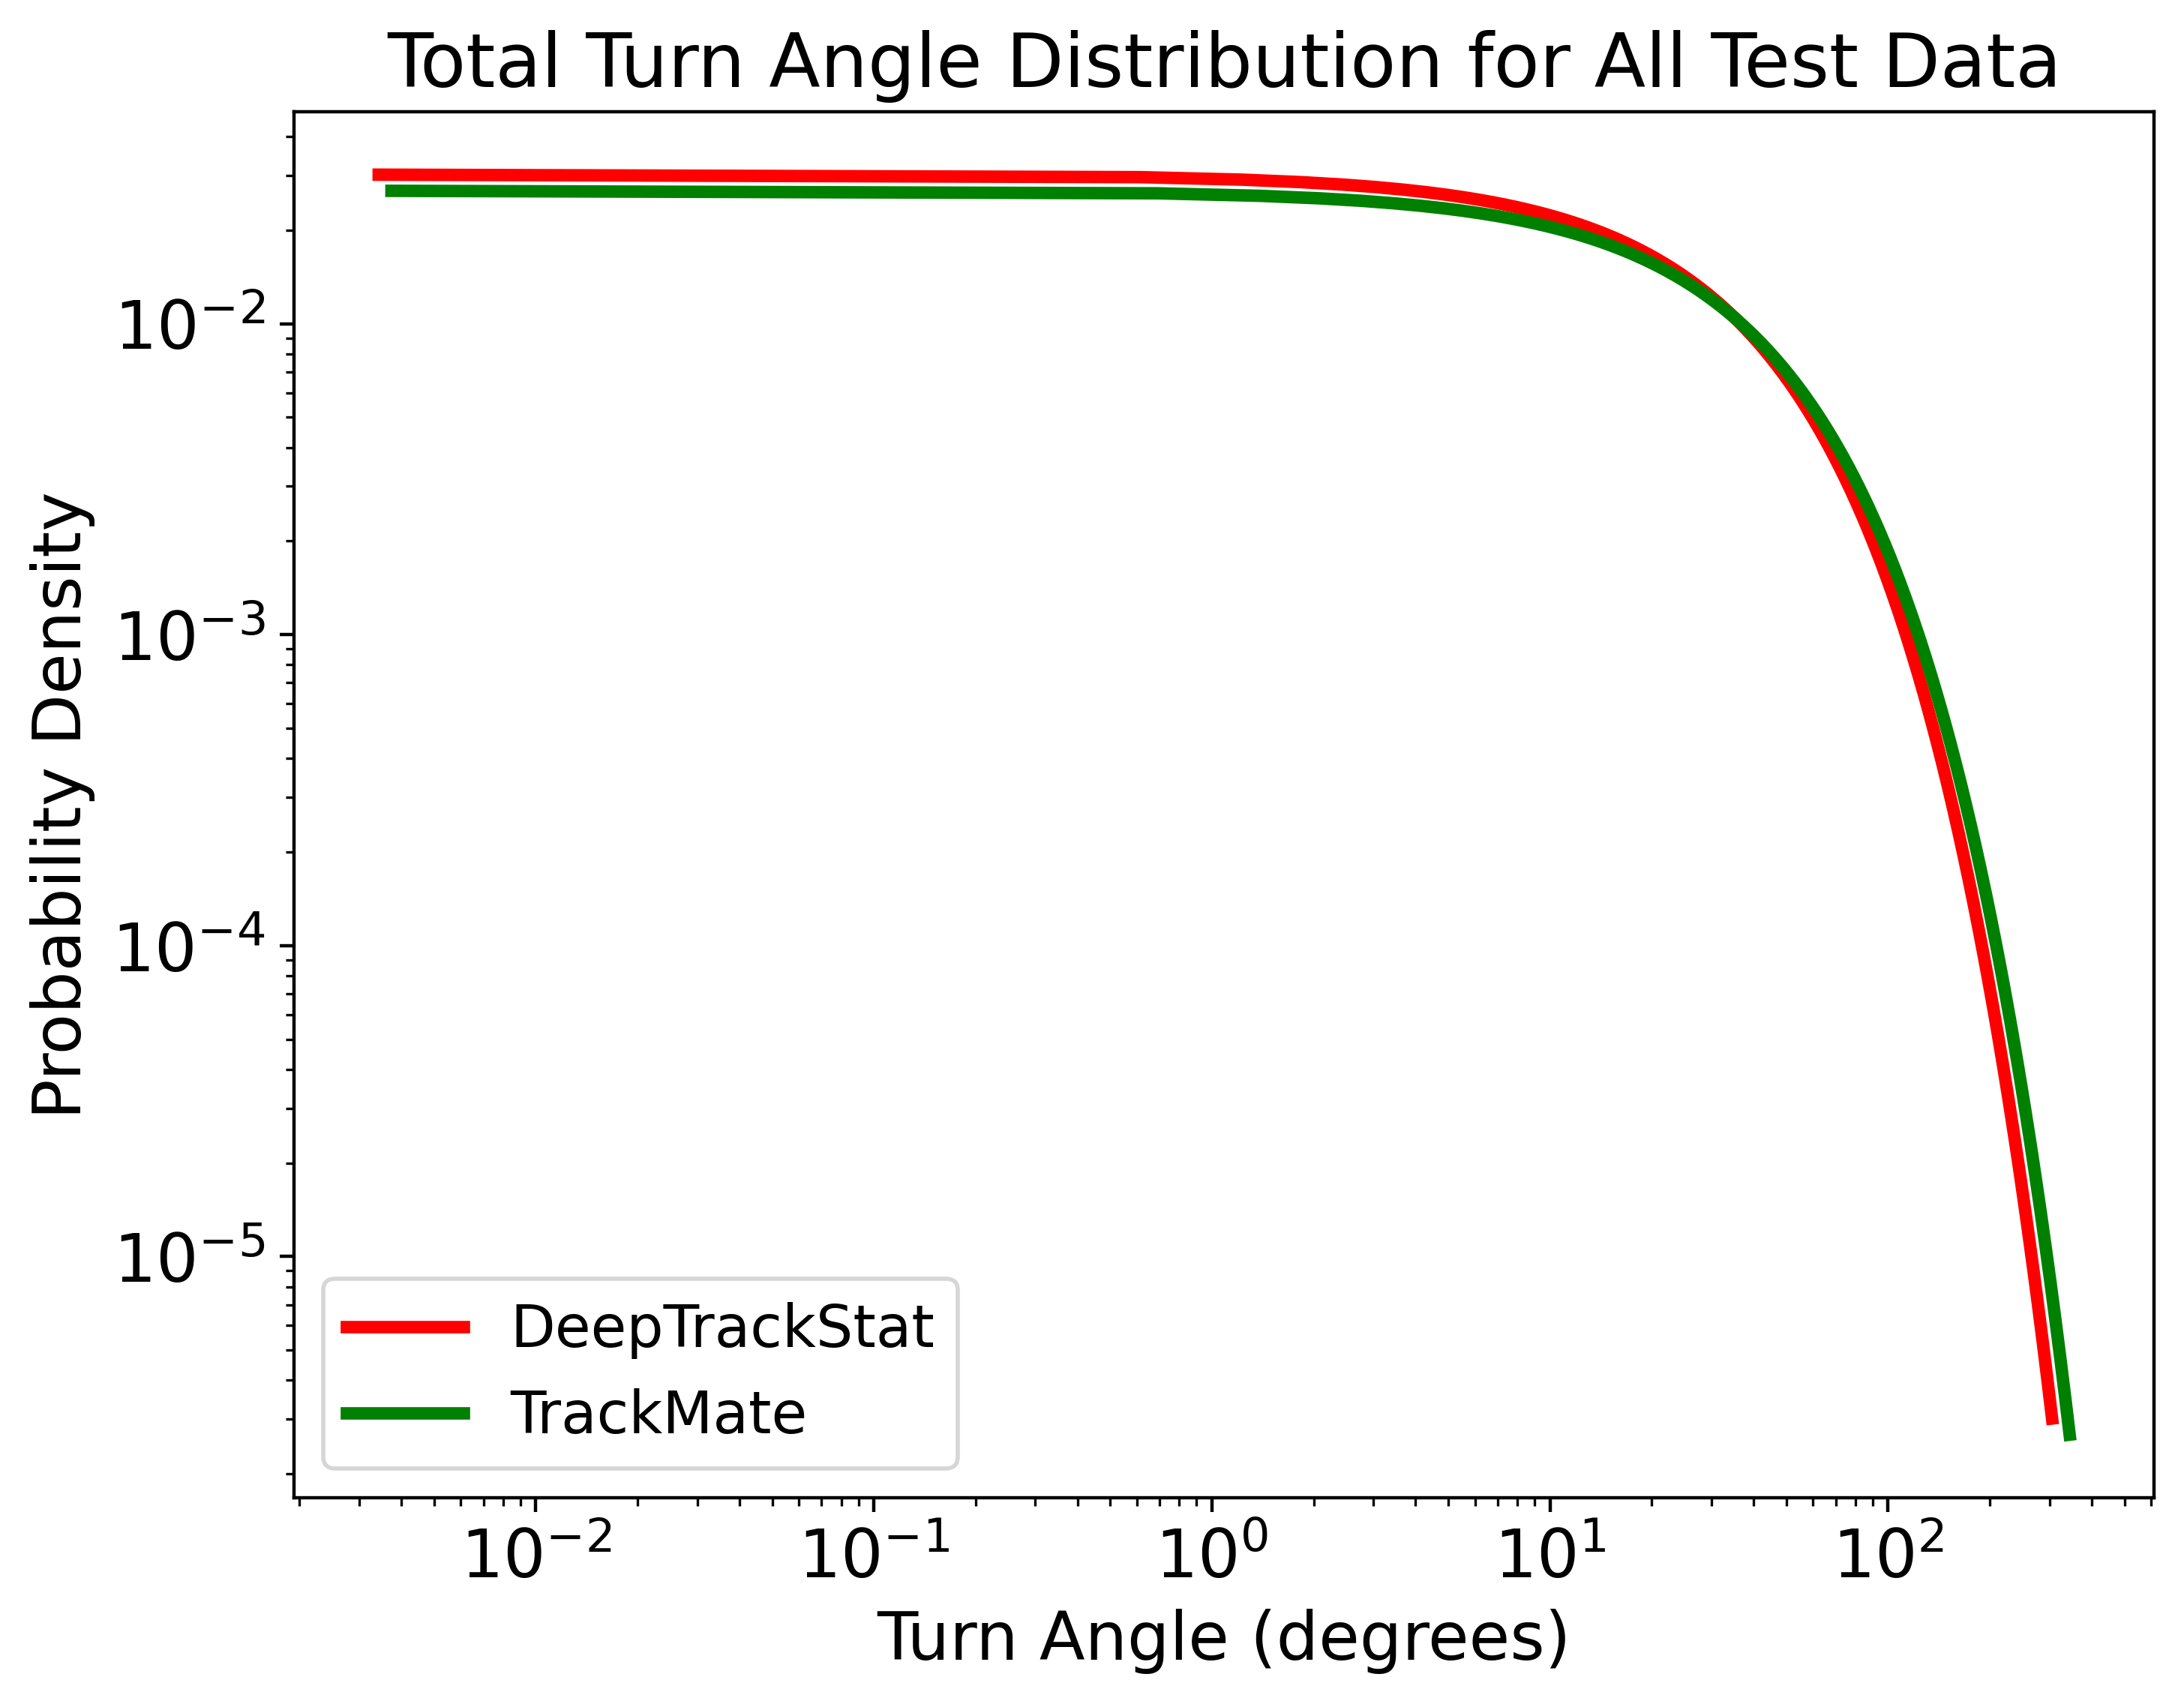

(6044733,)


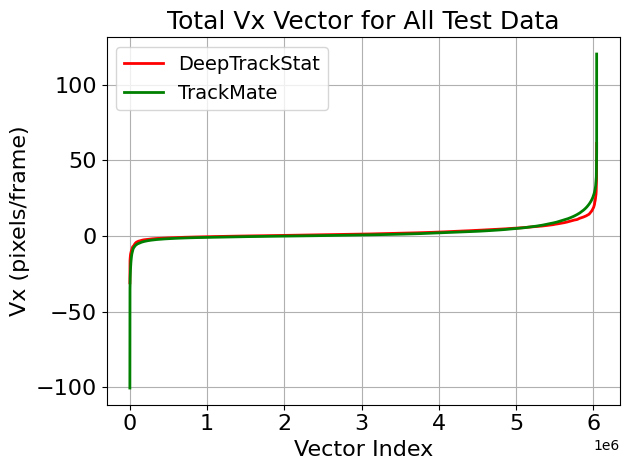

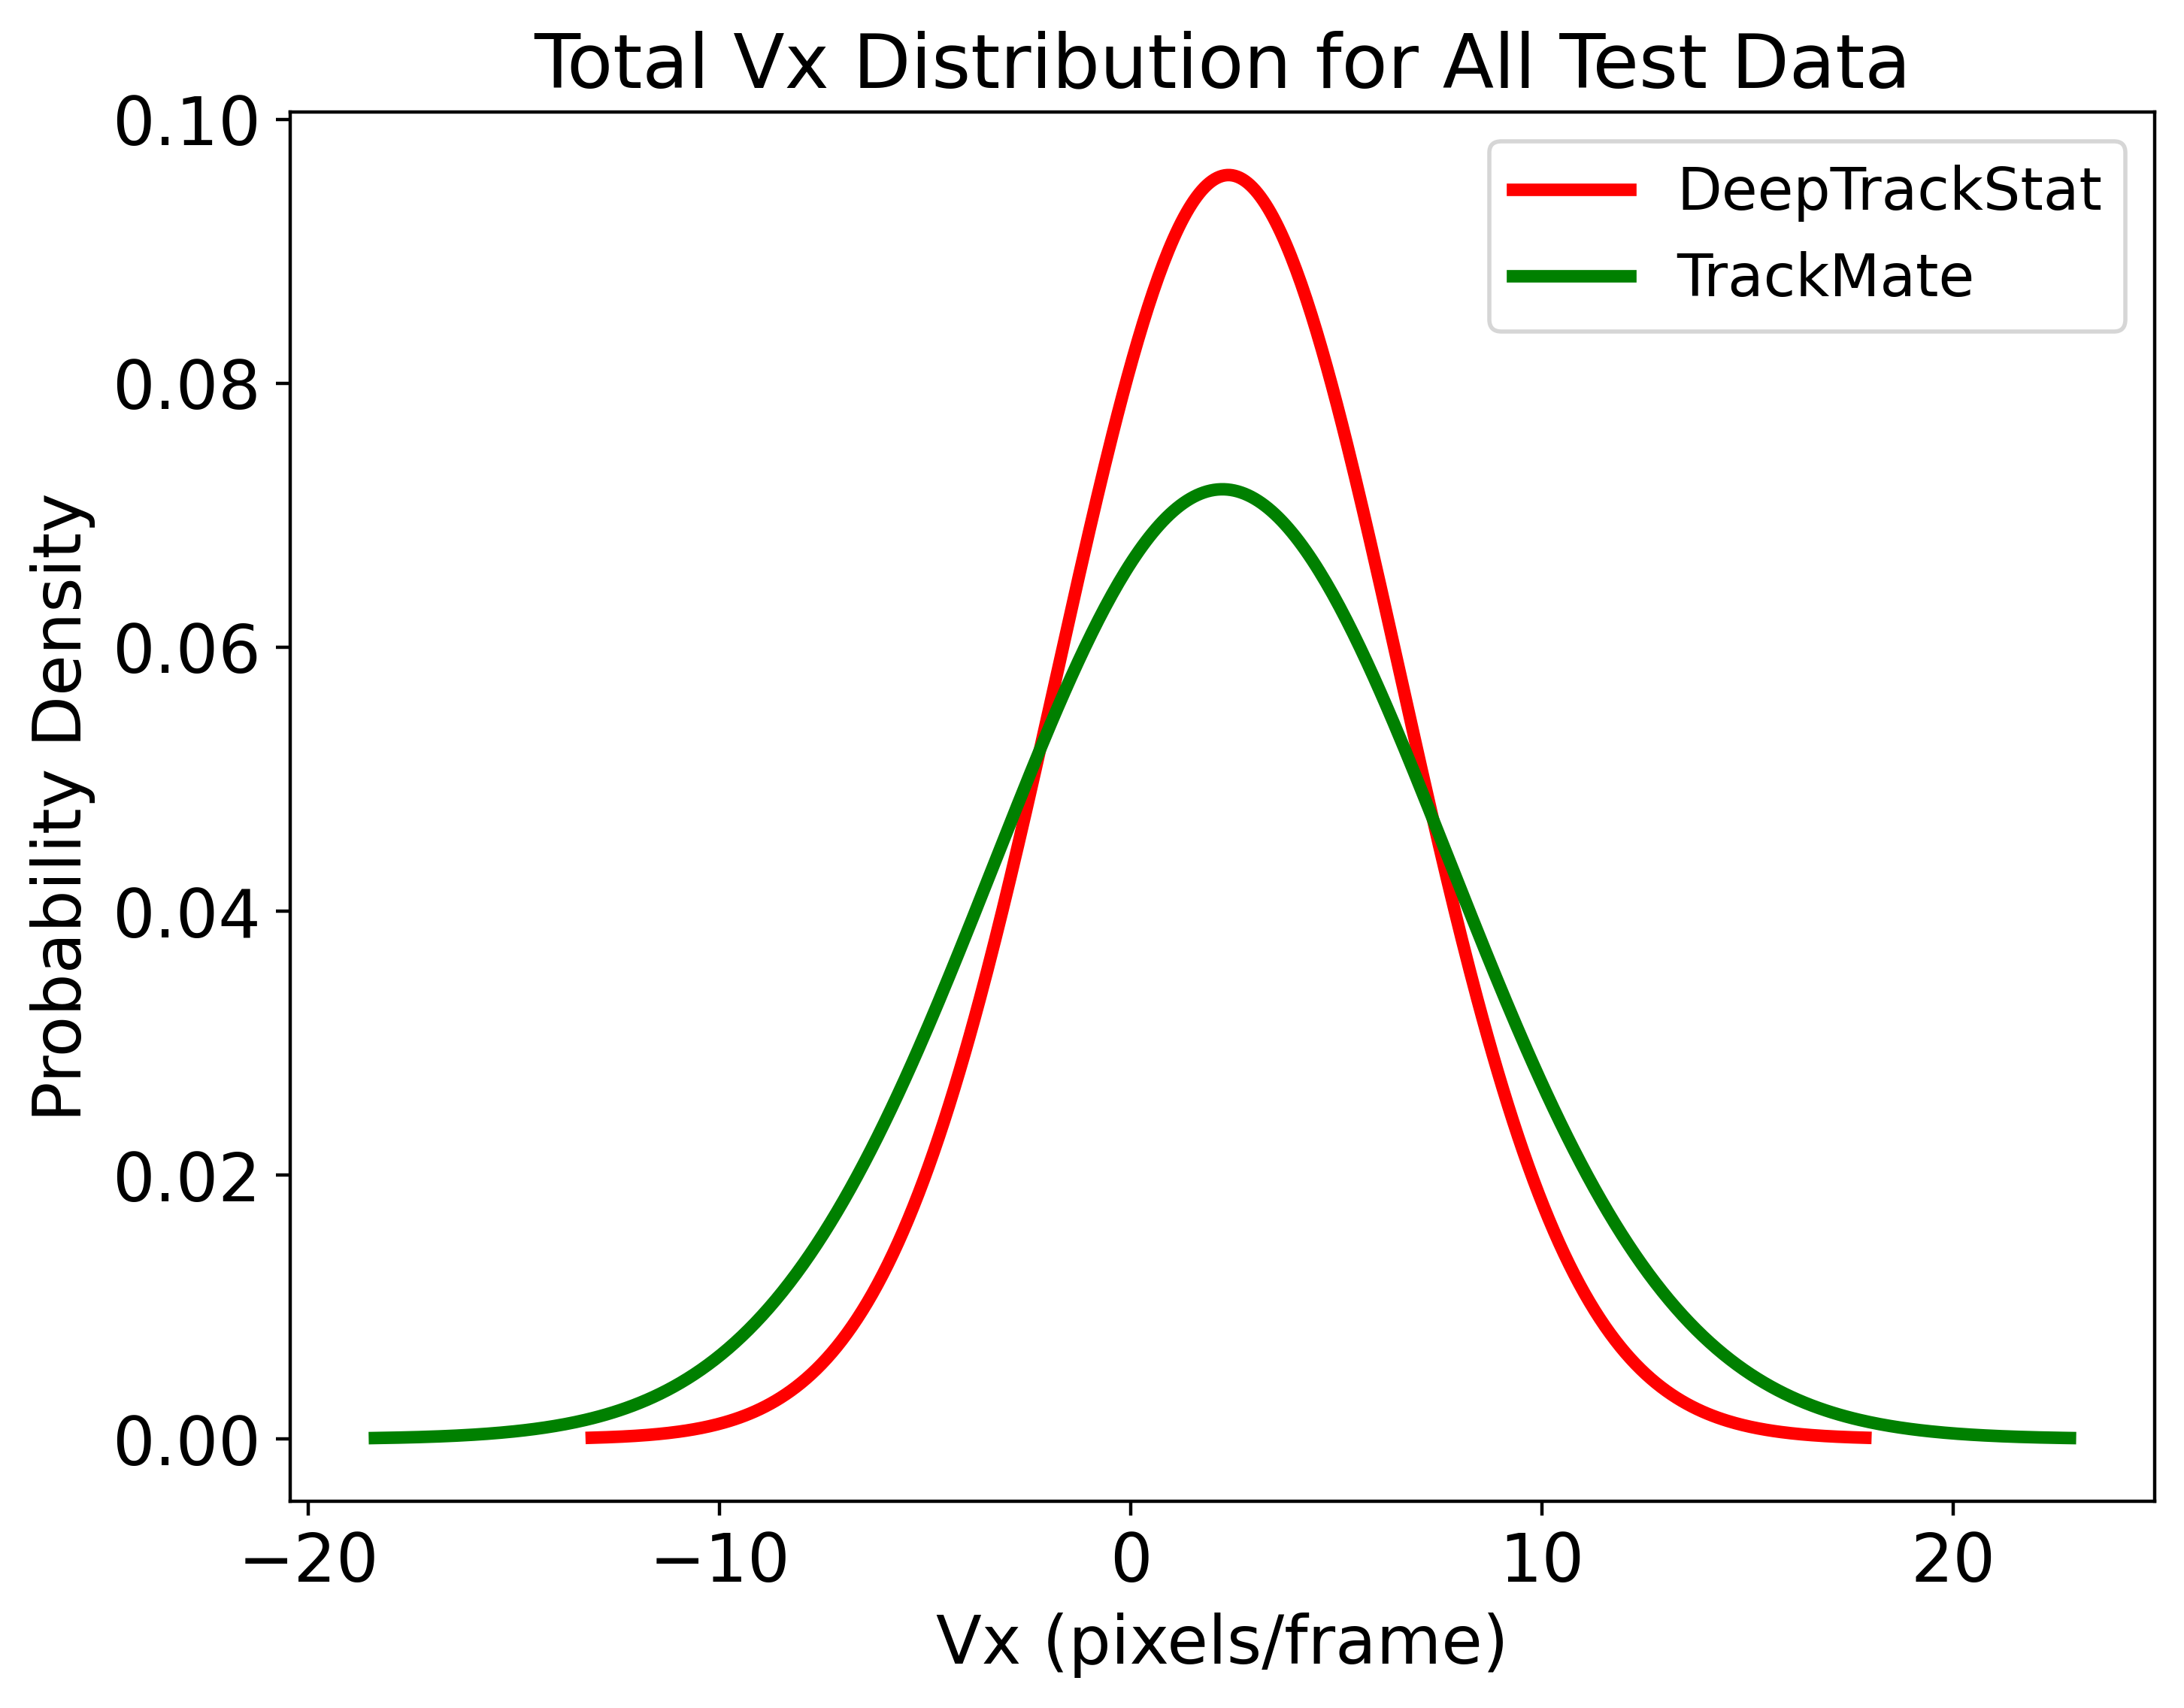

(6043880,)


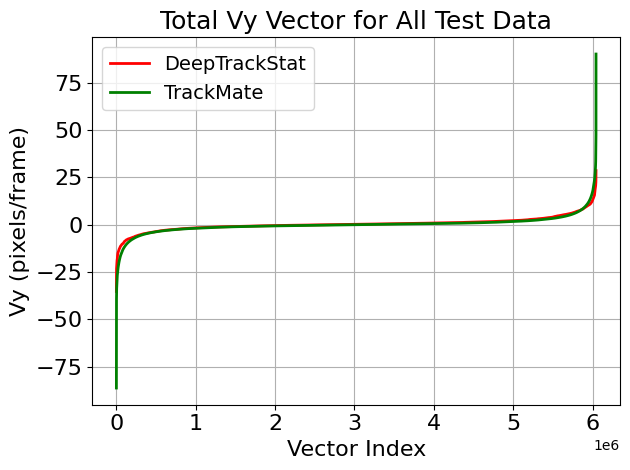

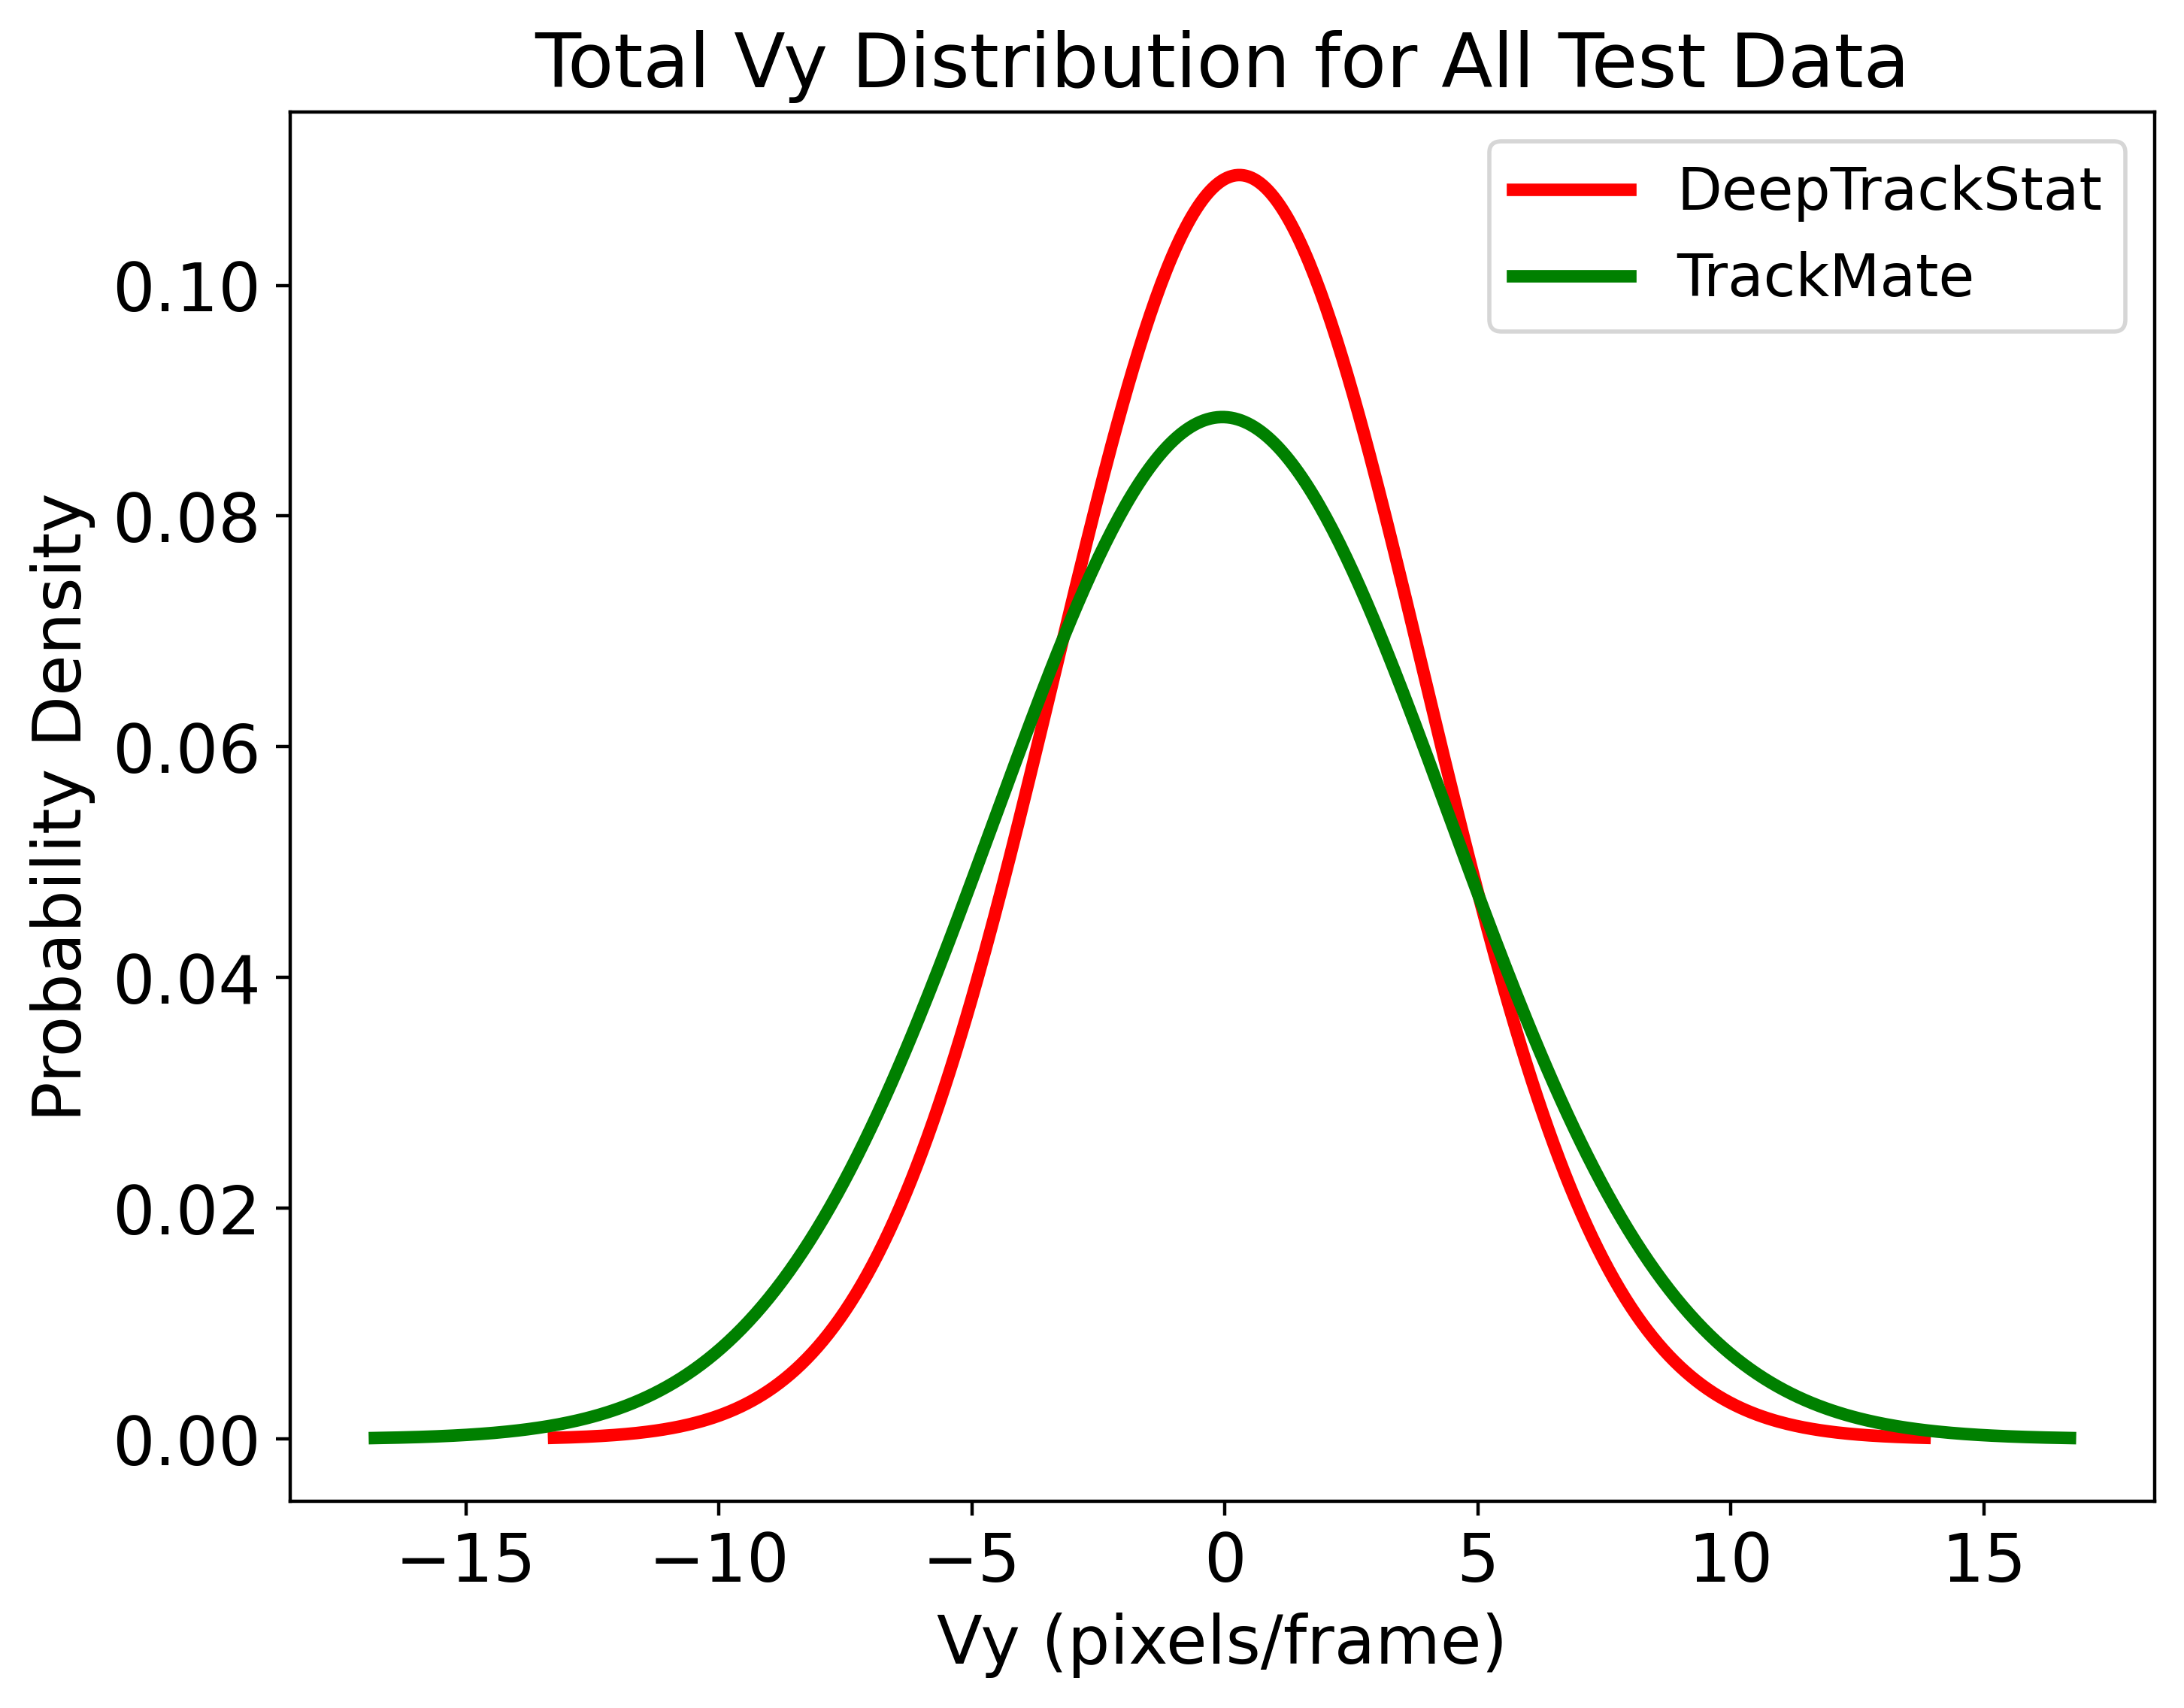

In [11]:
q = np.sort(np.hstack(final_out))
w = np.sort(np.hstack(final_true))
print(q.shape)
plt.plot(q, c='r', linewidth=2)
plt.plot(w, c='g', linewidth=2)
plt.xlabel('Vector Index', fontsize=16)
plt.ylabel('Speed (pixels/frame)', fontsize=16)
plt.title('Total Speed Vector for All Test Data', fontsize=18)
plt.legend(['DeepTrackStat', 'TrackMate'], fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('Results/Speed_final_experimental2x.png')
plt.show()

plt.figure(figsize=(8,6),dpi=400)
a,b,c,d = betaprime.fit(q)
xtorch= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), target_length)
distr_torch=betaprime.pdf(xtorch, a,b,c,d)
plt.plot(xtorch,distr_torch,c='r', linewidth=3)
a,b,c,d = betaprime.fit(w) 
xtorch= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), target_length)
distr_torch=betaprime.pdf(xtorch, a,b,c,d)
plt.plot(xtorch,distr_torch,c='g', linewidth=3)
plt.title('Total Speed Distribution for All Test Data', fontsize=18)
plt.xlabel('Speed (pixels/frame)', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.legend(['DeepTrackStat', 'TrackMate'], fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.xscale('log')
plt.yscale('log')
plt.savefig('Results/Speed_distribution_final_experimental2x.png')
plt.show()


# Angles
q = np.sort(np.hstack(final_out_ang)[::40])
print(q.shape)
w = np.sort(np.hstack(final_true_ang)[::40])
plt.plot(q, c='r', linewidth=2)
plt.plot(w, c='g', linewidth=2)
plt.xlabel('Vector Index', fontsize=16)
plt.ylabel('Turn Angle (degrees)', fontsize=16)
plt.title('Total Turn Angle Vector for All Test Data', fontsize=18)
plt.legend(['DeepTrackStat', 'TrackMate'], fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('Results/angles_final_experimental2x.png')
plt.show()

plt.figure(figsize=(8,6),dpi=400)
a,b= expon.fit(q)
xtorch= np.linspace(expon.ppf(0.0001, a,b),
                expon.ppf(0.9999, a,b), target_length)
distr_torch=expon.pdf(xtorch, a,b)
plt.plot(xtorch,distr_torch,c='r', linewidth=3)
a,b= expon.fit(w) 
xtorch= np.linspace(expon.ppf(0.0001, a,b),
                expon.ppf(0.9999, a,b), target_length)
distr_torch=expon.pdf(xtorch, a,b)
plt.plot(xtorch,distr_torch,c='g', linewidth=3)
plt.title('Total Turn Angle Distribution for All Test Data', fontsize=18)
plt.xlabel('Turn Angle (degrees)', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.legend(['DeepTrackStat', 'TrackMate'], fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.xscale('log')
plt.yscale('log')
plt.savefig('Results/angle_distribution_final_experimental2x.png')
plt.show()

#Vx
q = np.sort(np.hstack(final_out_vx))
print(q.shape)
w = np.sort(np.hstack(final_true_vx))
plt.plot(q, c='r', linewidth=2)
plt.plot(w, c='g', linewidth=2)
plt.xlabel('Vector Index', fontsize=16)
plt.ylabel('Vx (pixels/frame)', fontsize=16)
plt.title('Total Vx Vector for All Test Data', fontsize=18)
plt.legend(['DeepTrackStat', 'TrackMate'], fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('Results/Vx_final_experimental.png')
plt.show()

plt.figure(figsize=(8,6),dpi=400)
a,b= norm.fit(q)
xtorch= np.linspace(norm.ppf(0.0001, a,b),
                norm.ppf(0.9999, a,b), target_length)
distr_torch=norm.pdf(xtorch, a,b)
plt.plot(xtorch,distr_torch,c='r', linewidth=3)
a,b= norm.fit(w) 
xtorch= np.linspace(norm.ppf(0.0001, a,b),
                norm.ppf(0.9999, a,b), target_length)
distr_torch=norm.pdf(xtorch, a,b)
plt.plot(xtorch,distr_torch,c='g', linewidth=3)
plt.title('Total Vx Distribution for All Test Data', fontsize=18)
plt.xlabel('Vx (pixels/frame)', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.legend(['DeepTrackStat', 'TrackMate'], fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
# plt.xscale('log')
# plt.yscale('log')
plt.savefig('Results/Vx_distribution_final_experimental.png')
plt.show()

#Vy
q = np.sort(np.hstack(final_out_vy))
print(q.shape)
w = np.sort(np.hstack(final_true_vy))
plt.plot(q, c='r', linewidth=2)
plt.plot(w, c='g', linewidth=2)
plt.xlabel('Vector Index', fontsize=16)
plt.ylabel('Vy (pixels/frame)', fontsize=16)
plt.title('Total Vy Vector for All Test Data', fontsize=18)
plt.legend(['DeepTrackStat', 'TrackMate'], fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('Results/Vy_final_experimental.png')
plt.show()

plt.figure(figsize=(8,6),dpi=400)
a,b= norm.fit(q)
xtorch= np.linspace(norm.ppf(0.0001, a,b),
                norm.ppf(0.9999, a,b), target_length)
distr_torch=norm.pdf(xtorch, a,b)
plt.plot(xtorch,distr_torch,c='r', linewidth=3)
a,b = norm.fit(w) 
xtorch= np.linspace(norm.ppf(0.0001, a,b),
                norm.ppf(0.9999, a,b), target_length)
distr_torch=norm.pdf(xtorch, a,b)
plt.plot(xtorch,distr_torch,c='g', linewidth=3)
plt.title('Total Vy Distribution for All Test Data', fontsize=18)
plt.xlabel('Vy (pixels/frame)', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.legend(['DeepTrackStat', 'TrackMate'], fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
# plt.xscale('log')
# plt.yscale('log')
plt.savefig('Results/Vy_distribution_final_experimental.png')
plt.show()